# Initial

## Dataset Features

In [1]:
#channel.names                     = Combination of TMT Set and Pos.
#Sample_Run_ID                     = Arbitrary ID (remapped to 1-106).
#TMT Set                           = The set of up to 18 samples that was tested simultaneously.
#TMT Pos                           = The position in the set a sample had.
#CSF_type                          = L (lumbar) or V (ventricular) CSF sample.
#Diagnostic_classification_string3 = iNPH + comorbid condition (AD or VCI(Vascular Cognitive Impairment)).
#Cortical_biopsy_grouping          = 0 (no AD), 1 (early stage), 2 (later stage).
#Abeta_score                       = 0-3 scale of amount of pathological lesions (Abeta plaques) in brain sample.
#Tau_score                         = 0-3 scale of amount of pathological lesions (tau tangles) in brain sample.
#Gender                            = Gender of sampled individual
#Age_at_biopsy                     = Age of sampled individual
#Proteins                          = Comes in the form Q14515 (Accession number).
#Peptides                          = Accession number followed by position of peptide in protein (Q14515..533.552).

We received four datasets, based on proteins or peptides, and non-normalized and median normalized data.

As the protein and peptide data is from a TMT (Tandem Mass Tag), they are required to be normalized against the reference channel in order to be useful, which has already been done in all datasets. This means that each individual protein/peptide within the batch is divided by the value of that same protein/peptide in the reference channel.

Furthermore, the median normalized datasets are divided based on each patient/sample. The median value from all protein/peptide rows is found for a patient, and then values are divided by that median value.

IDEAS 
* In not median normalized dataset, unless the amount of sample per person in the TMT Set is affected by AD, it should not have any classification benefit.
* Does the median normalization remove batch effect (as stated in Sophias paper?) It seems to normalize across individuals rather than batches.

## Imports

In [2]:
#General Imports.
import pandas as pd
import numpy as np
import warnings
import sys

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

#Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

#Imputation
from sklearn.impute import SimpleImputer
from combat.pycombat import pycombat
if sys.platform != "darwin":
    import miceforest as mf

#Feature Selection
from scipy import stats

#Resampling
from imblearn.over_sampling import SMOTE

## Cleaning Code

In [3]:
def replace_inf_with_nan(df):
    """Replace inf, -inf and 100 with nan.

    :param df: Dataframe to clean inf, -inf and 100 from.
    
    :return: Dataframe without inf, -inf and 100."""
    #df.iloc[:, 11:].replace([0, 0.01], np.nan, inplace=True) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    #df.replace(['100', '100.0', '100.00', '100.000'], np.nan, inplace=True)
    df = df.applymap(lambda x: np.nan if isinstance(x, float) and x == 100.0 else x)

    return df

In [4]:
def replace_zero_with_val(df, value=0.01):
    """Replace zero values with another value.

    :param df: Dataframe to remove 0 values from.
    :param value: Value to replace 0 with.
    
    :return: Dataframe without 0 values."""
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.replace([0], value, inplace=True)
    return df

In [5]:
def remapp_id(df):
    """Remaps the arbitrary Sample_Run_ID with ID.

    :param df: Dataframe to remap Sample_Run_ID
    
    :return: Dataframe with ID.""" 
    value_mapping = {value: i + 1 for i, value in enumerate(df['Sample_Run_ID'].unique())}
    df['Sample_Run_ID'] = df['Sample_Run_ID'].map(value_mapping)
    return df

In [6]:
def replace_nan_with_zero(df):
    """Replace nan with zero.

    :param df: Dataframe to clean nan from.
    
    :return: Dataframe without nan.""" 
    return df.replace([np.nan, np.NaN], 0)

### Geometric Mean

In [7]:
def calculate_geometric_mean(column):
    """Calculates the geometric mean from a dataframe column and removes outliers.

    :param column: Dataframe column.
    
    :return: Dataframe column updated with NaN values outside of x10 of the geometric mean."""
    geometric_mean = np.exp(np.mean(np.log(column[column > 0])))
    column[(column > 10 * geometric_mean) | (column < 0.1 * geometric_mean)] = np.nan
    return column

In [8]:
def remove_extreme_values_from_df(df):
    """Remaps the arbitrary Sample_Run_ID with ID.

    :param df: Dataframe to remap Sample_Run_ID
    
    :return: Dataframe with ID.""" 
    for column_name, column in df.items():
        df[column_name] = calculate_geometric_mean(column)
    return df

### Outlier removal

In [9]:
def remove_outliers(df):
    """Removes outlier from df based on normalized values and inter quartile range.

    :param df: Dataframe to clean from outliers.
    
    :return: Cleaned dataframe.""" 
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df >= lower_bound) & (df <= upper_bound)]

In [10]:
def remove_columns_with_diff_above_thresh(df, threshold = 100):
    """Removes columns from dataframe if column contains values with over threshold magnitude difference.

    :param df: Dataframe to remove values from.
    :param threshold: Threshold value used to determine if column should be removed.
    
    :return: Dataframe without outlier columns.""" 
    column_ranges = df.max() / df.min()
    columns_with_large_difference = column_ranges[column_ranges >= threshold].index
    print(len(columns_with_large_difference))
    return df.loc[:, ~df.columns.isin(columns_with_large_difference)], columns_with_large_difference

In [11]:
def pre_process_step(df, threshold = 100):
    """Wrapper function for removing outliers, both based on column outliers and inter quartile range.

    :param df: Dataframe to remove values from.
    :param threshold: Threshold value used to determine if column should be removed.
    
    :return: Dataframe without outlier data.""" 
    df = np.log2(df) # Log2 transform to meet normality assumptions
    print("Number of missing values before any pre-processing: %d" % df.isna().sum().sum())
    df = np.exp2(remove_outliers(df)) # Remove outliers from the proteins / peptides
    print("Number of missing values after removing outliers: %d" % df.isna().sum().sum())
    df, _ = remove_columns_with_diff_above_thresh(df, threshold) # Remove columns in where the difference between prot/pep abdundance is above threshold
    print("Number of missing values after removing columns with large diff in high/low values: %d" % df.isna().sum().sum())
    return np.log2(df), _

## DataFrames

In [12]:
#Reading CSV files.
df_proteins_median_all = pd.read_csv('Data//data files//iNPH_data_protein_median.csv', index_col=0)
df_proteins_all = pd.read_csv('Data//data files//iNPH_data_protein_nonormalization.csv', index_col=0)
df_peptides_median_all = pd.read_csv('Data//data files//iNPH_data_peptide_median.csv', index_col=0)
df_peptides_all = pd.read_csv('Data//data files//iNPH_data_peptide_nonormalization.csv', index_col=0)

In [13]:
#Remove inf and remapp id.
df_proteins_median_all = remapp_id(replace_inf_with_nan(df_proteins_median_all))
df_proteins_all = remapp_id(replace_inf_with_nan(df_proteins_all))
df_peptides_median_all = remapp_id(replace_inf_with_nan(df_peptides_median_all))
df_peptides_all = remapp_id(replace_inf_with_nan(df_peptides_all))

In [14]:
#Only protein and peptide features.
df_proteins_median = df_proteins_median_all.iloc[:, 11:]
df_proteins = df_proteins_all.iloc[:, 11:]
df_peptides_median = df_peptides_median_all.iloc[:, 11:]
df_peptides = df_peptides_all.iloc[:, 11:]

#Lumbar, full dataset.
df_proteins_median_all_lumbar = df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'L']
df_proteins_all_lumbar = df_proteins_all[df_proteins_all['CSF_type'] == 'L']
df_peptides_median_all_lumbar = df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'L']
df_peptides_all_lumbar = df_peptides_all[df_peptides_all['CSF_type'] == 'L']

#Lumbar, only protein or peptide features.
df_proteins_median_lumbar = df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'L'].iloc[:, 11:]
df_proteins_lumbar = df_proteins_all[df_proteins_all['CSF_type'] == 'L'].iloc[:, 11:]
df_peptides_median_lumbar = df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'L'].iloc[:, 11:]
df_peptides_lumbar = df_peptides_all[df_peptides_all['CSF_type'] == 'L'].iloc[:, 11:]

#Ventricular, full dataset.
df_proteins_median_all_ventricular = df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V']
df_proteins_all_ventricular = df_proteins_all[df_proteins_all['CSF_type'] == 'V']
df_peptides_median_all_ventricular = df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V']
df_peptides_all_ventricular = df_peptides_all[df_peptides_all['CSF_type'] == 'V']

#Ventricular, only pretein or peptide features.
df_proteins_median_ventricular = df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V'].iloc[:, 11:]
df_proteins_ventricular = df_proteins_all[df_proteins_all['CSF_type'] == 'V'].iloc[:, 11:]
df_peptides_median_ventricular = df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V'].iloc[:, 11:]
df_peptides_ventricular = df_peptides_all[df_peptides_all['CSF_type'] == 'V'].iloc[:, 11:]

## Filtration Code

In [15]:
def set_max_missingness_per_column(df, threshold=0.5, negative=False):
    """Removes columns with nan values above a threshold.

    :param df: Dataframe-base to remove NaN-heavy columns from.
    :param threshold: Threshold percentage of missingness allowed per column.
    :param negative: Used if wanting to return all columns with more than threshold missingness.
    
    :return: New dataframe without NaN-heavy columns.""" 
    if not negative:
        nan_percentage = (df.isna().mean()).round(4)
        selected_columns = nan_percentage[nan_percentage <= threshold].index
        return df[selected_columns]
    
    nan_percentage = (df.isna().mean()).round(4)
    selected_columns = nan_percentage[nan_percentage >= threshold].index
    return df[selected_columns]

In [16]:
def get_missingness_based_on_column(df, col):
    """Gets missingness based on column groups.

    :param df: Dataframe to check columns for missingness.
    :param col: Particular column to group by.
    
    :return: Dictionary with groups and missingness.""" 
    return df.groupby(col).apply(lambda group: group.isna().mean().mean()).round(4).to_dict()

# Exploration

## Distribution

### Mena value Distribution

<Figure size 1400x800 with 0 Axes>

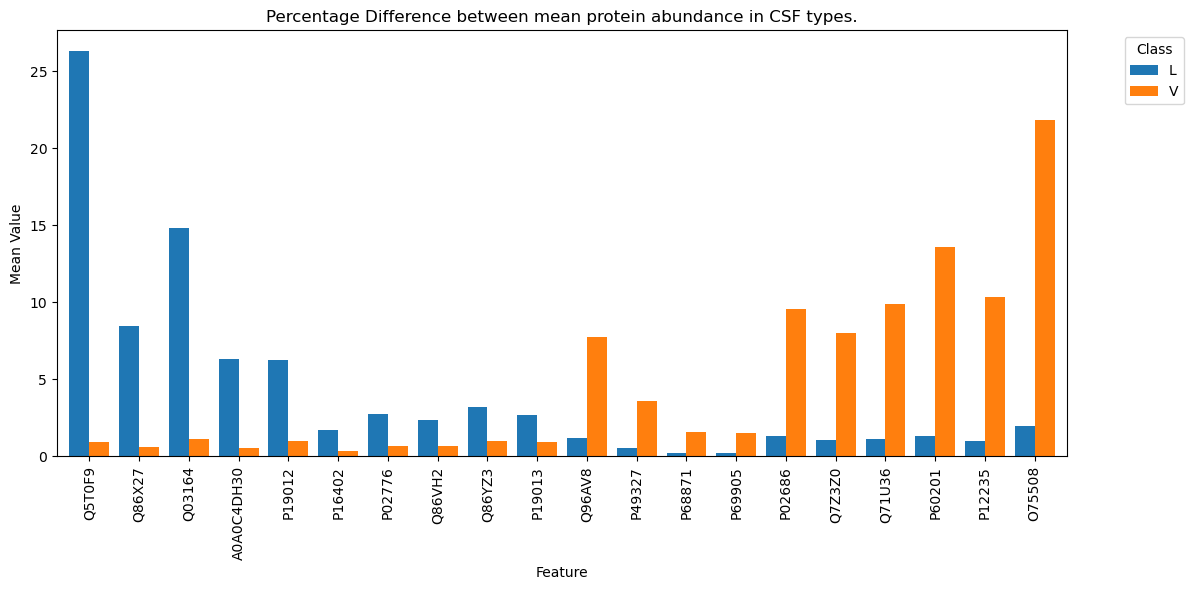

In [17]:
df_difference_csf = pd.merge(df_proteins_median, df_proteins_median_all[["CSF_type", "Cortical_biopsy_grouping"]], left_index=True, right_index=True)
means_csf = df_difference_csf.groupby('CSF_type').mean()
means_csf.dropna(axis=1, inplace=True)

percentage_difference_L = abs(means_csf.iloc[0]  /  means_csf.iloc[1]) * 100
percentage_difference_V = abs(means_csf.iloc[1]  /  means_csf.iloc[0]) * 100
sorted_percentage_difference_L = percentage_difference_L.sort_values(ascending=False)
sorted_percentage_difference_V = percentage_difference_V.sort_values(ascending=False)

means = means_csf.T

class_1_top_features = sorted_percentage_difference_L[(means_csf.iloc[0] > means_csf.iloc[1]) & (means_csf.index[0] == "L")].head(10)
class_2_top_features = sorted_percentage_difference_V[(means_csf.iloc[1] > means_csf.iloc[0]) & (means_csf.index[1] == "V")].head(10)

top_features_indices = class_1_top_features.index.union(class_2_top_features.index)
top_features_means = means.loc[top_features_indices]

class_1_sorted_features = class_1_top_features.sort_values(ascending=False)
class_2_sorted_features = class_2_top_features.sort_values(ascending=True)

sorted_top_features = pd.concat([class_1_sorted_features, class_2_sorted_features])
sorted_top_features_means = top_features_means.loc[sorted_top_features.index]

plt.figure(figsize=(14, 8))
sorted_top_features_means.plot(kind='bar', figsize=(12,6), width=0.8)
plt.title('Percentage Difference between mean protein abundance in CSF types.')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

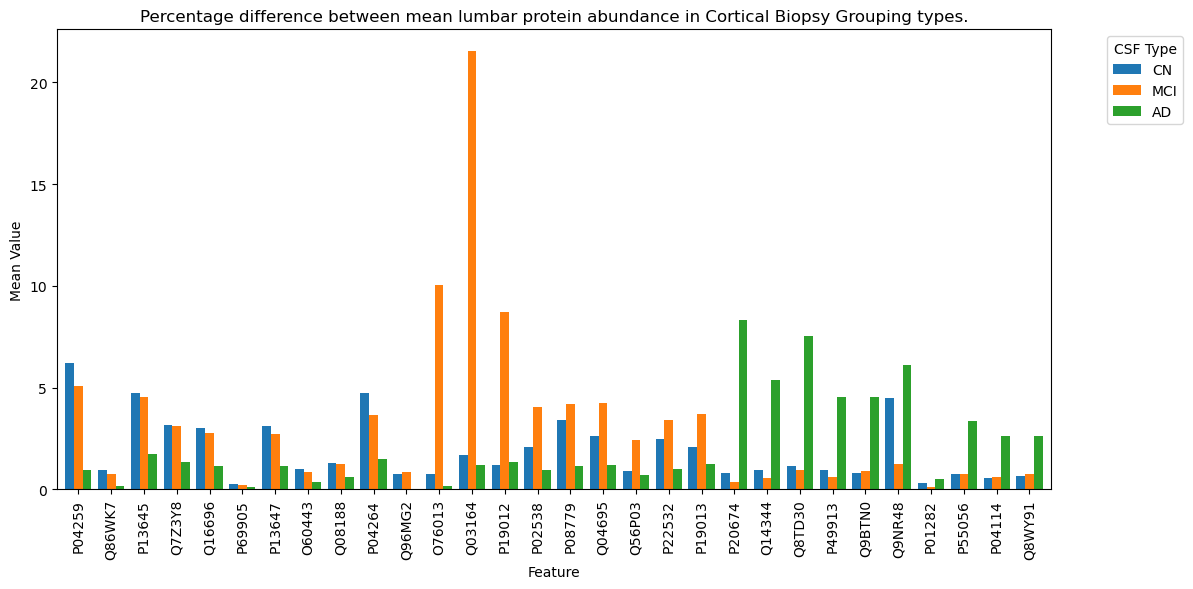

In [18]:
df_difference_cbg = pd.merge(df_proteins_median_lumbar, df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'L'][["Cortical_biopsy_grouping"]], left_index=True, right_index=True)
means_cbg = df_difference_cbg.groupby('Cortical_biopsy_grouping').mean()
means_cbg.dropna(axis=1, inplace=True)

means = means_cbg.T

percentage_difference = abs(means.div(means.max(axis=1), axis=0).diff(axis=1).iloc[:, -1]) * 100
sorted_percentage_difference = percentage_difference.sort_values(ascending=False)

class_1_top_features = sorted_percentage_difference[means.idxmax(axis=1) == 0].head(10)
class_2_top_features = sorted_percentage_difference[means.idxmax(axis=1) == 1].head(10)
class_3_top_features = sorted_percentage_difference[means.idxmax(axis=1) == 2].head(10)

top_features_indices = class_1_top_features.index.union(class_2_top_features.index).union(class_3_top_features.index)
top_features_means = means.loc[top_features_indices]

class_1_sorted_features = class_1_top_features.sort_values(ascending=False)
class_2_sorted_features = class_2_top_features.sort_values(ascending=False)
class_3_sorted_features = class_3_top_features.sort_values(ascending=False)

sorted_top_features = pd.concat([class_1_sorted_features, class_2_sorted_features, class_3_sorted_features])

sorted_top_features_means = top_features_means.loc[sorted_top_features.index]

plt.figure(figsize=(14, 8))
sorted_top_features_means.plot(kind='bar', figsize=(12,6), width=0.8)
plt.title('Percentage difference between mean lumbar protein abundance in Cortical Biopsy Grouping types.')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.legend(["CN", "MCI", "AD"], title='CSF Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

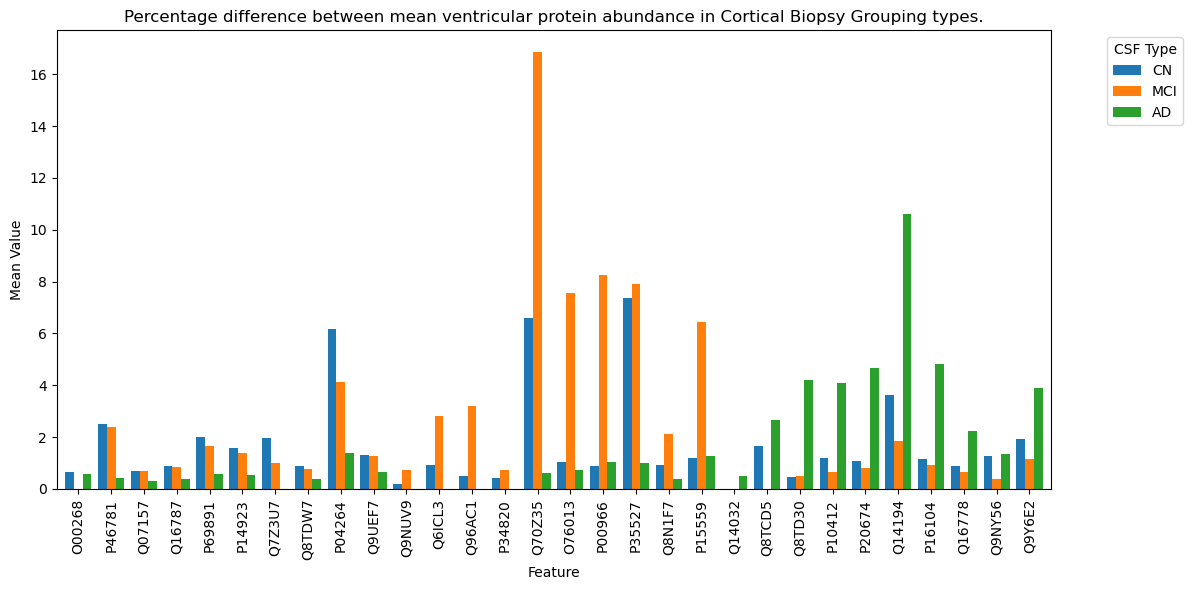

In [19]:
df_difference_cbg = pd.merge(df_proteins_median_ventricular, df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V'][["Cortical_biopsy_grouping"]], left_index=True, right_index=True)
means_cbg = df_difference_cbg.groupby('Cortical_biopsy_grouping').mean()
means_cbg.dropna(axis=1, inplace=True)

means = means_cbg.T

percentage_difference = abs(means.div(means.max(axis=1), axis=0).diff(axis=1).iloc[:, -1]) * 100
sorted_percentage_difference = percentage_difference.sort_values(ascending=False)

class_1_top_features = sorted_percentage_difference[means.idxmax(axis=1) == 0].head(10)
class_2_top_features = sorted_percentage_difference[means.idxmax(axis=1) == 1].head(10)
class_3_top_features = sorted_percentage_difference[means.idxmax(axis=1) == 2].head(10)

top_features_indices = class_1_top_features.index.union(class_2_top_features.index).union(class_3_top_features.index)
top_features_means = means.loc[top_features_indices]

class_1_sorted_features = class_1_top_features.sort_values(ascending=False)
class_2_sorted_features = class_2_top_features.sort_values(ascending=False)
class_3_sorted_features = class_3_top_features.sort_values(ascending=False)

sorted_top_features = pd.concat([class_1_sorted_features, class_2_sorted_features, class_3_sorted_features])

sorted_top_features_means = top_features_means.loc[sorted_top_features.index]

plt.figure(figsize=(14, 8))
sorted_top_features_means.plot(kind='bar', figsize=(12,6), width=0.8)
plt.title('Percentage difference between mean ventricular protein abundance in Cortical Biopsy Grouping types.')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.legend(["CN", "MCI", "AD"], title='CSF Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### CSF Type Samples

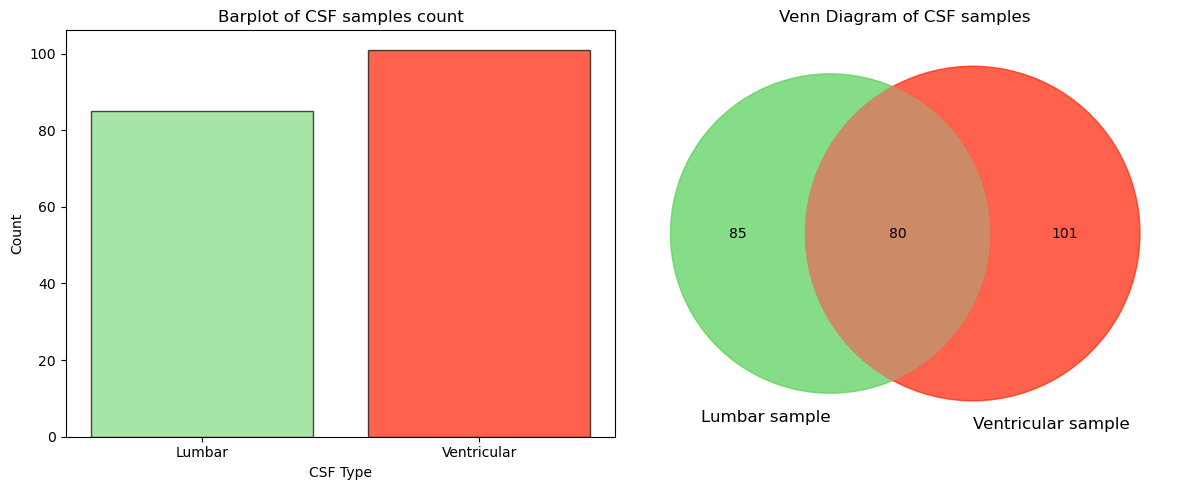

In [20]:
#--- TYPES OF SAMPLES BARPLOT AND VENN DIAGRAM ---#
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#Barplot
value_counts = df_proteins_median_all['CSF_type'].value_counts()
value_counts = value_counts.sort_values()

axs[0].bar(value_counts.index, value_counts, color=['#80DA80', '#FF2000'], edgecolor='black', alpha=0.7)
axs[0].set_xlabel('CSF Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Barplot of CSF samples count')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Lumbar', 'Ventricular'], rotation='horizontal')

#Venn Diagram
pers_id_with_L = set(df_proteins_median_all_lumbar['Sample_Run_ID'])

pers_id_with_V = set(df_proteins_median_all_ventricular['Sample_Run_ID'])

v = venn2(subsets=(len(pers_id_with_L), len(pers_id_with_V), len(pers_id_with_L & pers_id_with_V)),
      set_labels=('Lumbar sample', 'Ventricular sample'), ax=axs[1])
v.get_patch_by_id('10').set_color('#55CE55')
v.get_patch_by_id('10').set_alpha(0.7)
v.get_patch_by_id('01').set_color('#FF2000')
v.get_patch_by_id('01').set_alpha(0.7)
v.get_patch_by_id('11').set_color('#CC8A66')
v.get_patch_by_id('11').set_alpha(1)

axs[1].set_title('Venn Diagram of CSF samples')

plt.tight_layout()
plt.show()

This shows that we have slightly more ventricular samples compared to lumbar samples. The Venn diagram further tells us that we have both samples from 80 individuals, 21 ventricular-only samples and 5 lumbar-only samples. This totals to 186 samples. Considering the low amount of samples, splitting the dataset into ventricular and lumbar samples may be hard, but may give some information during the exploration phase.

Furthermore, exploring the dataset, we can see that TMT Set (batches) can contain samples from both lumbar and ventricular in the same batch. 

### Lumbar vs Ventricular concentration

In [21]:
def plot_mean_values_pdf(*lists, legend, title, xlim=None):
    """
    Plots PDF of items in list.

    :param *lists: The lists to plot a PDF.
    :param legend: List of the labels of the plot.
    :param title: Title of the plot.
    :param xlim: Sets the xlim of the plot. 
    """ 
    plt.figure(figsize=(8, 6))
    for i, data_list in enumerate(lists):
        mean_values = np.mean(data_list, axis=0)
        sns.kdeplot(mean_values, fill=True, label=f'{legend[i]}')
    
    plt.xlabel('Mean Values')
    plt.ylabel('Density')
    plt.title(title)
    plt.grid(True)
    if xlim:
        plt.xlim(xlim)
    plt.legend()
    plt.show()

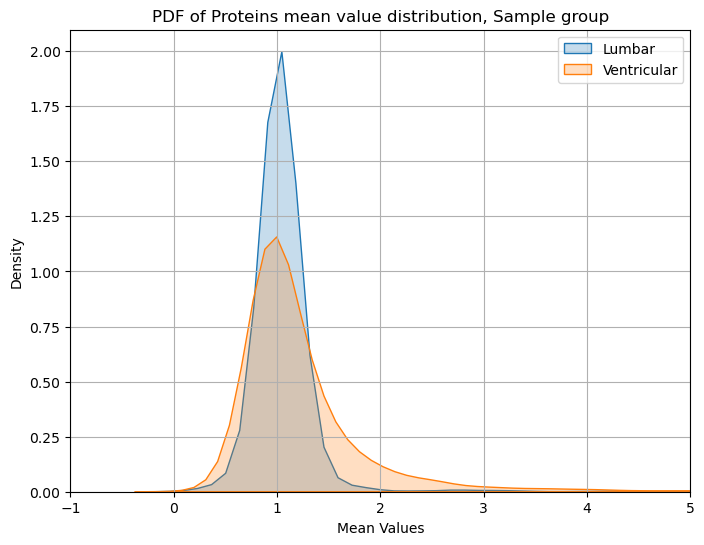

In [22]:
#Protein Median Lumbar
plot_mean_values_pdf(df_proteins_median_lumbar, df_proteins_median_ventricular, legend=['Lumbar', 'Ventricular'], title='PDF of Proteins mean value distribution, Sample group', xlim=(-1,5))

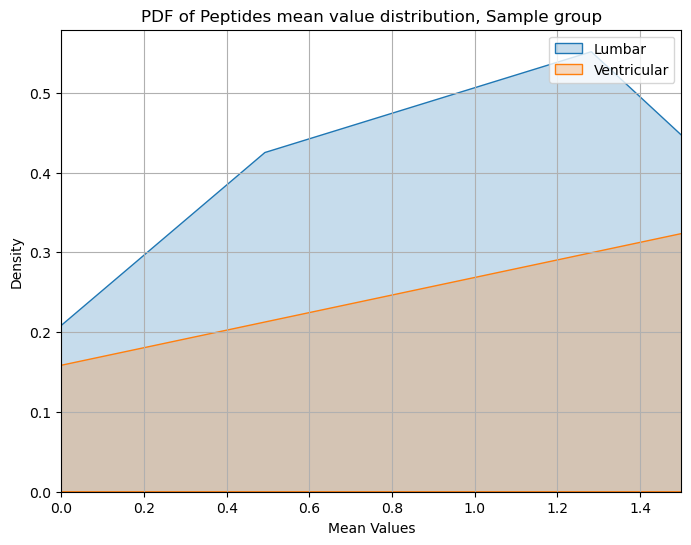

In [23]:
#Peptide Median Lumbar
plot_mean_values_pdf(df_peptides_median_lumbar, df_peptides_median_ventricular, legend=['Lumbar', 'Ventricular'], title='PDF of Peptides mean value distribution, Sample group', xlim=(-0,1.5))

(WHEN RUNNING NON NORMALIZED)

These two graphs does not conform with our understanding of the data. From our understanding, the ventricular samples, whome are taken closer to the brain, should have a higher concentration of proteins, while the lumbar samples are diluted (still containing the same type of proteins, but at a lower concentraion). This graph, however, states that the concentration is higher in the lumbar samples compared to the ventricular ones. Furthermore, the y-axis seems to suggest that the Lumbar samples of more prevelant, which is false. Further investigation needs to be done in order to confirm these findings.

(WHEN RUNNING MEDIAN NORMALIZED)

We noticed that when running the PDF on the median normalized datasets, the above findings does not hold true. This means that when normalizing the data, the ventricular samples seems to have a higher concentration than the lumbar samples does. This is consistent with our hypothesis. This does, however, seem to suggest that there may be some slight bias during during sample preparation. Maybe slightly more lumbar samples are used (more than ventricular)?

### Alzheimer's Disease Pathogenesis

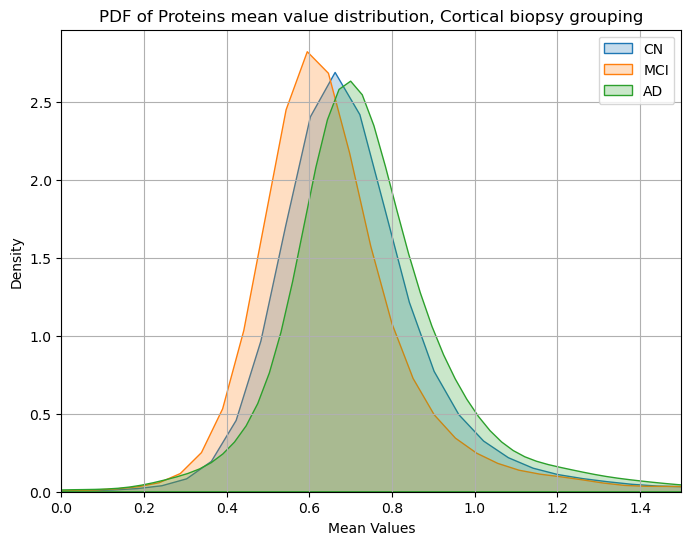

In [20]:
#Proteins Lumbar, Cortical Biopsy Grouping
plot_mean_values_pdf(df_proteins[df_proteins_all['Cortical_biopsy_grouping'] == 0], 
                     df_proteins[df_proteins_all['Cortical_biopsy_grouping'] == 1], 
                     df_proteins[df_proteins_all['Cortical_biopsy_grouping'] == 2], 
                     legend=['CN', 'MCI', 'AD'], title='PDF of Proteins mean value distribution, Cortical biopsy grouping', xlim=(0,1.5))

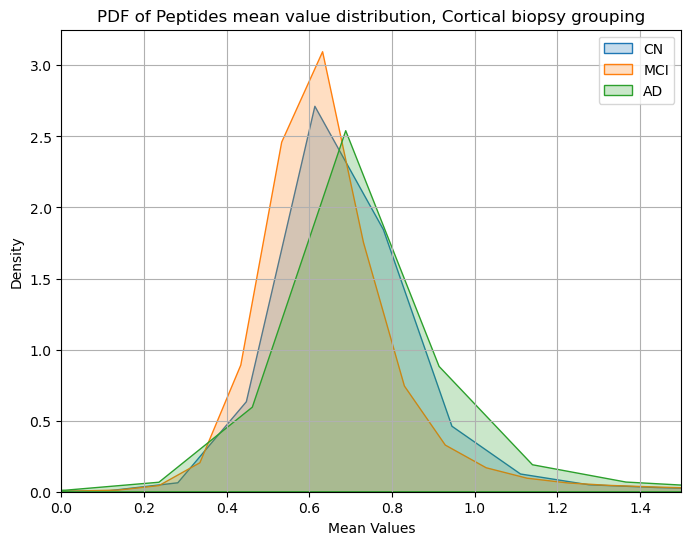

In [21]:
#Peptide Lumbar, Cortical Biopsy Grouping
plot_mean_values_pdf(df_peptides[df_peptides_all['Cortical_biopsy_grouping'] == 0], 
                     df_peptides[df_peptides_all['Cortical_biopsy_grouping'] == 1], 
                     df_peptides[df_peptides_all['Cortical_biopsy_grouping'] == 2], 
                     legend=['CN', 'MCI', 'AD'], title='PDF of Peptides mean value distribution, Cortical biopsy grouping', xlim=(0,1.5))

There seems to be some minor difference between the mean values between the cortical biopsy groupings as well. However, these differences can most likely be explained by the small dataset, as there are only 23 samples for AD, which is the slight outlier here.

## Missingness

### Proteins & Peptides

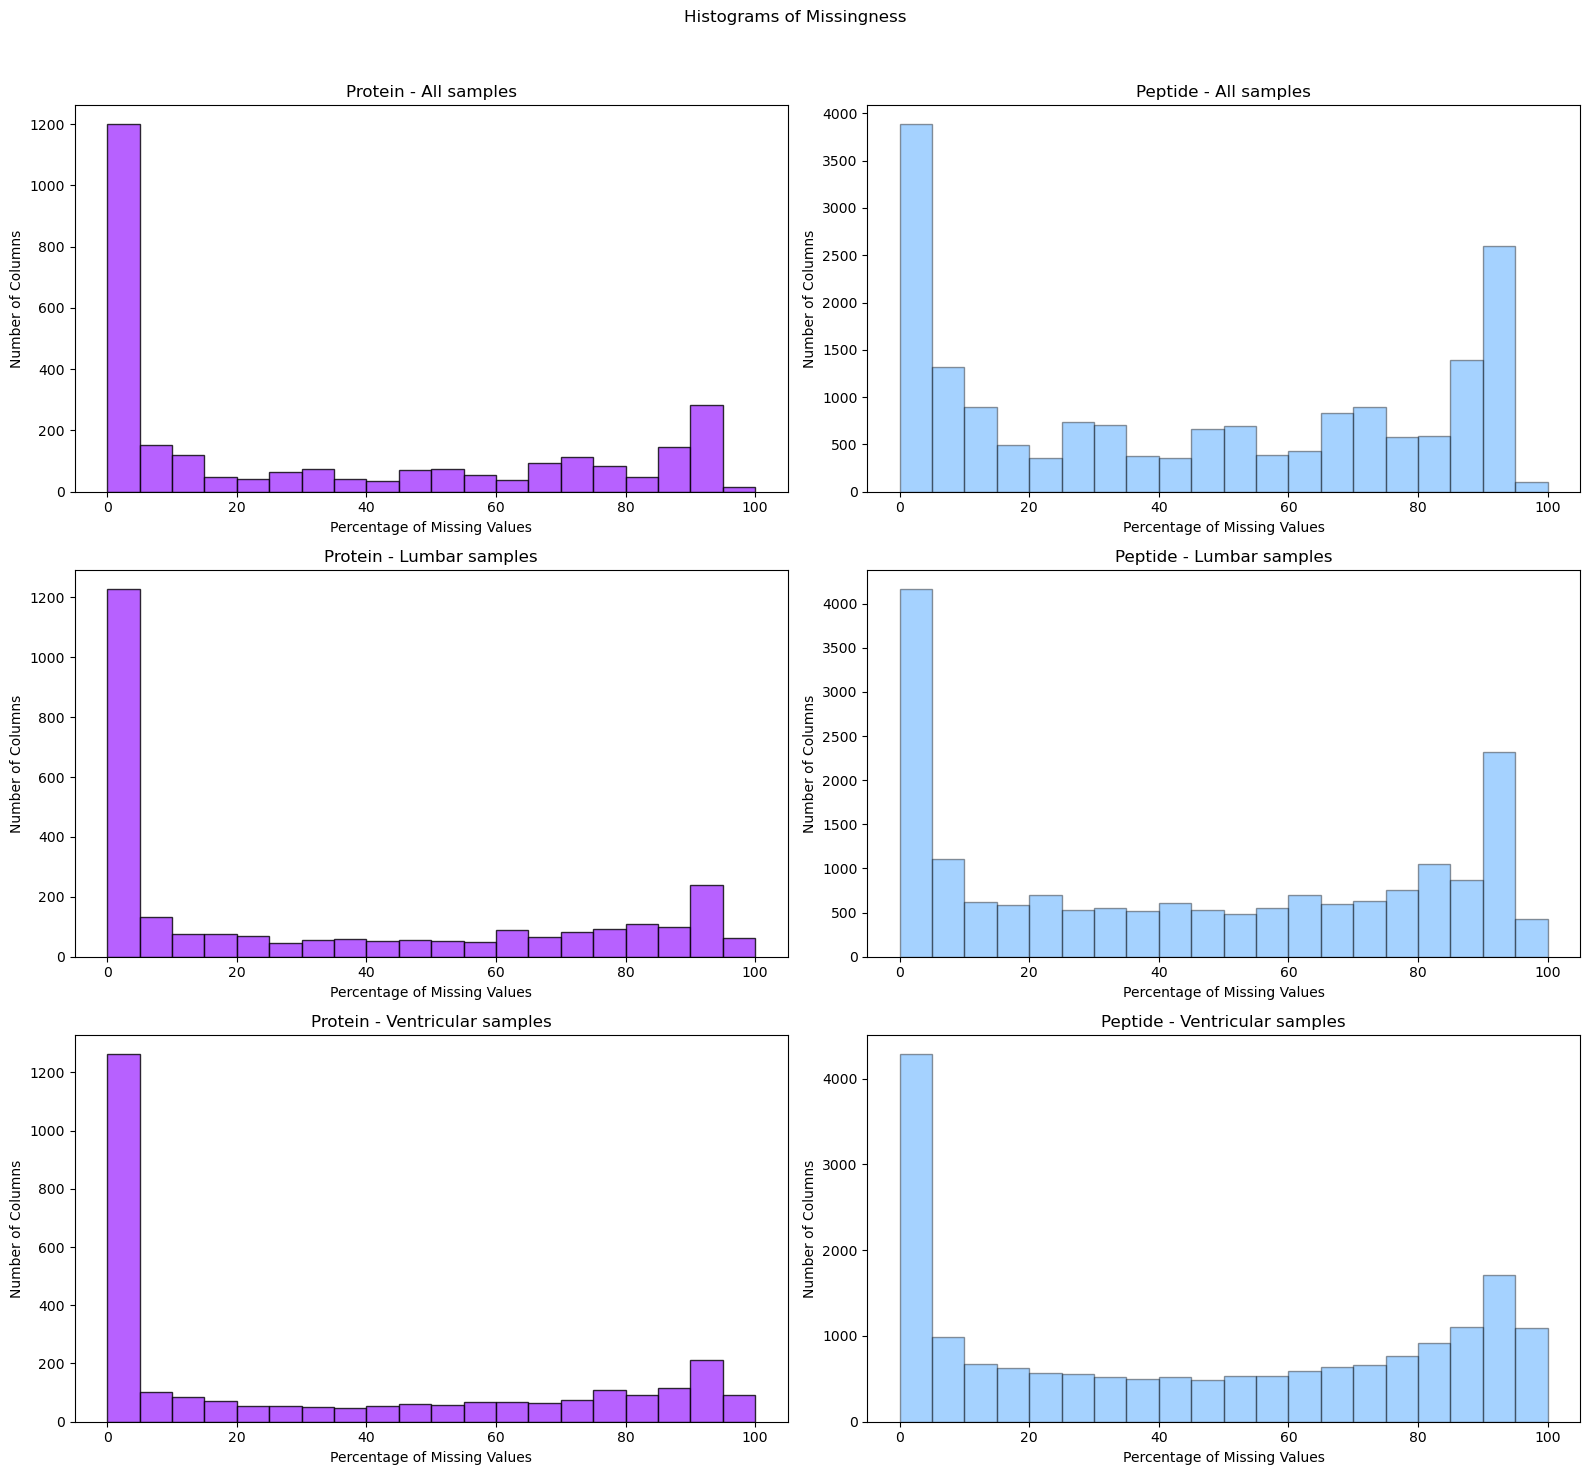

In [24]:
#Missingness histograms of all samples, lumbar and ventricular.
sample_types = [('All samples', df_proteins, df_peptides),
                ('Lumbar samples', df_proteins_lumbar, df_peptides_lumbar),
                ('Ventricular samples', df_proteins_ventricular, df_peptides_ventricular)]

fig, axes = plt.subplots(len(sample_types), 2, figsize=(16, 5 * len(sample_types)))
fig.suptitle('Histograms of Missingness')

for i, (sample_type, protein_data, peptide_data) in enumerate(sample_types):
    missingness_protein = (protein_data.isna().mean() * 100).round(2)
    missingness_peptide = (peptide_data.isna().mean() * 100).round(2)

    axes[i, 0].hist(missingness_protein, bins=np.arange(0, 101, 5), color='#a539ff', edgecolor='black', alpha=0.8)
    axes[i, 0].set_title(f'Protein - {sample_type}')
    axes[i, 0].set(xlabel='Percentage of Missing Values', ylabel='Number of Columns')

    axes[i, 1].hist(missingness_peptide, bins=np.arange(0, 101, 5), color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[i, 1].set_title(f'Peptide - {sample_type}')
    axes[i, 1].set(xlabel='Percentage of Missing Values', ylabel='Number of Columns')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Overall, the peptide missingness is higher compared to the protein missingness. This is most likely due to each protein consisting of multiple peptides, so not only is the peptide dataset larger, the qualifications for finding a protein is easier than finding five peptides. This missingness seems to be consistent in both lumbar and ventricular samples. There are 2795 proteins and 18305 peptides, meaning there are roughly 6.5 peptides per protein in the datasets. However, there are some proteins with only 1 corresponding peptide, and others with 20 or more.

### Feature Missingness

In [23]:
#Getting missingness based on columns into dictionary.
cols = ["Sample_Run_ID", "TMT Set", "TMT Pos", "CSF_type", "Cortical_biopsy_grouping", "Gender", "Age_at_biopsy"]
sample = ["All samples", "Lumbar", "Ventricular"]

dict_missingness = {}
for col in cols:
    dict_missingness[f'{col}_Protein'] = get_missingness_based_on_column(df_proteins_all, col)
    dict_missingness[f'{col}_Peptide'] = get_missingness_based_on_column(df_peptides_all, col)
    dict_missingness[f'{col}_Protein_Lumbar'] = get_missingness_based_on_column(df_proteins_all_lumbar, col)
    dict_missingness[f'{col}_Peptide_Lumbar'] = get_missingness_based_on_column(df_peptides_all_lumbar, col)
    dict_missingness[f'{col}_Protein_Ventricular'] = get_missingness_based_on_column(df_proteins_all_ventricular, col)
    dict_missingness[f'{col}_Peptide_Ventricular'] = get_missingness_based_on_column(df_peptides_all_ventricular, col)

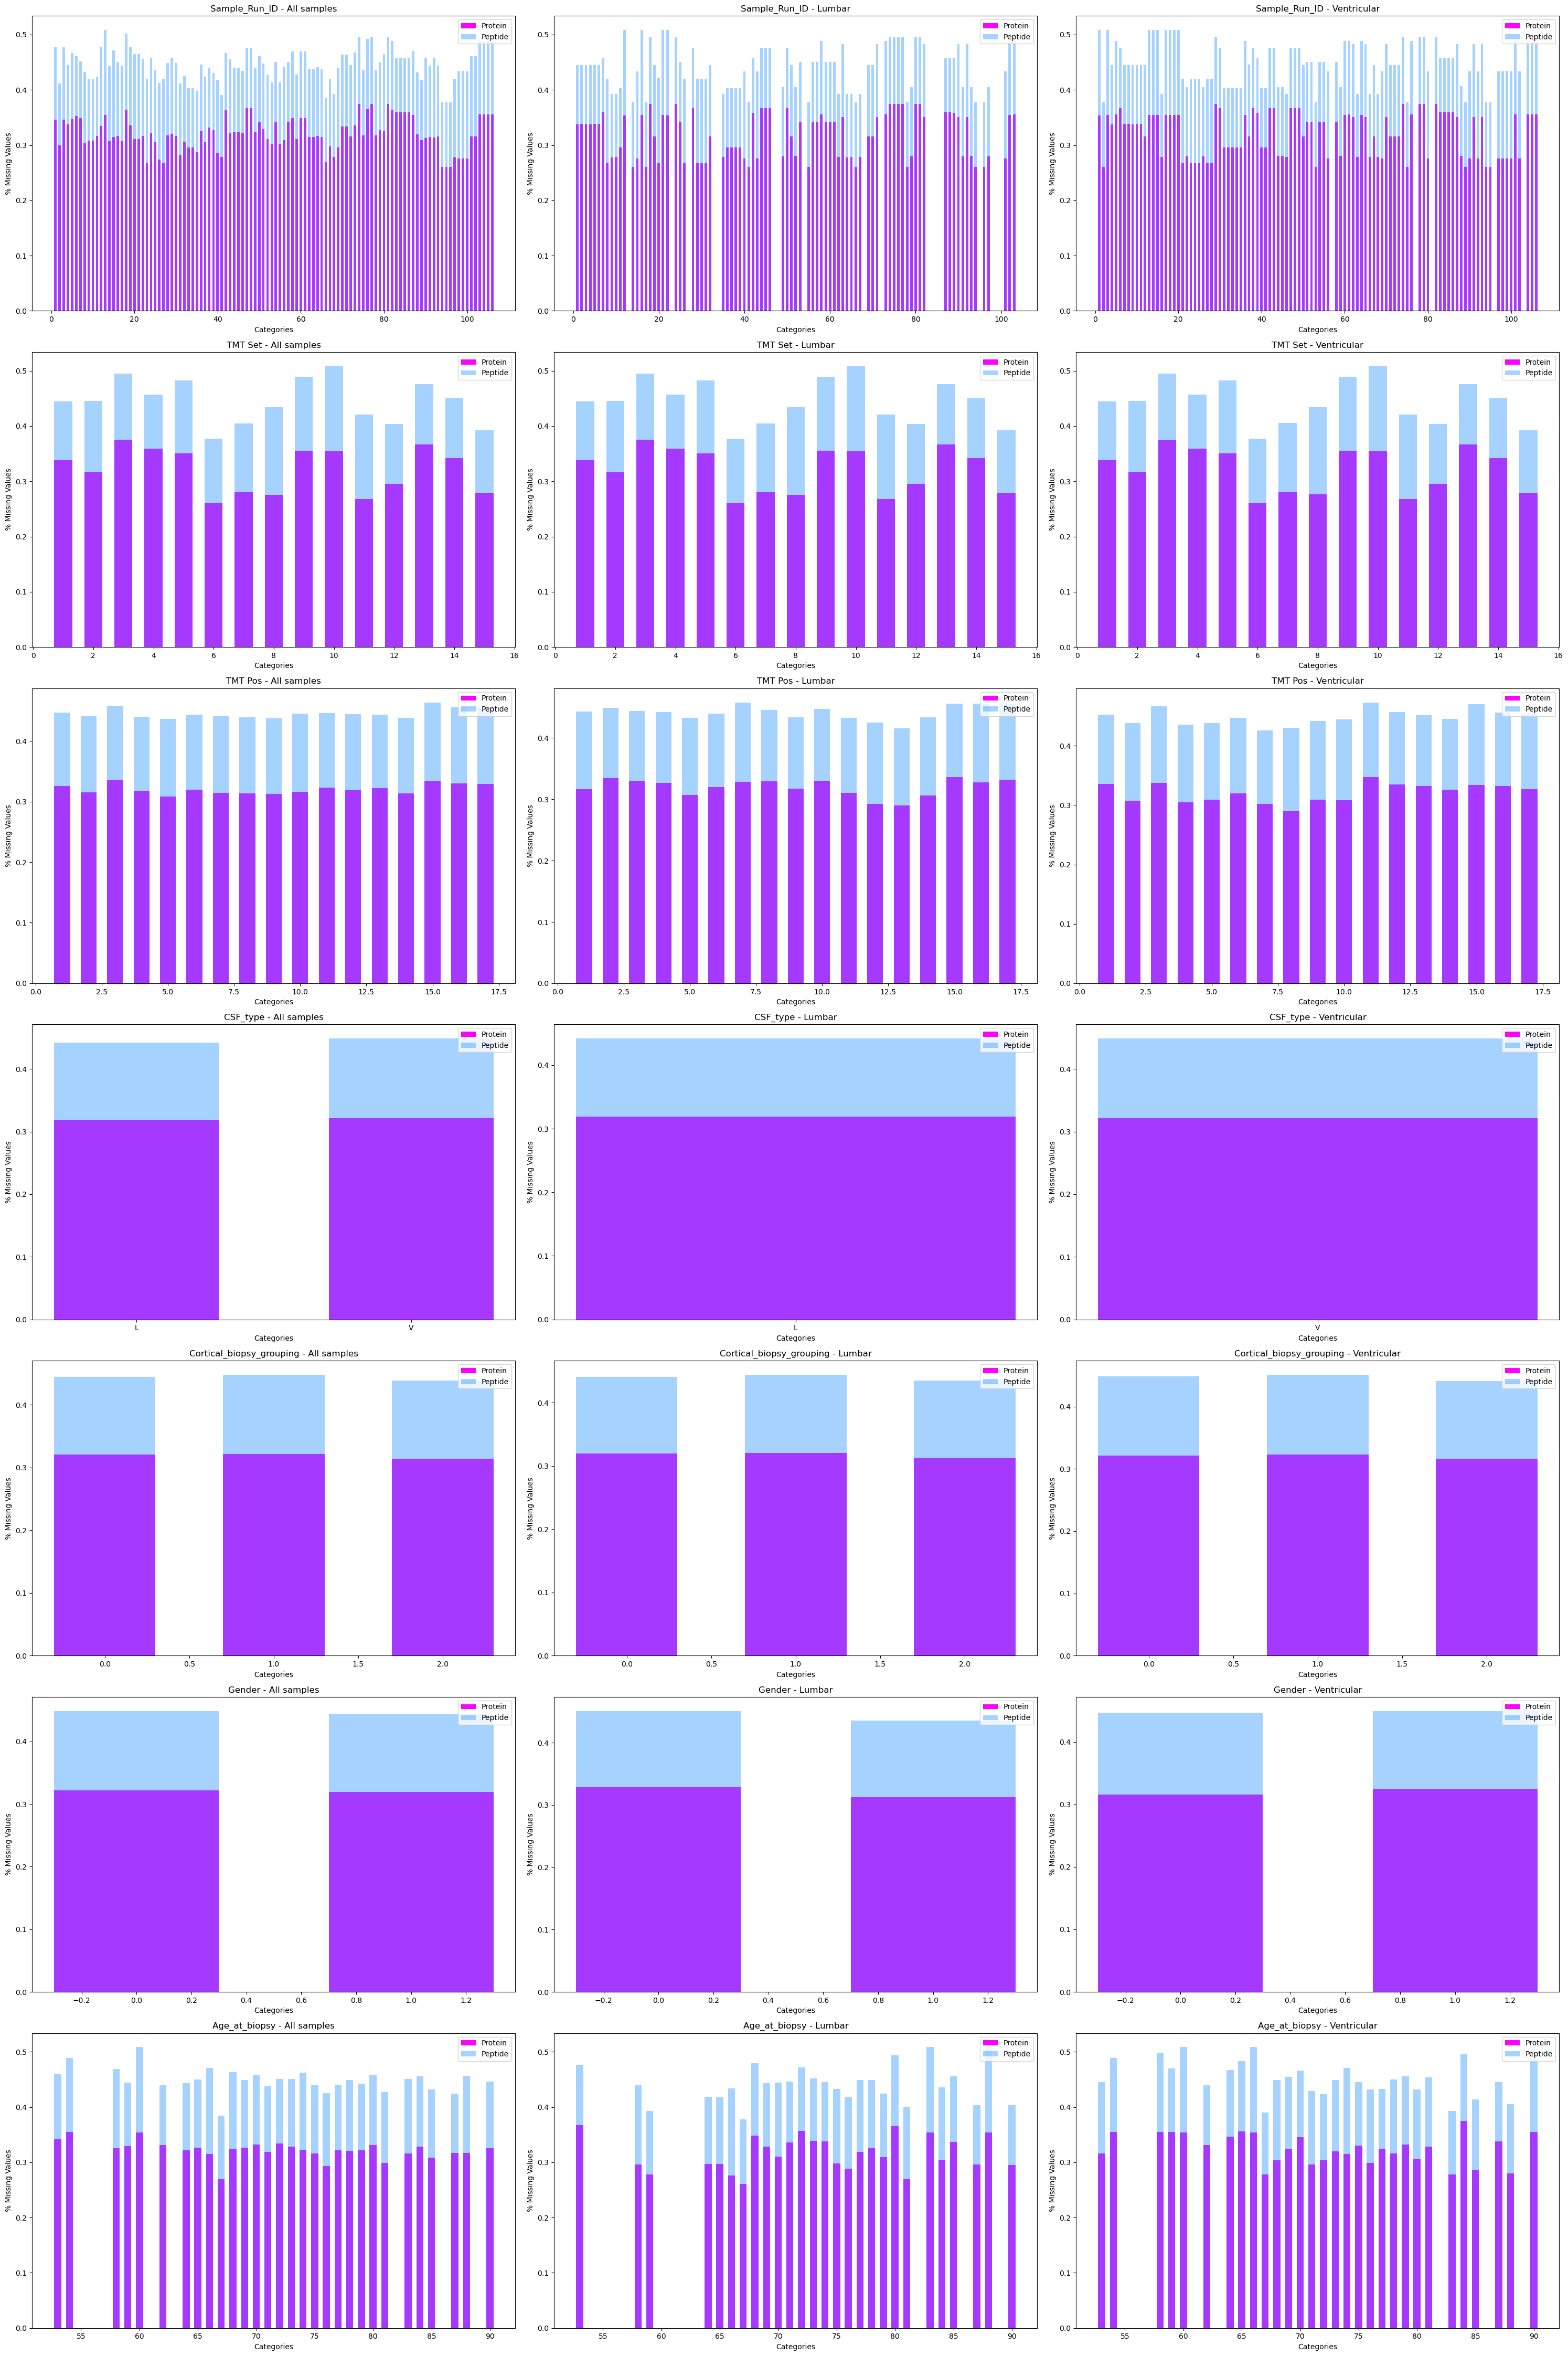

In [24]:
#--- PLOTTING BARCHARTS BASED ON MISSINGNESS ---#
fig, axes = plt.subplots(7, 3, figsize=(30, 45))

for i in range(7):
    for j in range(3):
        dataset_name1, data1 = list(dict_missingness.items())[((i * 6) + (j * 2))]
        dataset_name2, data2 = list(dict_missingness.items())[((i * 6) + (j * 2) + 1)]
        values1 = list(data1.values())
        values2 = list(data2.values())

        categories = list(data1.keys())
        width = 0.6 

        axes[i, j].bar(categories, values1, width, color='magenta', label='Protein')
        axes[i, j].bar(categories, values2, width, color='dodgerblue', label='Peptide', alpha=0.4)

        axes[i, j].set_title(cols[i] + " - " + sample[j])
        axes[i, j].set_xlabel('Categories')
        axes[i, j].set_ylabel('% Missing Values')
        axes[i, j].legend(loc='upper right')

plt.tight_layout()
plt.show()

Overall, the missingness based on sample type (lumbar or ventricular) or structure type (protein or peptide) does not seem to have any particular correlation. Most of this missingness seems to be similar the groups, with peptide continuously having more missingness than proteins.  TMT Set seems to be the category that influenced the missingness the most.

### TMT Set in-batch Missingness

In [48]:
#--- MISSINGNESS INSIDE TMT SETS ---#
tmt_sets_pep = {}
tmt_sets_cleaned_pep = {}
tmt_sets_pro = {}
tmt_sets_cleaned_pro = {}
print(f'TMT Set\t\tColumns\t\tPep NaN in-set\tPeptide Total\tN Samples\t\tPro NaN in-set\tProtein Total\tN Samples')
for i in range(15):
    tmt_sets_pep[i+1] = df_peptides[df_peptides_all['TMT Set'] == (i+1)]
    tmt_sets_cleaned_pep[i+1] = set_max_missingness_per_column(tmt_sets_pep[i+1], 0.99)
    tmt_sets_pro[i+1] = df_proteins[df_proteins_all['TMT Set'] == (i+1)]
    tmt_sets_cleaned_pro[i+1] = set_max_missingness_per_column(tmt_sets_pro[i+1], 0.99)
    print(f'{i+1}: \t\t{len(tmt_sets_cleaned_pep[i+1])}\t\t{tmt_sets_cleaned_pep[i+1].isna().sum().sum()} \t\t{tmt_sets_pep[i+1].isna().sum().sum()}\t\t{len(tmt_sets_cleaned_pep[i+1].columns)}\t\t\t{tmt_sets_cleaned_pro[i+1].isna().sum().sum()} \t\t{tmt_sets_pro[i+1].isna().sum().sum()}\t\t{len(tmt_sets_cleaned_pro[i+1].columns)}')
print(f'All\t\t{len(df_peptides_all)}\t\tX\t\tX\t\t{len(df_peptides_all.columns)}\t\t\tX\t\tX\t\t{len(df_proteins_all.columns)}')

TMT Set		Columns		Pep NaN in-set	Peptide Total	N Samples		Pro NaN in-set	Protein Total	N Samples
1: 		12		1 		97801		10155			0 		11376		1847
2: 		12		2 		97874		10149			0 		10632		1909
3: 		13		0 		117858		9239			0 		13663		1744
4: 		10		2 		83762		9929			0 		10070		1788
5: 		11		0 		97262		9463			0 		10824		1811
6: 		14		0 		96740		11395			0 		10220		2065
7: 		12		31 		89035		10888			0 		9420		2010
8: 		14		4 		111248		10359			0 		10836		2021
9: 		14		0 		125370		9350			0 		13944		1799
10: 		13		0 		121043		8994			0 		12909		1802
11: 		12		6 		92394		10606			0 		9000		2045
12: 		12		3 		88683		10915			0 		9948		1966
13: 		13		7 		113341		9587			0 		13377		1766
14: 		12		4 		98980		10057			0 		11520		1835
15: 		12		7 		86287		11115			0 		9360		2015
All		186		X		X		18316			X		X		2806


A major take away from this is that almost all missingness in the dataset comes from adding the different batches on eachother. There are 0 protein value missingness, and less than 100 across ALL batches combined. However, when looking at missingness across the batches, it skyrockets, due to proteins/peptides found in one batch not being present in the others.

### Lumbar & Ventricular, Missingness Difference

In [26]:
def find_missingness_difference_between_sample(df):
    """Find features that differ between two of the columns with more than a certain difference.

    :param df: DataFrame.

    :return: DataFrame showing features that only exists based on another feature."""
    missingness_by_CSF_type = df.groupby('CSF_type').apply(lambda x: x.isnull().mean())
    mask_L = (missingness_by_CSF_type.loc['L'] == 1.0) & (missingness_by_CSF_type.loc['V'] != 1.0)
    mask_V = (missingness_by_CSF_type.loc['L'] != 1.0) & (missingness_by_CSF_type.loc['V'] == 1.0)

    print(f'Missing lumbar features: \n{missingness_by_CSF_type.columns[mask_L]} \n\nMissing ventricular features: \n{missingness_by_CSF_type.columns[mask_V]}')

In [27]:
find_missingness_difference_between_sample(df_peptides_median_all)

Missing lumbar features: 
Index(['Q9NRB3..342.360.', 'P01019..57.75.', 'P02751..1252.1286.',
       'Q14624..339.371.'],
      dtype='object') 

Missing ventricular features: 
Index(['Q9UHL4..124.143.', 'Q9ULL4..145.183.', 'Q14393..551.568.',
       'Q9UM47..1211.1220.', 'O60512..296.303.', 'Q92673..1491.1501.',
       'P06396..246.252.'],
      dtype='object')


The above code returns the features that have a 100% missingness in either Lumbar or Ventricular, but not in the other. The "Missing lumbar features" means that those peptides only have NaN values for all lumbar samples. (Note: most of these seem to appear due to a random 100+ value appearing in one or a few samples.)

In [28]:
#--- CREATING DATAFRAME BASED ON TMT SET MISSINGNESS DATA ON PROTEIN/PEPTIDE LEVEL ---#
def get_tmt_missingness_data(df_protein, df_peptide):
    """Get DataFrame with TMT based missingness data from protein and peptide dataset.

    :param df_protein: Protein dataframe.
    :param df_peptide: Peptide dataframe.

    :return: DataFrame with TMT based missingness data."""
    missing_values_per_row_pro = df_protein.iloc[:, 11:].isnull().sum(axis=1)
    missing_values_per_row_pep = df_peptide.iloc[:, 11:].isnull().sum(axis=1)

    new_df_pro = pd.DataFrame({
        'Sample_Run_ID': df_protein['Sample_Run_ID'],
        'TMT Set': df_protein['TMT Set'],
    })

    new_df_pep = pd.DataFrame({
        'missing_per_row_peptide': missing_values_per_row_pep
    })

    missing_values_df = pd.merge(new_df_pep, new_df_pro, left_index=True, right_index=True)
    missing_values_df['dif'] = (missing_values_per_row_pro / len(df_protein.iloc[0])) / (missing_values_per_row_pep / len(df_peptide.iloc[0]))
    missing_values_df = missing_values_df.sort_values("TMT Set")
    c_order = ['Sample_Run_ID', 'TMT Set', 'missing_per_row_peptide', 'dif']
    missing_values_df = missing_values_df[c_order]

    grouped_df = missing_values_df.groupby('TMT Set').agg({
        'Sample_Run_ID': list,
        'dif': 'mean',
        'missing_per_row_peptide': ['min', 'max']
    }).reset_index()

    grouped_df['inconsistent_columns_peptide'] = grouped_df['TMT Set'].apply(lambda tmt_set: find_inconsistent_columns(df_peptide[df_peptide['TMT Set'] == tmt_set].iloc[:, 11:]))
    grouped_df['n_inconsistent_peptide'] = grouped_df['inconsistent_columns_peptide'].apply(len)


    grouped_df.columns = ['_'.join(col).strip('_') for col in grouped_df.columns.values]

    return grouped_df


def find_inconsistent_columns(df):
    """Find columns where not all values are of the same type, considering NaN as a separate type.

    :param df: DataFrame.
    
    :return: List of column names where values are inconsistent in type."""
    inconsistent_columns = []

    for column in df.columns:
        column_values = df[column]
        unique_types = set(type(value) if not pd.isna(value) else np.nan for value in column_values)

        if len(unique_types) > 1:
            inconsistent_columns.append(column)

    return inconsistent_columns


In [29]:
tmt_data_df = get_tmt_missingness_data(df_proteins_all, df_peptides_all)
tmt_data_df

TMT Set                                 Sample_Run_ID_list  dif_mean  \
0         1             [1, 4, 10, 9, 8, 7, 11, 5, 4, 3, 2, 6]  0.759258   
1         2   [32, 73, 72, 12, 71, 51, 70, 37, 19, 50, 69, 67]  0.709072   
2         3  [74, 80, 79, 24, 29, 78, 18, 77, 76, 75, 74, 8...  0.756711   
3         4            [83, 84, 85, 42, 86, 39, 87, 88, 7, 89]  0.784739   
4         5       [91, 70, 87, 93, 63, 92, 90, 82, 65, 62, 71]  0.726420   
5         6  [94, 89, 78, 94, 53, 17, 14, 66, 95, 75, 41, 9...  0.689585   
6         7   [49, 91, 59, 44, 26, 45, 22, 79, 93, 88, 52, 97]  0.690611   
7         8  [101, 80, 99, 56, 102, 40, 43, 15, 100, 92, 69...  0.635799   
8         9  [101, 64, 5, 60, 105, 73, 61, 58, 103, 102, 10...  0.726000   
9        10  [12, 21, 20, 3, 19, 18, 22, 16, 15, 14, 13, 17...  0.696139   
10       11    [31, 30, 29, 8, 20, 28, 27, 26, 25, 24, 23, 21]  0.635831   
11       12   [38, 41, 40, 39, 37, 33, 31, 36, 35, 34, 32, 11]  0.732215   
12       13  [42, 38, 28, 43, 44, 47, 46, 45, 50, 30, 48, 4...  0.770397   
13       14   [61, 60, 59, 58, 25, 56, 55, 54, 53, 52, 51, 57]  0.759710   
14       15    [68, 67, 66, 16, 65, 46, 9, 64, 63, 62, 10, 35]  0.708066   

    missing_per_row_peptide_min  missing_per_row_peptide_max  \
0                          8150                         8151   
1                          8156                         8158   
2                          9066                         9066   
3                          8376                         8378   
4                          8842                         8842   
5                          6910                         6910   
6                          7417                         7445   
7                          7946                         7949   
8                          8955                         8955   
9                          9311                         9311   
10                         7699                         7704   
11                         7390                         7393   
12                         8718                         8722   
13                         8248                         8250   
14                         7190                         7197   

                         inconsistent_columns_peptide  n_inconsistent_peptide  
0   [O76013..173.179...P02533..195.201...P08727..1...                       1  
1                [P60201..219.229., P60201..128.137.]                       2  
2                                                  []                       0  
3   [P04264..268.277...P04259..251.260...P02538..2...                       2  
4                                                  []                       0  
5                                                  []                       0  
6   [P02533..31.41...P08779..31.41., P13647..74.84...                      31  
7   [P60201..46.53., P60201..128.137., P60201..99....                       3  
8                                                  []                       0  
9                                                  []                       0  
10  [P35527..192.199., P02533..408.416...P08727..3...                       6  
11  [P04264..417.432., P35527..225.233., P35908..3...                       3  
12  [P35908..342.353...P04259..327.338...P02538..3...                       6  
13  [P02768..118.138., P02768..222.233., P02787..6...                       3  
14  [P04259..427.436...P02538..427.436., P08779..2...                       7

(In the above graph, high dif_mean means that, comparatively, either more peptides were found or less proteins were found. The difference of dif_mean between the sets means that the ratio of found peptides / proteins differ.)

This is missingness data based on the grouping of the TMT Sets. This is a basic and overarching way of looking at the batch effect. It seems that in each TMT Set, the number of proteins discored seems to be differing by 1 value between the individuals in the set, while in the peptide set, this value is between 4 and 18. Further, there seems to be a big difference in the protein vs peptide missingness in each TMT Set. On average, the proteins have a missingness of 72% of that of the peptides in each TMT Set, but this value goes as low as 63% and as high as 78%. Following this, some TMT Sets have a lot more missingness compared to others. All of this seems to suggest that a "good TMT Set" does not necessarily result in good results for both proteins and peptides.

Furthermore, there are times where not all samples in a TMT Set receive values in all peptides (for proteins, this case always holds true). This goes against our idea of TMT and Mass Spectrometry, where all samples in a batch should get a value for each protein/peptide. However, this shows that between 3 and 55 peptides get "not all values" or "not all NaN". We propose a Batch sampling method for this.

(AS BEFORE 26/01/2024):
We noticed that some values in the peptide dataset had values in the 50's to 200's, something that seems to be way out of the norm, and is probably due to some form of error.
These values seems to correlate (after sampling a few of them) with the Inf values found early on in the protein dataset.
They also seem to only appear in TMT Set columns with both NaN values and float values, something that we though should not be possible.
Suggestions on how to fix this (any values over XX is converted to NaN, if there are NaN values in a column in a TMT Set, ALL values in the TMT sets column should be turned to NaN values) have been discussed.


### Individual Proteins and Peptides Missingness

In [22]:
def plot_columns_with_highest_missing_ratio(dataframe, title_desc, n=5, plot_y_ticks = False):
    """Plot n columns with the highest ratio of missing values in the given DataFrame.

    :param dataframe: The input DataFrame.
    :param title_desc: Name of the plot.
    :param n: Number of features to show.
    :param plot_y_ticks Boolean for showing or removing y-ticks."""
    missing_ratios = dataframe.isnull().mean()
    sorted_columns = missing_ratios.sort_values(ascending=False).index[:n]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_ratios[sorted_columns], y=sorted_columns, color='skyblue')
    if not plot_y_ticks:
        plt.yticks([])
    plt.title(f'Missingness of peptides in lumbar CSF samples.')
    plt.xlabel('Missing Value Ratio')
    plt.ylabel('Peptides')
    plt.show()

#### Individual Proteins Missingness

##### Protein Lumbar Samples

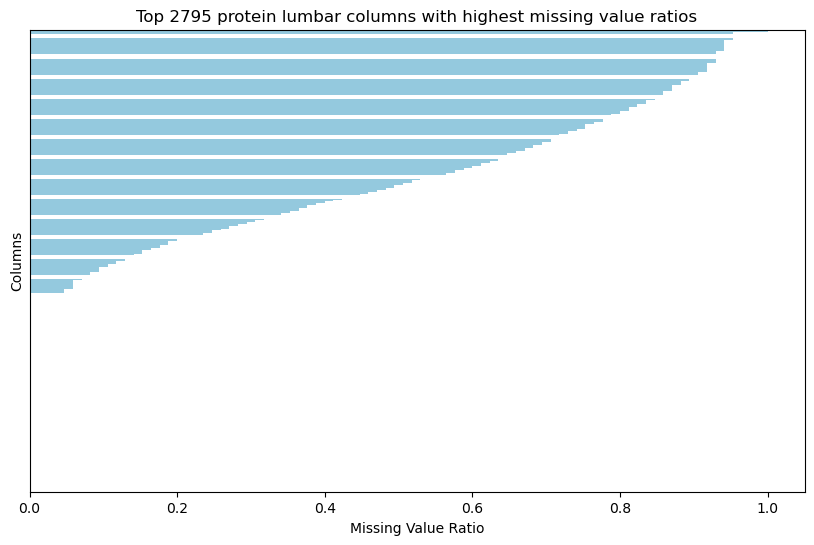

In [19]:
#Missingness of individual proteins in the dataset from lumbar samples. Proteins higher up have more missingness.
plot_columns_with_highest_missing_ratio(df_proteins_lumbar, "protein lumbar", df_proteins_lumbar.shape[1])

This plot shows the missingness of the different proteins in the lumbar samples dataset, sorted by missingnes value ration.

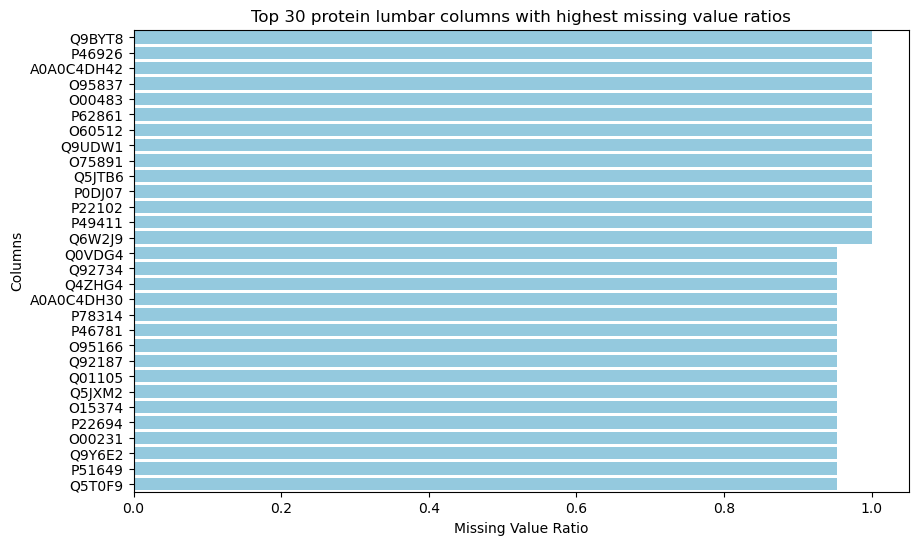

In [32]:
#Missingness of individual proteins in the dataset from lumbar samples. Top 30 samples with protein names.
plot_columns_with_highest_missing_ratio(df_proteins_lumbar, "protein lumbar", 30, True)

Here we can see proteins with full and very high (top 30) missingness from the lumbar samples dataset. 

IDEA
* Q9BYT8 for example, only has one peptide, all with NaN values. The protein also only has NaN values. Why does it exist in the dataset?

##### Protein Ventricular Samples

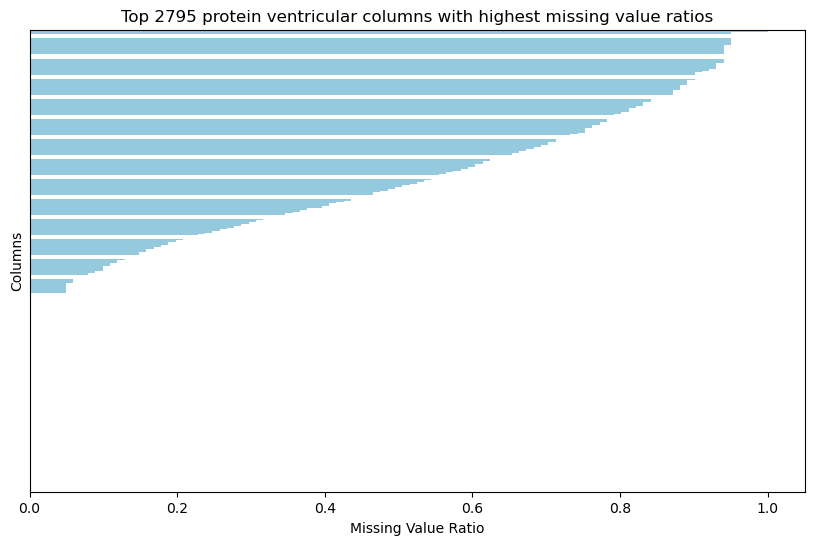

In [33]:
#Missingness of individual proteins in the dataset from ventricular samples. Proteins higher up have more missingness.
plot_columns_with_highest_missing_ratio(df_proteins_ventricular, "protein ventricular", df_proteins_ventricular.shape[1])

The missingness distribution looks similar between the lumbar and ventricular samples.

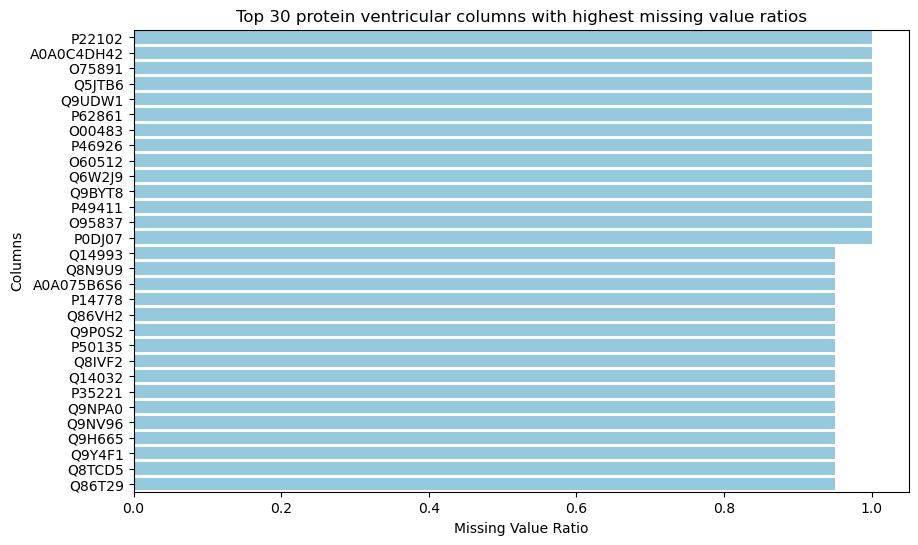

In [34]:
#Missingness of individual proteins in the dataset from ventricular samples. Top 30 samples with protein names.
plot_columns_with_highest_missing_ratio(df_proteins_ventricular, "protein ventricular", 30, True)

It also looks like the proteins with 100% missingness are the same between lumbar and ventricular samples, as they also have 100% missingness in the full dataset.

#### Individual Peptides Missingness

##### Peptide Lumbar Samples

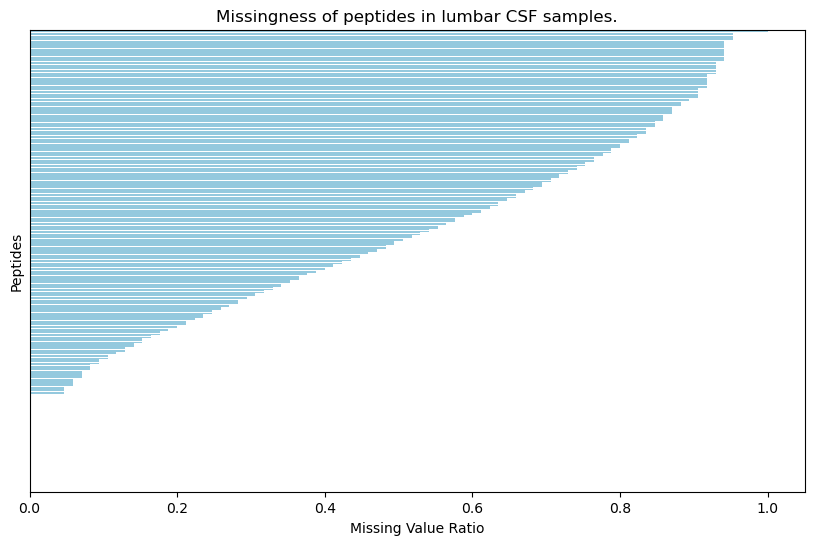

In [23]:
#Missingness of individual peptides in the dataset from lumbar samples. Peptides higher up have more missingness.
plot_columns_with_highest_missing_ratio(df_peptides_lumbar, "peptide lumbar", df_peptides_lumbar.shape[1])

This plot shows the missingness of peptides in the lumbar samples. There is a higher missingness compared to proteins, both at the lower end and the higher end, which is expected.

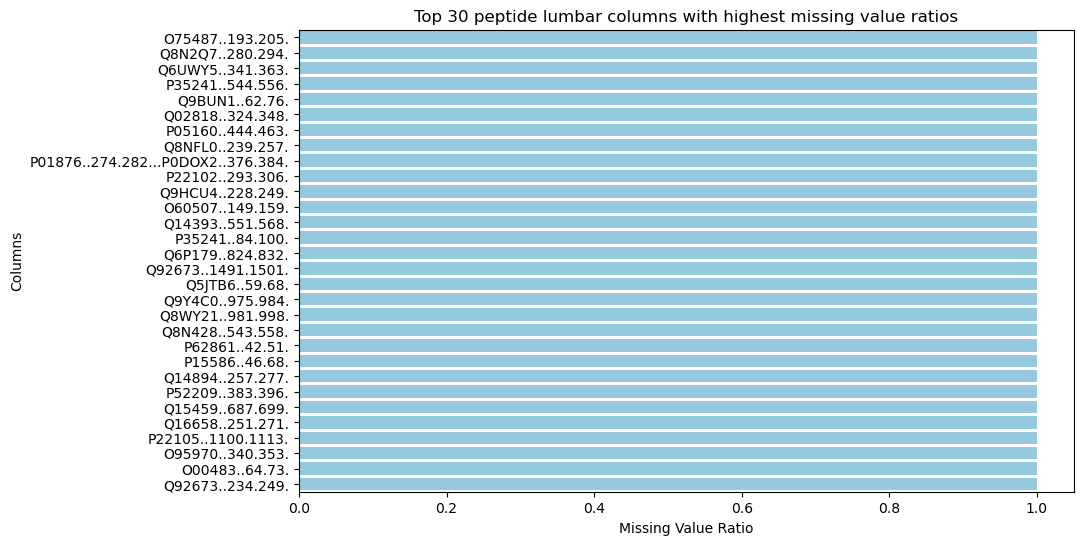

In [36]:
#Missingness of individual peptides in the dataset from ventricular samples. Top 30 samples with peptides names.
plot_columns_with_highest_missing_ratio(df_peptides_lumbar, "peptide lumbar", 30, True)

There are more than 30 100% missing peptides in the lumbar dataset, i.e. without any values.

##### Peptide Ventricular Samples

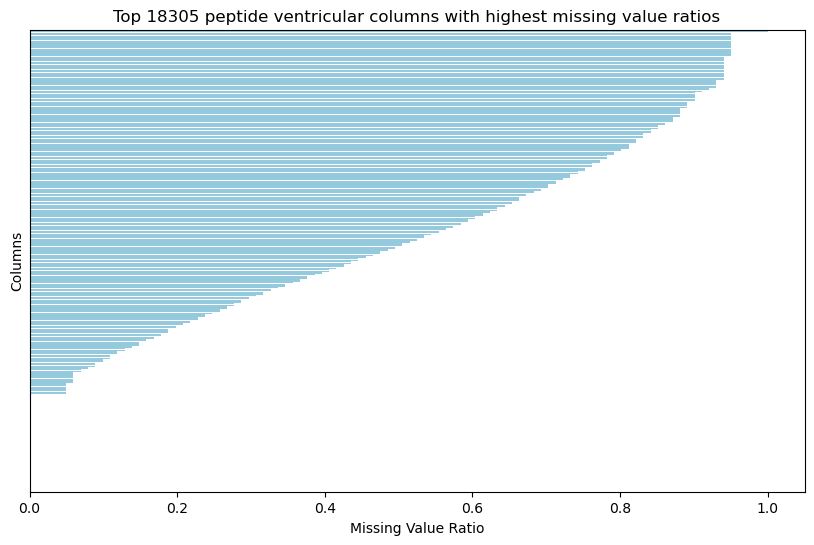

In [37]:
#Missingness of individual peptides in the dataset from ventricular samples. Peptides higher up have more missingness.
plot_columns_with_highest_missing_ratio(df_peptides_ventricular, "peptide ventricular", df_peptides_ventricular.shape[1])

The ventricular peptide missingness looks similar to that of the lumbar one.

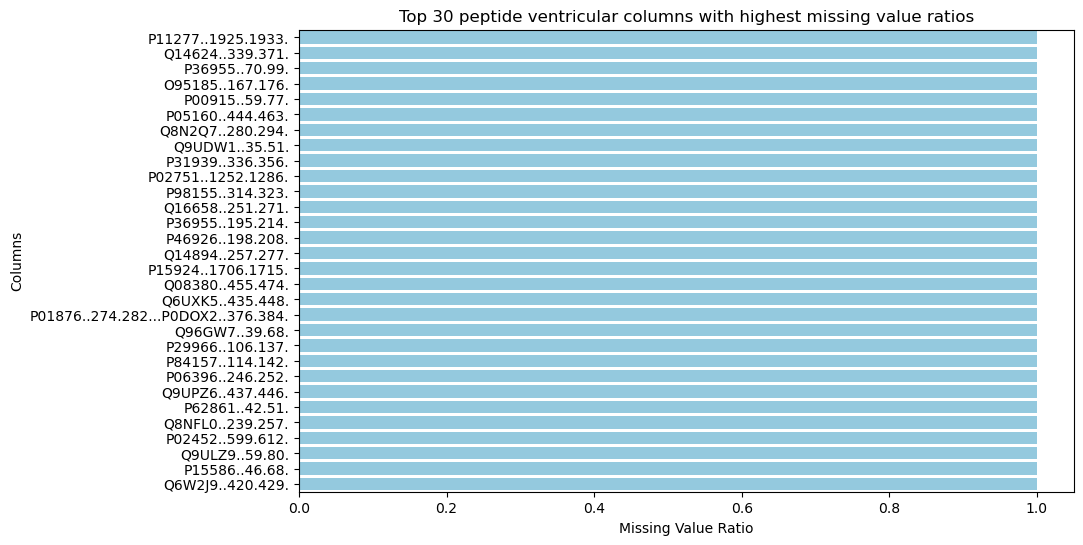

In [38]:
#Missingness of individual peptides in the dataset from ventricular samples. Top 30 samples with peptides names.
plot_columns_with_highest_missing_ratio(df_peptides_ventricular, "peptide ventricular", 30, True)

As with the lumbar missingness, over 30 peptides are missing.

## Dimensionality Reduction

### Code

In [39]:
def do_scree_plot_data(pca):
    """Gets Scree Plot Data from a PCA.

    :param pca: PCA already fit and processed.
    
    :return: PCA Scree Plot Data.""" 
    pca_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
    pca_labels = ['PC' + str(x) for x in range(1, len(pca_var)+1)]
    return (pca_var, pca_labels)

In [40]:
def do_PCA_on_DF(df, n_components=10):
    """Does PCA on a DF.

    :param df: Dataframe-base to perform PCA on.
    :param n_components: Number of PCA components to find.
    
    :return: PCA Scree Plot Data.""" 
    df_clean = set_max_missingness_per_column(df, 0)
    pca = PCA(n_components=n_components)
    pca.fit(df_clean)
    
    return pca

### PCA - (No Missingness)

#### Median

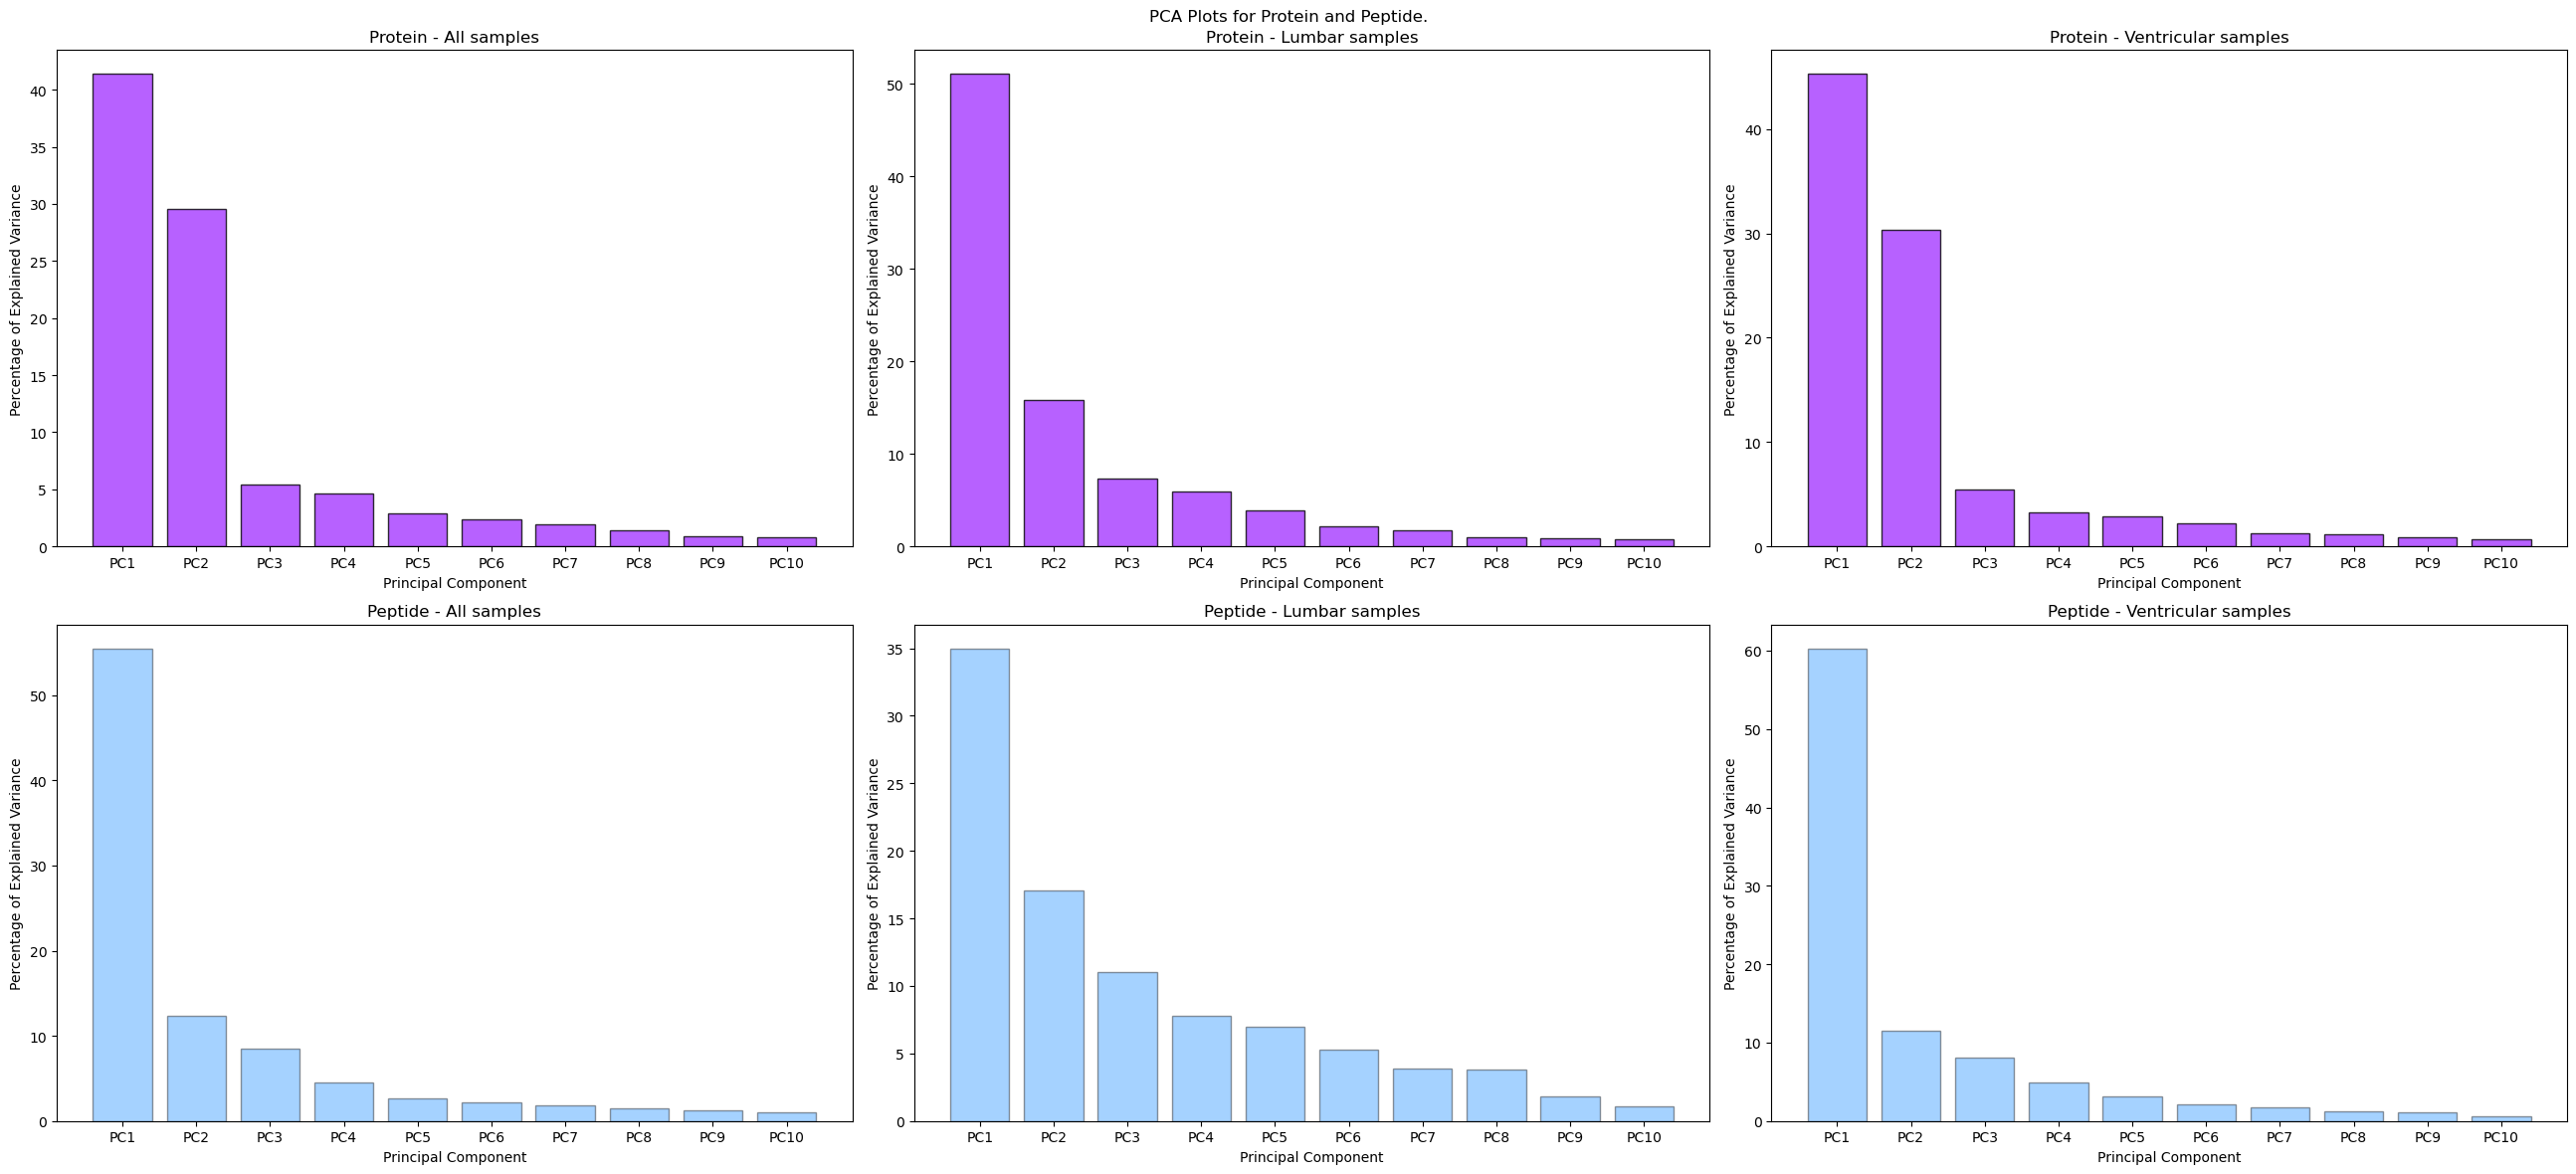

In [41]:
#--- RUNNING PCA CALCULATION AND PLOTTING - MEDIAN NORMALIZED---#
datasets_protein = [df_proteins_median, df_proteins_median_lumbar, df_proteins_median_ventricular]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [df_peptides_median, df_peptides_median_lumbar, df_peptides_median_ventricular]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_scree_plot_data(do_PCA_on_DF(dataset_protein))
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_scree_plot_data(do_PCA_on_DF(dataset_peptide))
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

The PCA graphs show that all samples and variations of some form of higher importance in PC1 (and in some cases PC2), which is expected. The goal is to have PC1 + PC2 be as high as possible, as that would make it better to plot in a 2 dimensions. For the both the proteins and the peptides, the ventricular samples seems to result in slightly better PCA plots.

#### Non Normalized

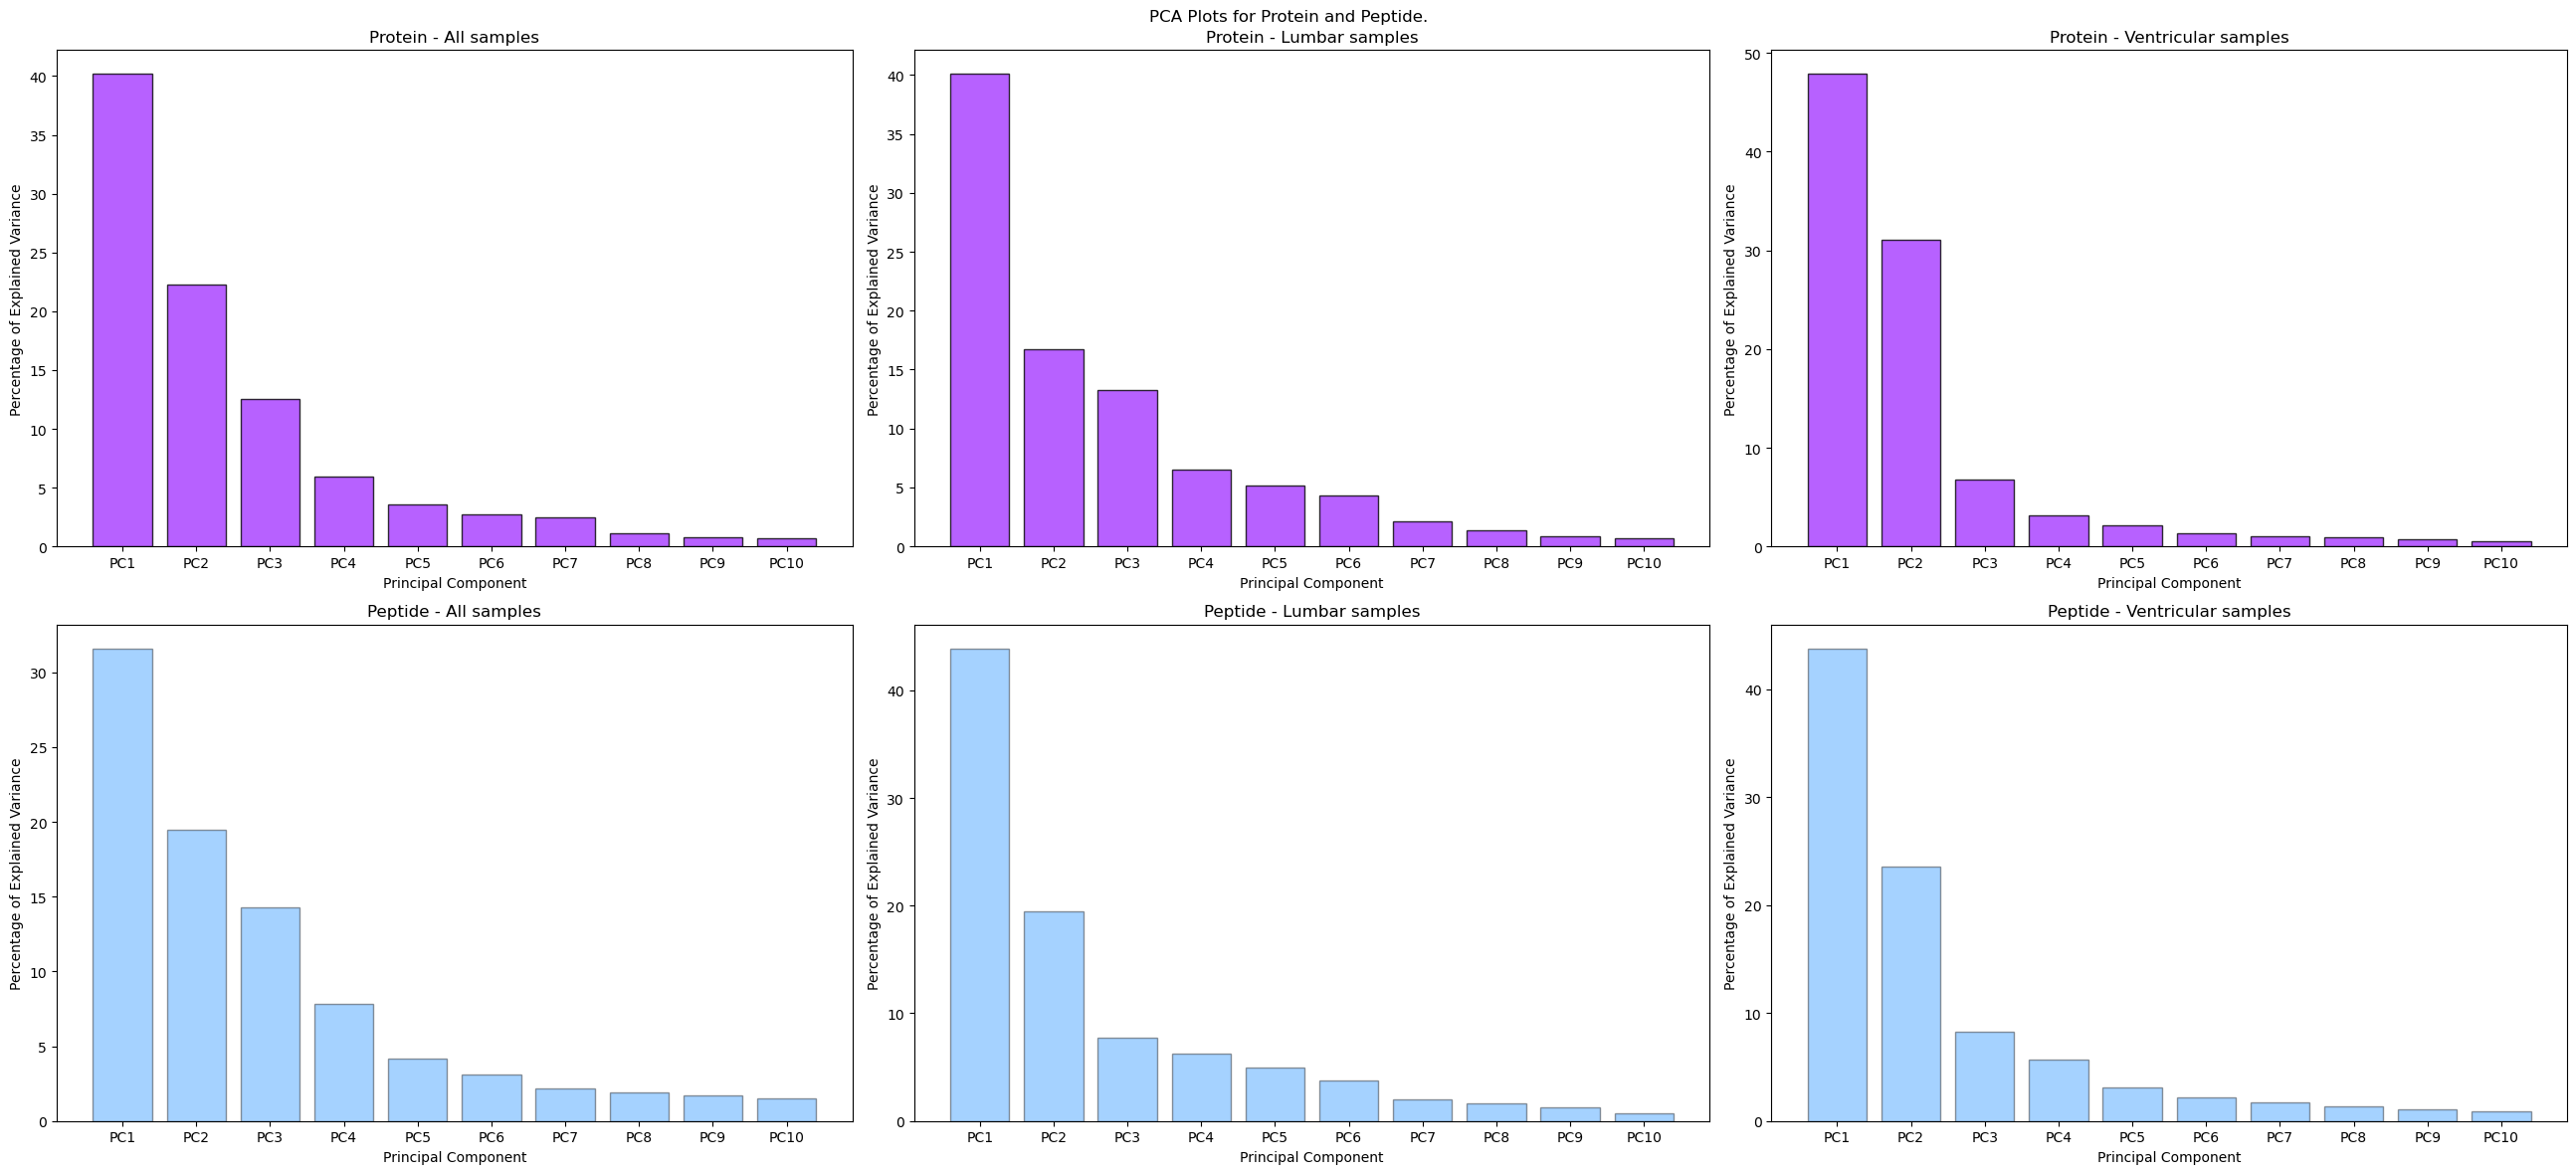

In [42]:
#--- RUNNING PCA CALCULATION AND PLOTTING - NON NORMALIZED---#
datasets_protein = [df_proteins, df_proteins_lumbar, df_proteins_ventricular]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [df_peptides, df_peptides_lumbar, df_peptides_ventricular]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_scree_plot_data(do_PCA_on_DF(dataset_protein))
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_scree_plot_data(do_PCA_on_DF(dataset_peptide))
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

Considering the good results on the PCA, especially for ventricular protein samples, we plot the pca data as a scatter plot. The results for peptides are not good enough to show any real correlation.

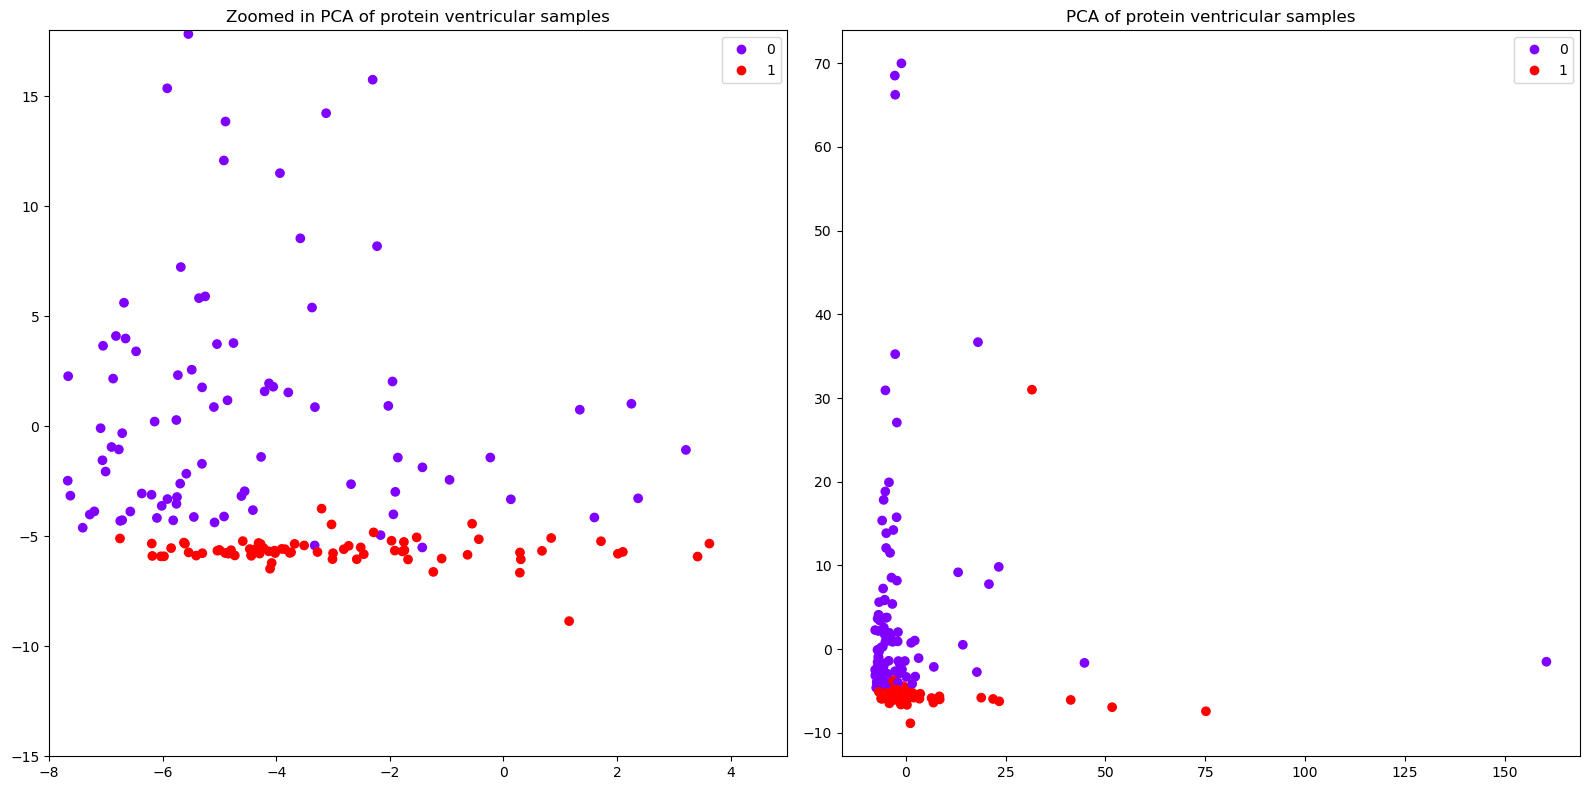

In [203]:
#--- PLOTTING PCA 2D PLOT FROM BEST Principal Component Table ---#
pca_median = do_PCA_on_DF(df_proteins)
pca_both = pca_median.fit_transform(set_max_missingness_per_column(df_proteins, 0))

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

df_proteins_all.replace({'V': 0, 'L': 1}, inplace=True)


axs[0].scatter(pca_both[:,0], pca_both[:,1], c=df_proteins_all["CSF_type"], cmap="rainbow")
handles_0, _ = axs[0].collections[0].legend_elements()
labels_0 = set(df_proteins_all["CSF_type"])
axs[0].legend(handles=handles_0, labels=labels_0)
axs[0].set_xlim(-8, 5)
axs[0].set_ylim(-15, 18)
axs[0].set_title('Zoomed in PCA of protein samples')

axs[1].scatter(pca_both[:,0], pca_both[:,1], c=df_proteins_all["CSF_type"], cmap="rainbow")
handles_1, _ = axs[1].collections[0].legend_elements()
labels_1 = set(df_proteins_all["CSF_type"])
axs[1].legend(handles=handles_1, labels=labels_1)
axs[1].set_title('PCA of protein samples')

plt.tight_layout()
plt.show()

This shows that the difference between Lumbar and Ventricular samples are still there, and suggest we should handle them as two separate datasets.

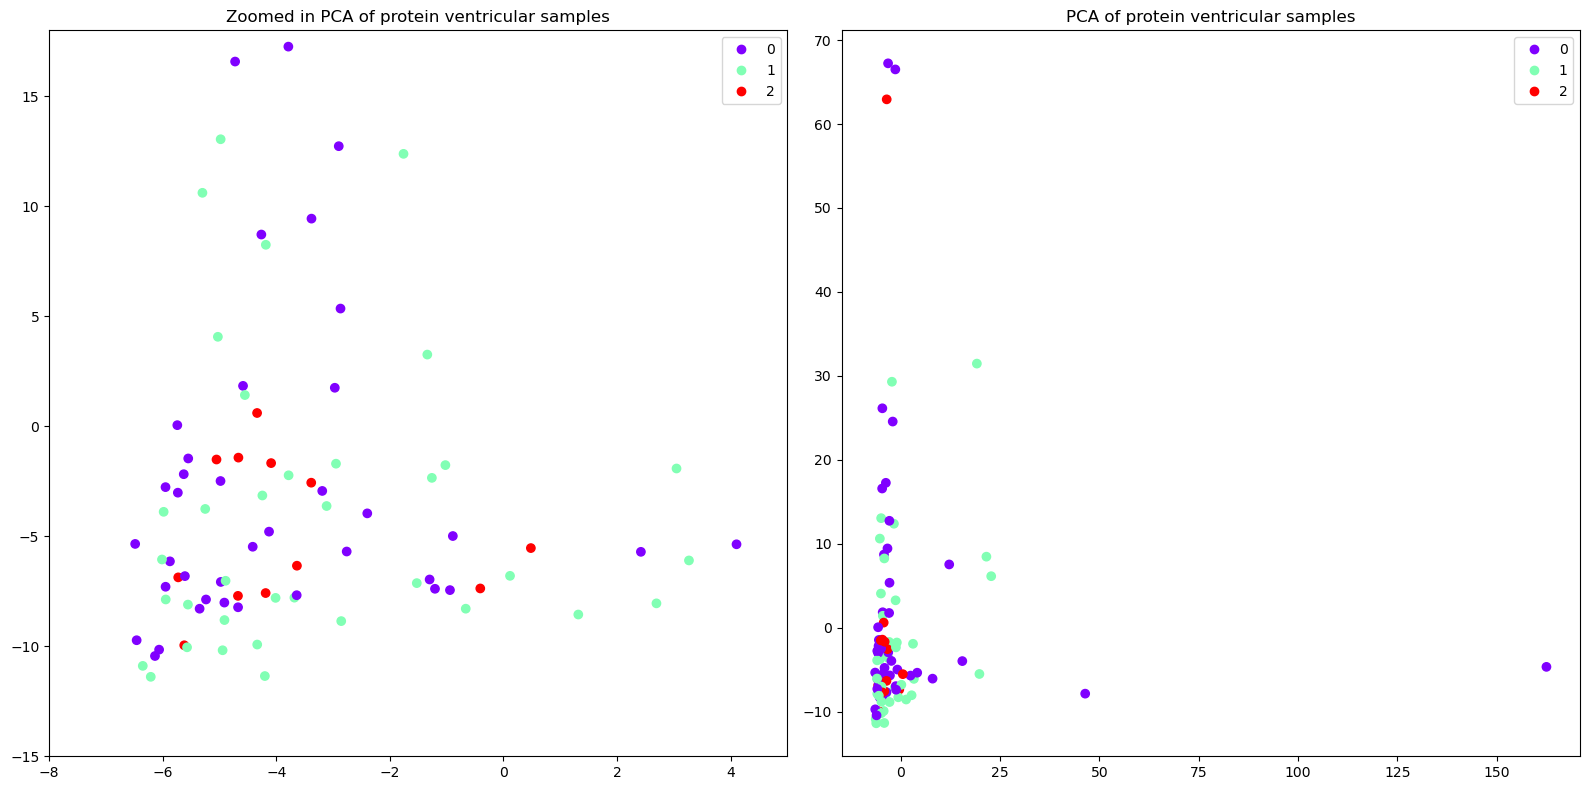

In [44]:
#--- PLOTTING PCA 2D PLOT FROM BEST Principal Component Table ---#
pca_median = do_PCA_on_DF(df_proteins_ventricular)
pca_ventricular = pca_median.fit_transform(set_max_missingness_per_column(df_proteins_ventricular, 0))

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].scatter(pca_ventricular[:,0], pca_ventricular[:,1], c=df_proteins_all_ventricular["Cortical_biopsy_grouping"], cmap="rainbow")
handles_0, _ = axs[0].collections[0].legend_elements()
labels_0 = set(df_proteins_all_ventricular["Cortical_biopsy_grouping"])
axs[0].legend(handles=handles_0, labels=labels_0)
axs[0].set_xlim(-8, 5)
axs[0].set_ylim(-15, 18)
axs[0].set_title('Zoomed in PCA of protein ventricular samples')

axs[1].scatter(pca_ventricular[:,0], pca_ventricular[:,1], c=df_proteins_all_ventricular["Cortical_biopsy_grouping"], cmap="rainbow")
handles_1, _ = axs[1].collections[0].legend_elements()
labels_1 = set(df_proteins_all_ventricular["Cortical_biopsy_grouping"])
axs[1].legend(handles=handles_1, labels=labels_1)
axs[1].set_title('PCA of protein ventricular samples')

plt.tight_layout()
plt.show()

Despite the warped nature of the scatterplot to the left, we can see that category 2 is fairly compacted compared to the other 2 categories. However, there are outliers even among that category (AD).

### PCA - (Zero Imputation)

#### Zero Imputed Datasets

In [39]:
#Entire protein and peptide dataset.
df_proteins_median_all_zero = replace_nan_with_zero(df_proteins_median_all)
df_proteins_all_zero = replace_nan_with_zero(df_proteins_all)
df_peptides_median_all_zero = replace_nan_with_zero(df_peptides_median_all)
df_peptides_all_zero = replace_nan_with_zero(df_peptides_all)

#Only protein and peptide features.
df_proteins_median_zero = replace_nan_with_zero(df_proteins_median) 
df_proteins_zero = replace_nan_with_zero(df_proteins) 
df_peptides_median_zero = replace_nan_with_zero(df_peptides_median) 
df_peptides_zero = replace_nan_with_zero(df_peptides) 

#Lumbar, full dataset.
df_proteins_median_all_lumbar_zero = replace_nan_with_zero(df_proteins_median_all_lumbar)
df_proteins_all_lumbar_zero = replace_nan_with_zero(df_proteins_all_lumbar)
df_peptides_median_all_lumbar_zero = replace_nan_with_zero(df_peptides_median_all_lumbar)
df_peptides_all_lumbar_zero = replace_nan_with_zero(df_peptides_all_lumbar)

#Lumbar, only protein or peptide features.
df_proteins_median_lumbar_zero = replace_nan_with_zero(df_proteins_median_lumbar)
df_proteins_lumbar_zero = replace_nan_with_zero(df_proteins_lumbar)
df_peptides_median_lumbar_zero = replace_nan_with_zero(df_peptides_median_lumbar)
df_peptides_lumbar_zero = replace_nan_with_zero(df_peptides_lumbar)

#Ventricular, full dataset.
df_proteins_median_all_ventricular_zero = replace_nan_with_zero(df_proteins_median_all_ventricular)
df_proteins_all_ventricular_zero = replace_nan_with_zero(df_proteins_all_ventricular)
df_peptides_median_all_ventricular_zero = replace_nan_with_zero(df_peptides_median_all_ventricular)
df_peptides_all_ventricular_zero = replace_nan_with_zero(df_peptides_all_ventricular)

#Ventricular, only pretein or peptide features.
df_proteins_median_ventricular_zero = replace_nan_with_zero(df_proteins_median_ventricular)
df_proteins_ventricular_zero = replace_nan_with_zero(df_proteins_ventricular)
df_peptides_median_ventricular_zero = replace_nan_with_zero(df_peptides_median_ventricular)
df_peptides_ventricular_zero = replace_nan_with_zero(df_peptides_ventricular)

#### Median

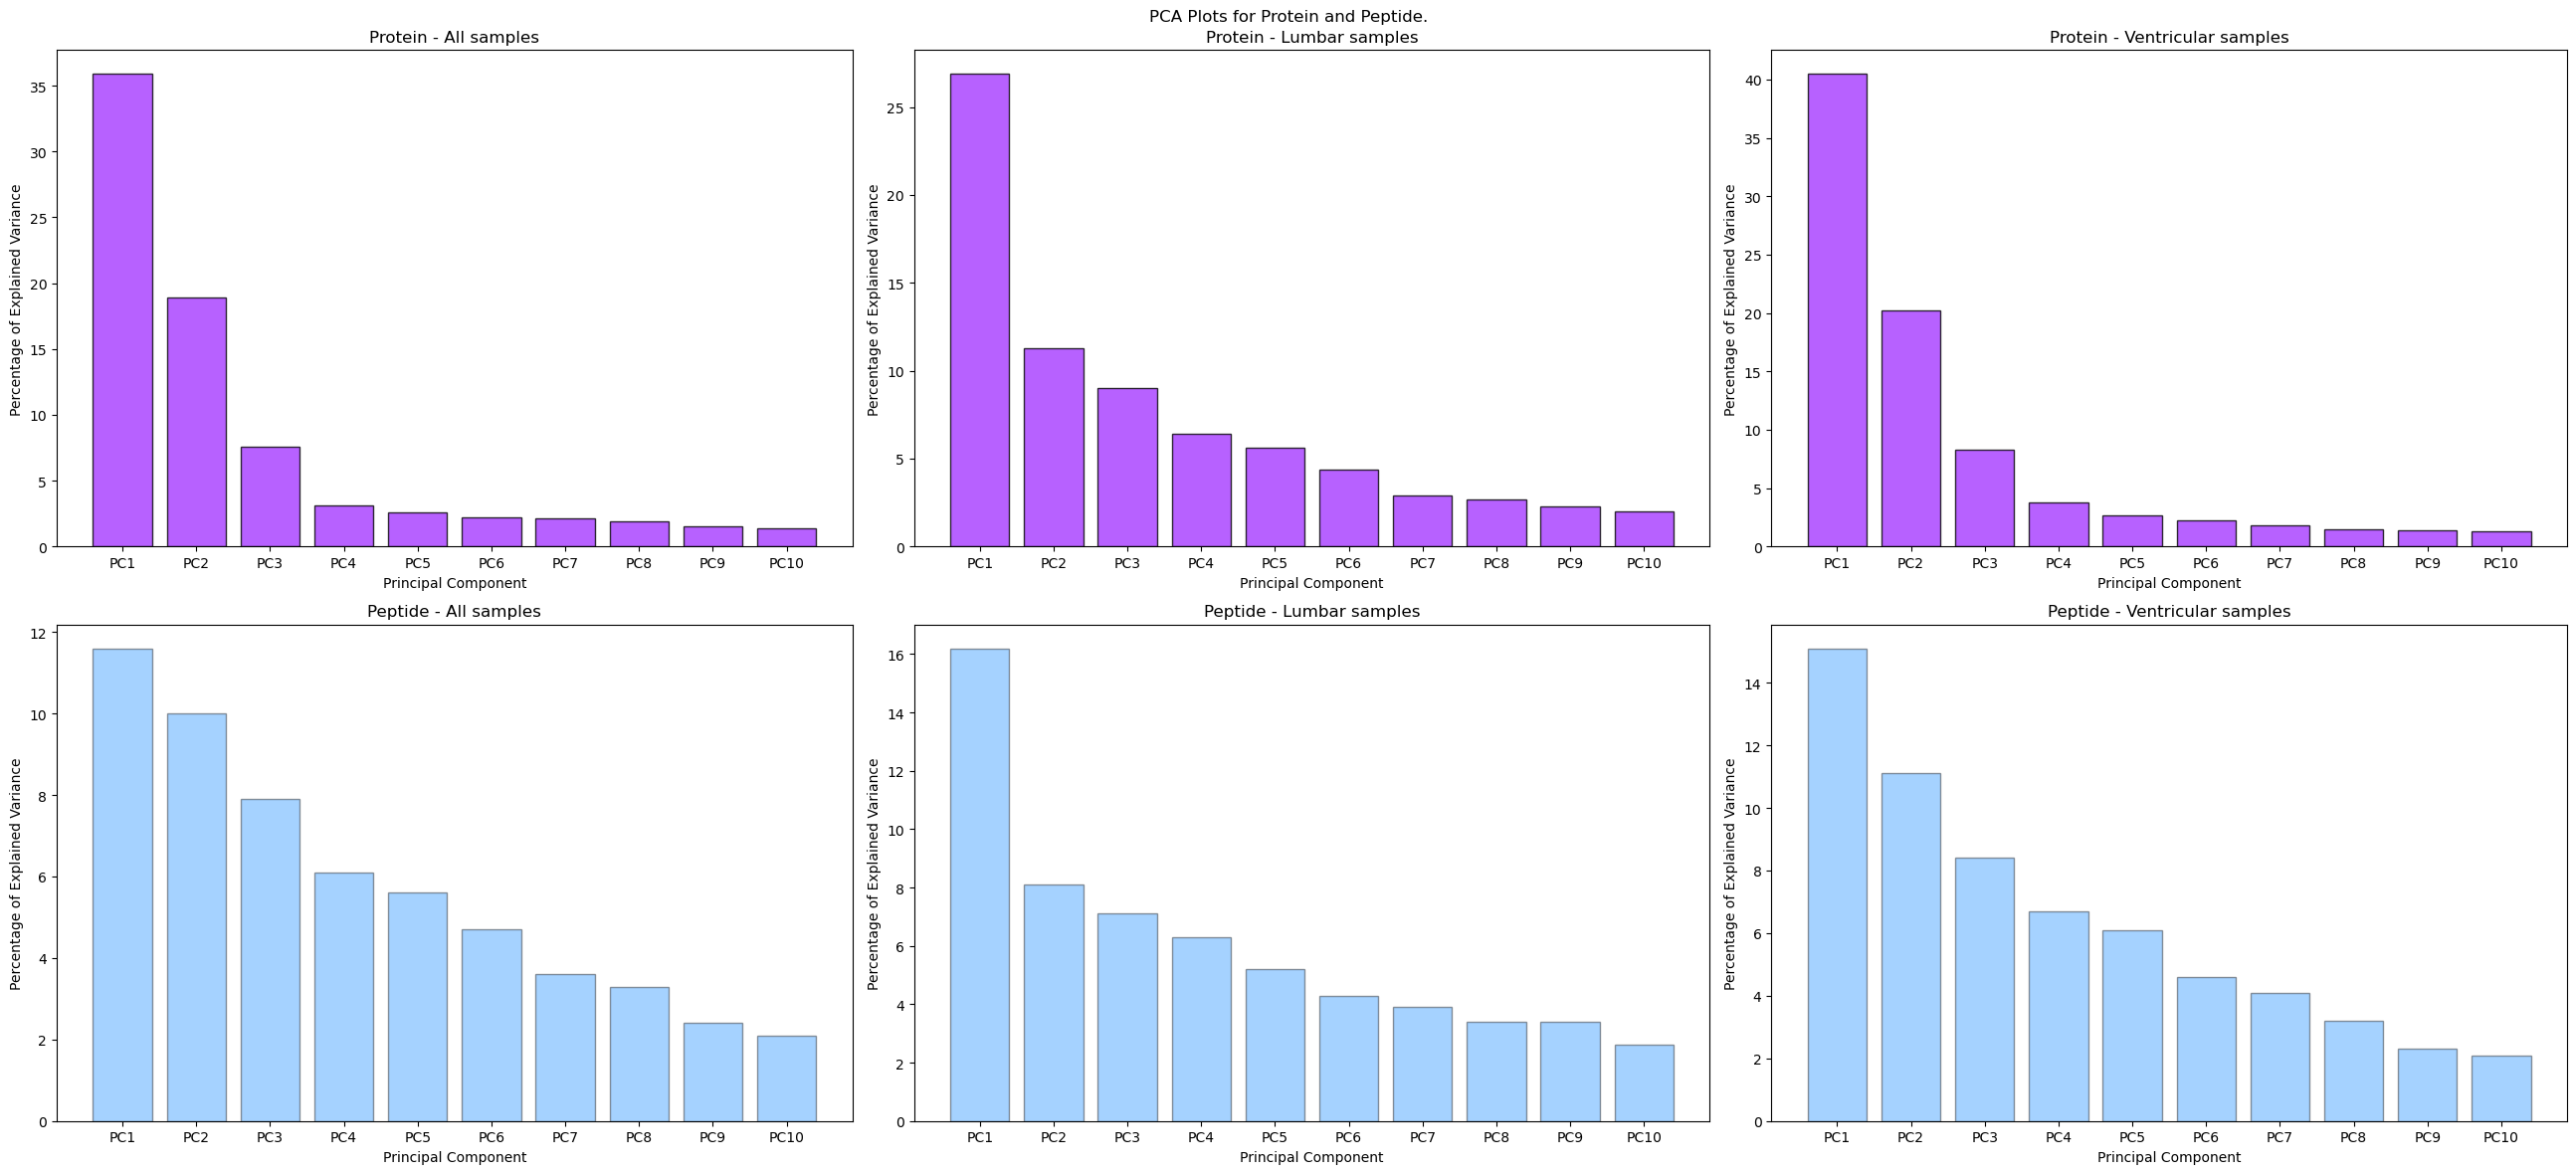

In [46]:
#--- RUNNING PCA CALCULATION AND PLOTTING ---#
datasets_protein = [df_proteins_median_zero, df_proteins_median_lumbar_zero, df_proteins_median_ventricular_zero]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [df_peptides_median_zero, df_peptides_median_lumbar_zero, df_peptides_median_ventricular_zero]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_scree_plot_data(do_PCA_on_DF(dataset_protein))
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_scree_plot_data(do_PCA_on_DF(dataset_peptide))
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

When imputing with zero when missing data is found, the PCA's are even worse than when removing the data. The protein data seems to still be decent, but the peptide is bad.

#### Non Normalized

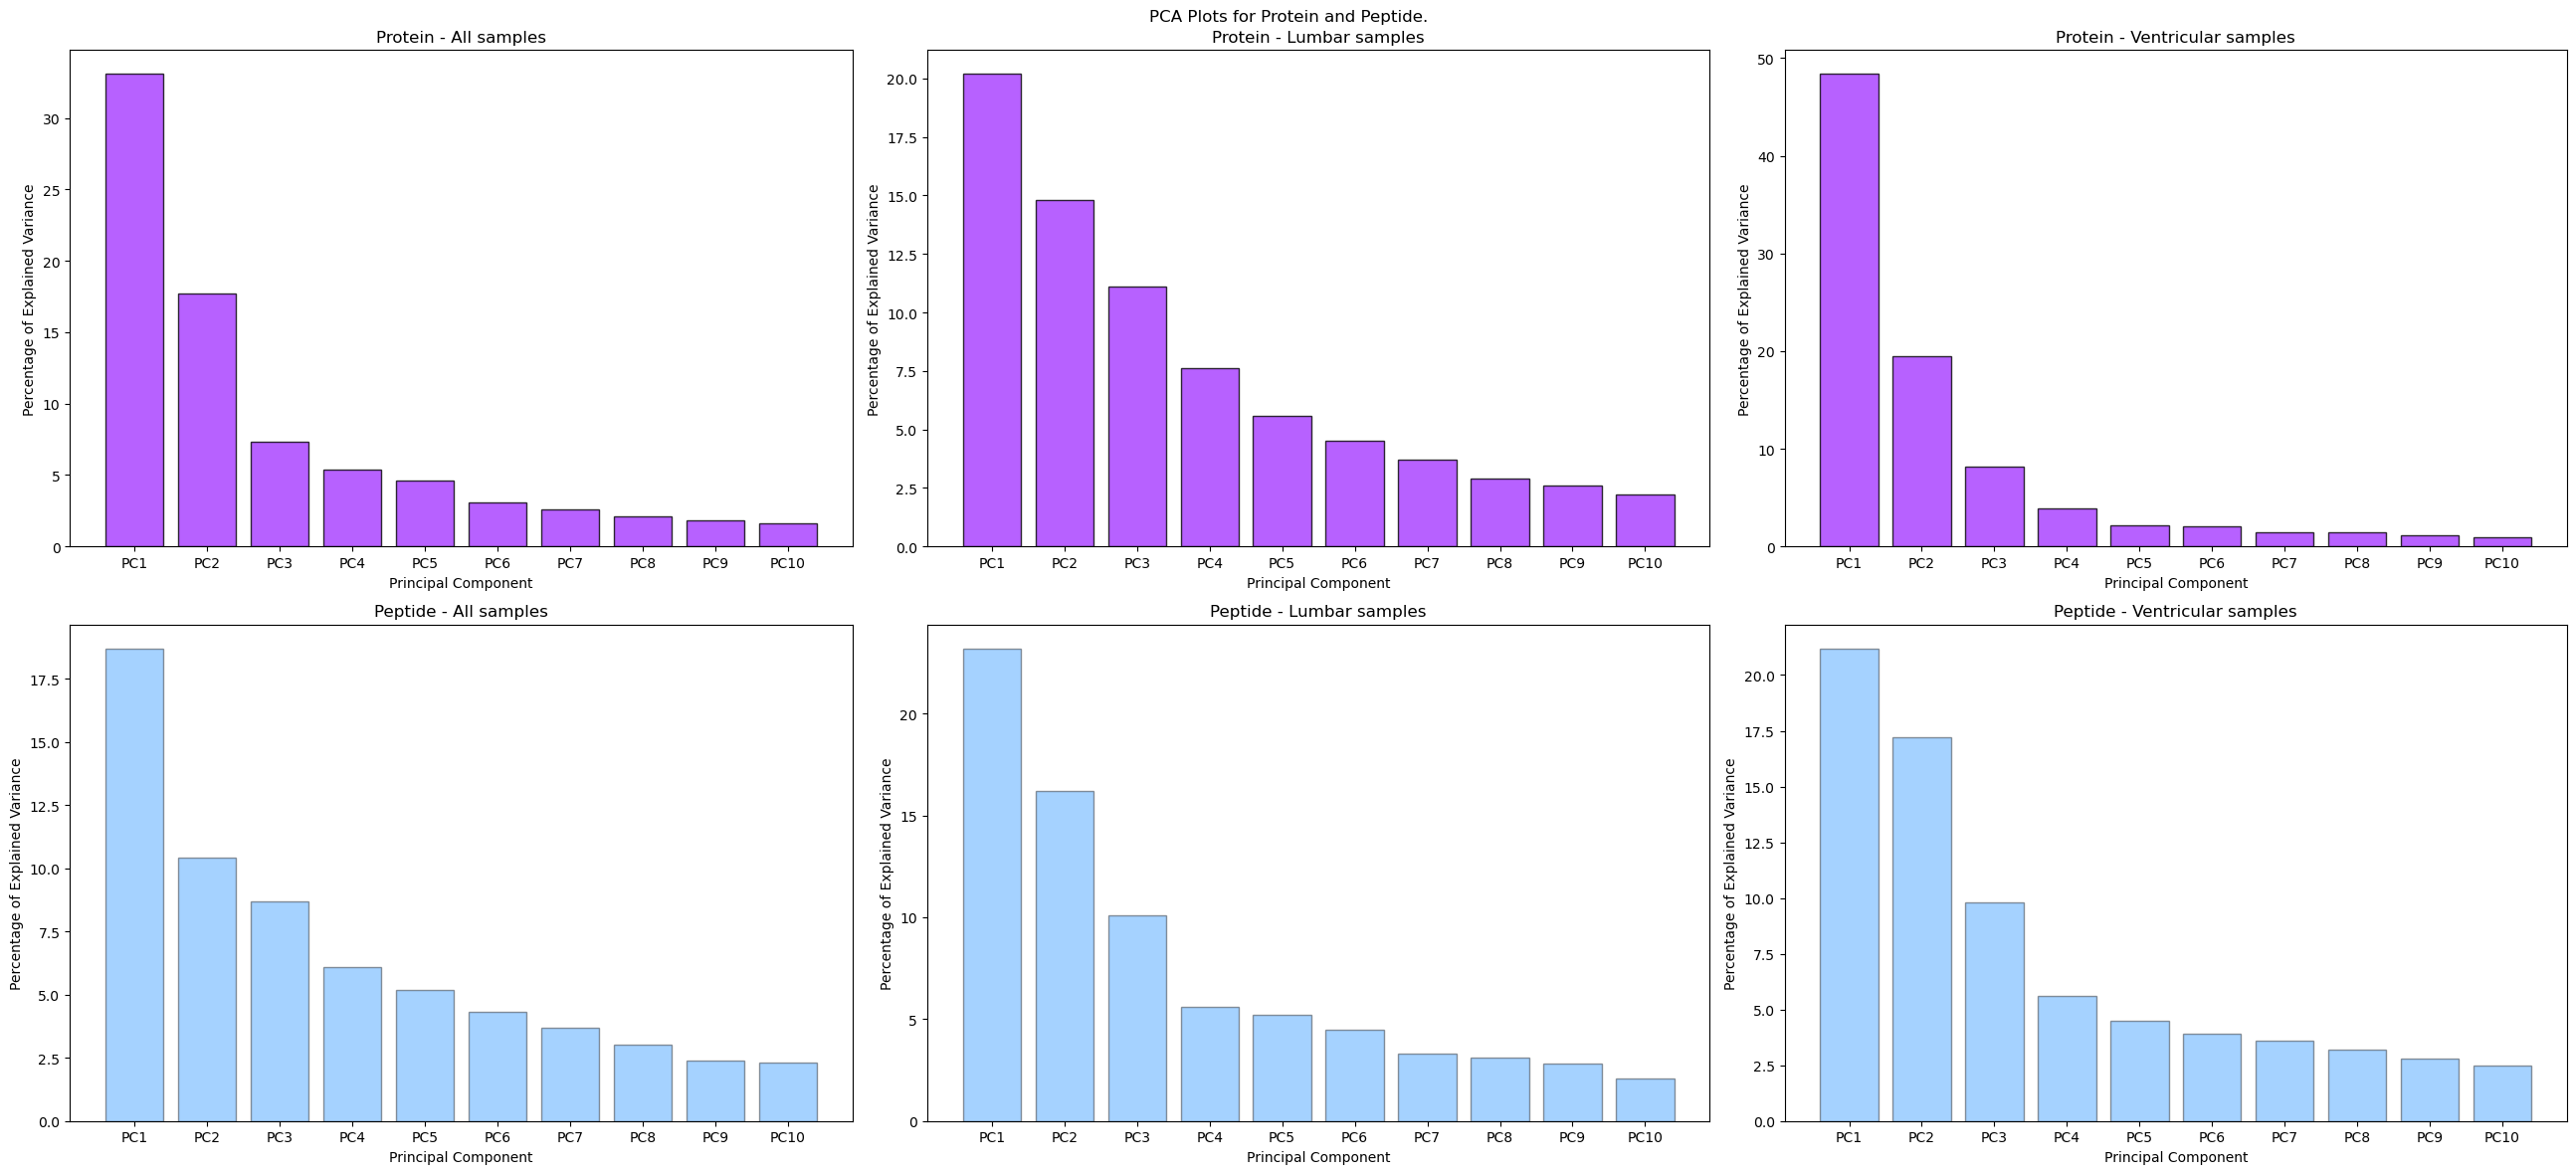

In [47]:
#--- RUNNING PCA CALCULATION AND PLOTTING ---#
datasets_protein = [df_proteins_zero, df_proteins_lumbar_zero, df_proteins_ventricular_zero]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [df_peptides_zero, df_peptides_lumbar_zero, df_peptides_ventricular_zero]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_scree_plot_data(do_PCA_on_DF(dataset_protein))
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_scree_plot_data(do_PCA_on_DF(dataset_peptide))
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

The zero imputed data without median normalization is better than with median normalization, but still worse than without zero imputation.

### t-SNE - (No Missingness)

#### Cortical_biopsy_grouping

In [48]:
def do_tSNE_on_DF(df, feature, lr=100, n_components=2):
    """Gets t-SNE data from DF.

    :param df: Dataframe to perform t-SNE on.
    :param lr: Learning rate of TSNE calculation.
    :param n_components: Number of t-SNE components to find.
    
    :return: t-SNE results in DF.""" 
    df_clean = set_max_missingness_per_column(df.iloc[:,11:], 0)
    scaler = StandardScaler()
    df_tsne = scaler.fit_transform(df_clean)
    tsne = TSNE(learning_rate=lr, n_components=n_components, random_state=42)
    tsne_features = tsne.fit_transform(df_tsne)

    df_done = pd.DataFrame({'x':tsne_features[:,0], 'y':tsne_features[:,1], feature: df[feature]})
    df_done = df_done.sort_values(by=feature)
    return df_done

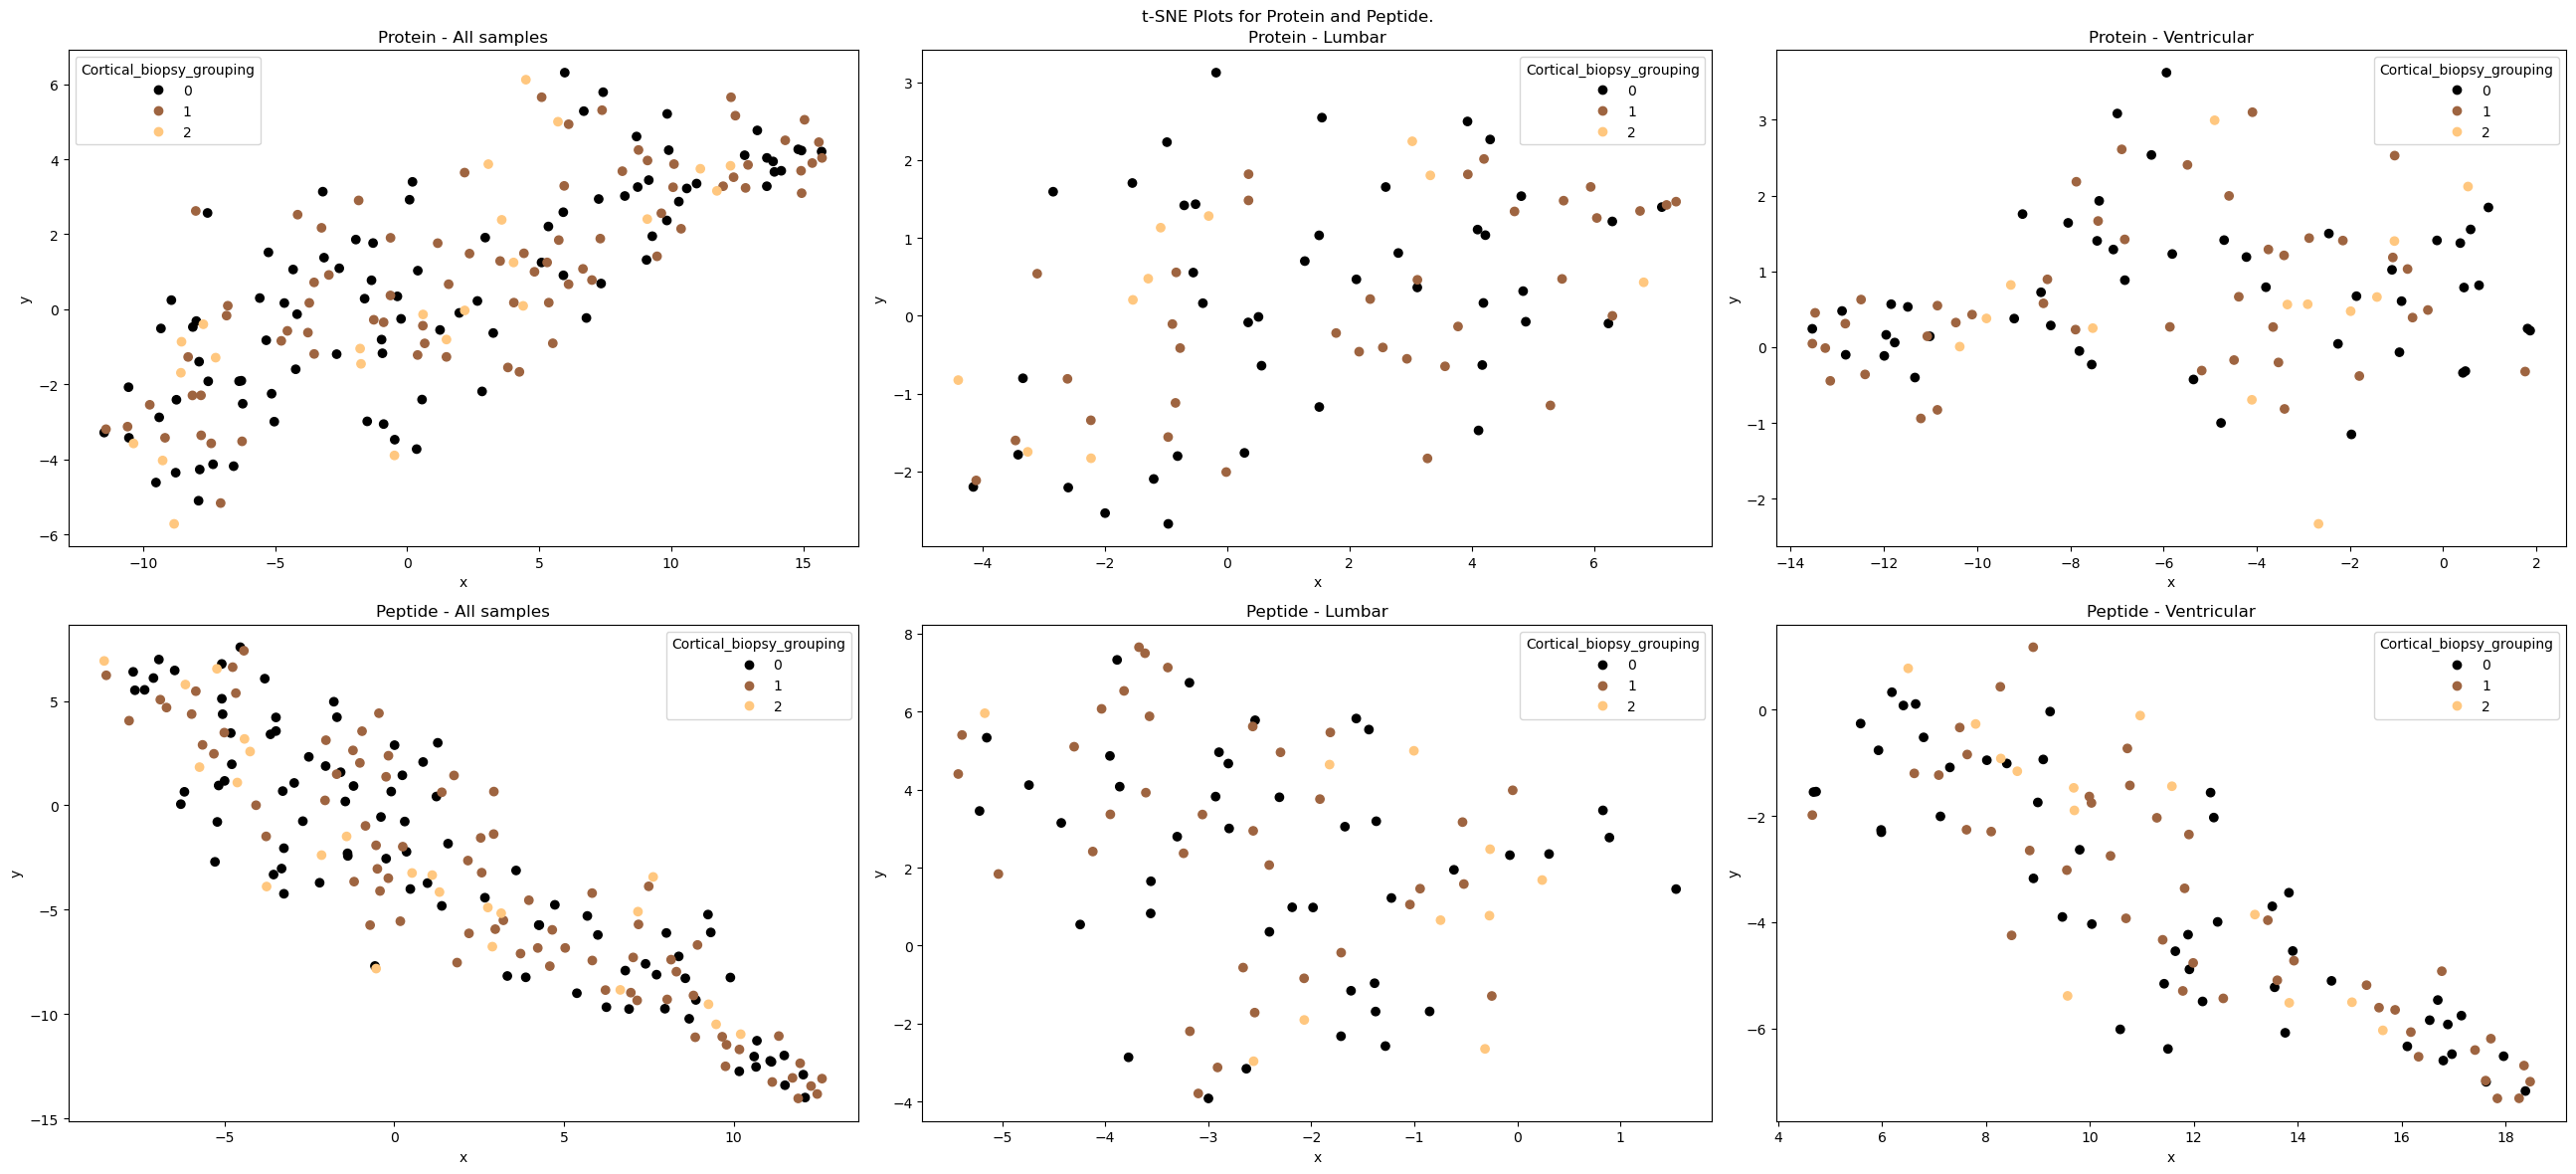

In [49]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(df_proteins_all,"Cortical_biopsy_grouping")
all_pep_result_df = do_tSNE_on_DF(df_peptides_all,"Cortical_biopsy_grouping")
l_pro_result_df = do_tSNE_on_DF(df_proteins_all_lumbar,"Cortical_biopsy_grouping")
l_pep_result_df = do_tSNE_on_DF(df_peptides_all_lumbar,"Cortical_biopsy_grouping")
v_pro_result_df = do_tSNE_on_DF(df_proteins_all_ventricular,"Cortical_biopsy_grouping")
v_pep_result_df = do_tSNE_on_DF(df_peptides_all_ventricular,"Cortical_biopsy_grouping")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["Cortical_biopsy_grouping"])
    legend_labels_protein = protein_df["Cortical_biopsy_grouping"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='Cortical_biopsy_grouping')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["Cortical_biopsy_grouping"])
    legend_labels_peptide = peptide_df["Cortical_biopsy_grouping"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='Cortical_biopsy_grouping')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

This further shows that there is no real correlation in order to classify the data based on only 2 dimensions. This seems to be true for all sample-sets (all, lumbar, ventricular).

#### TMT Set

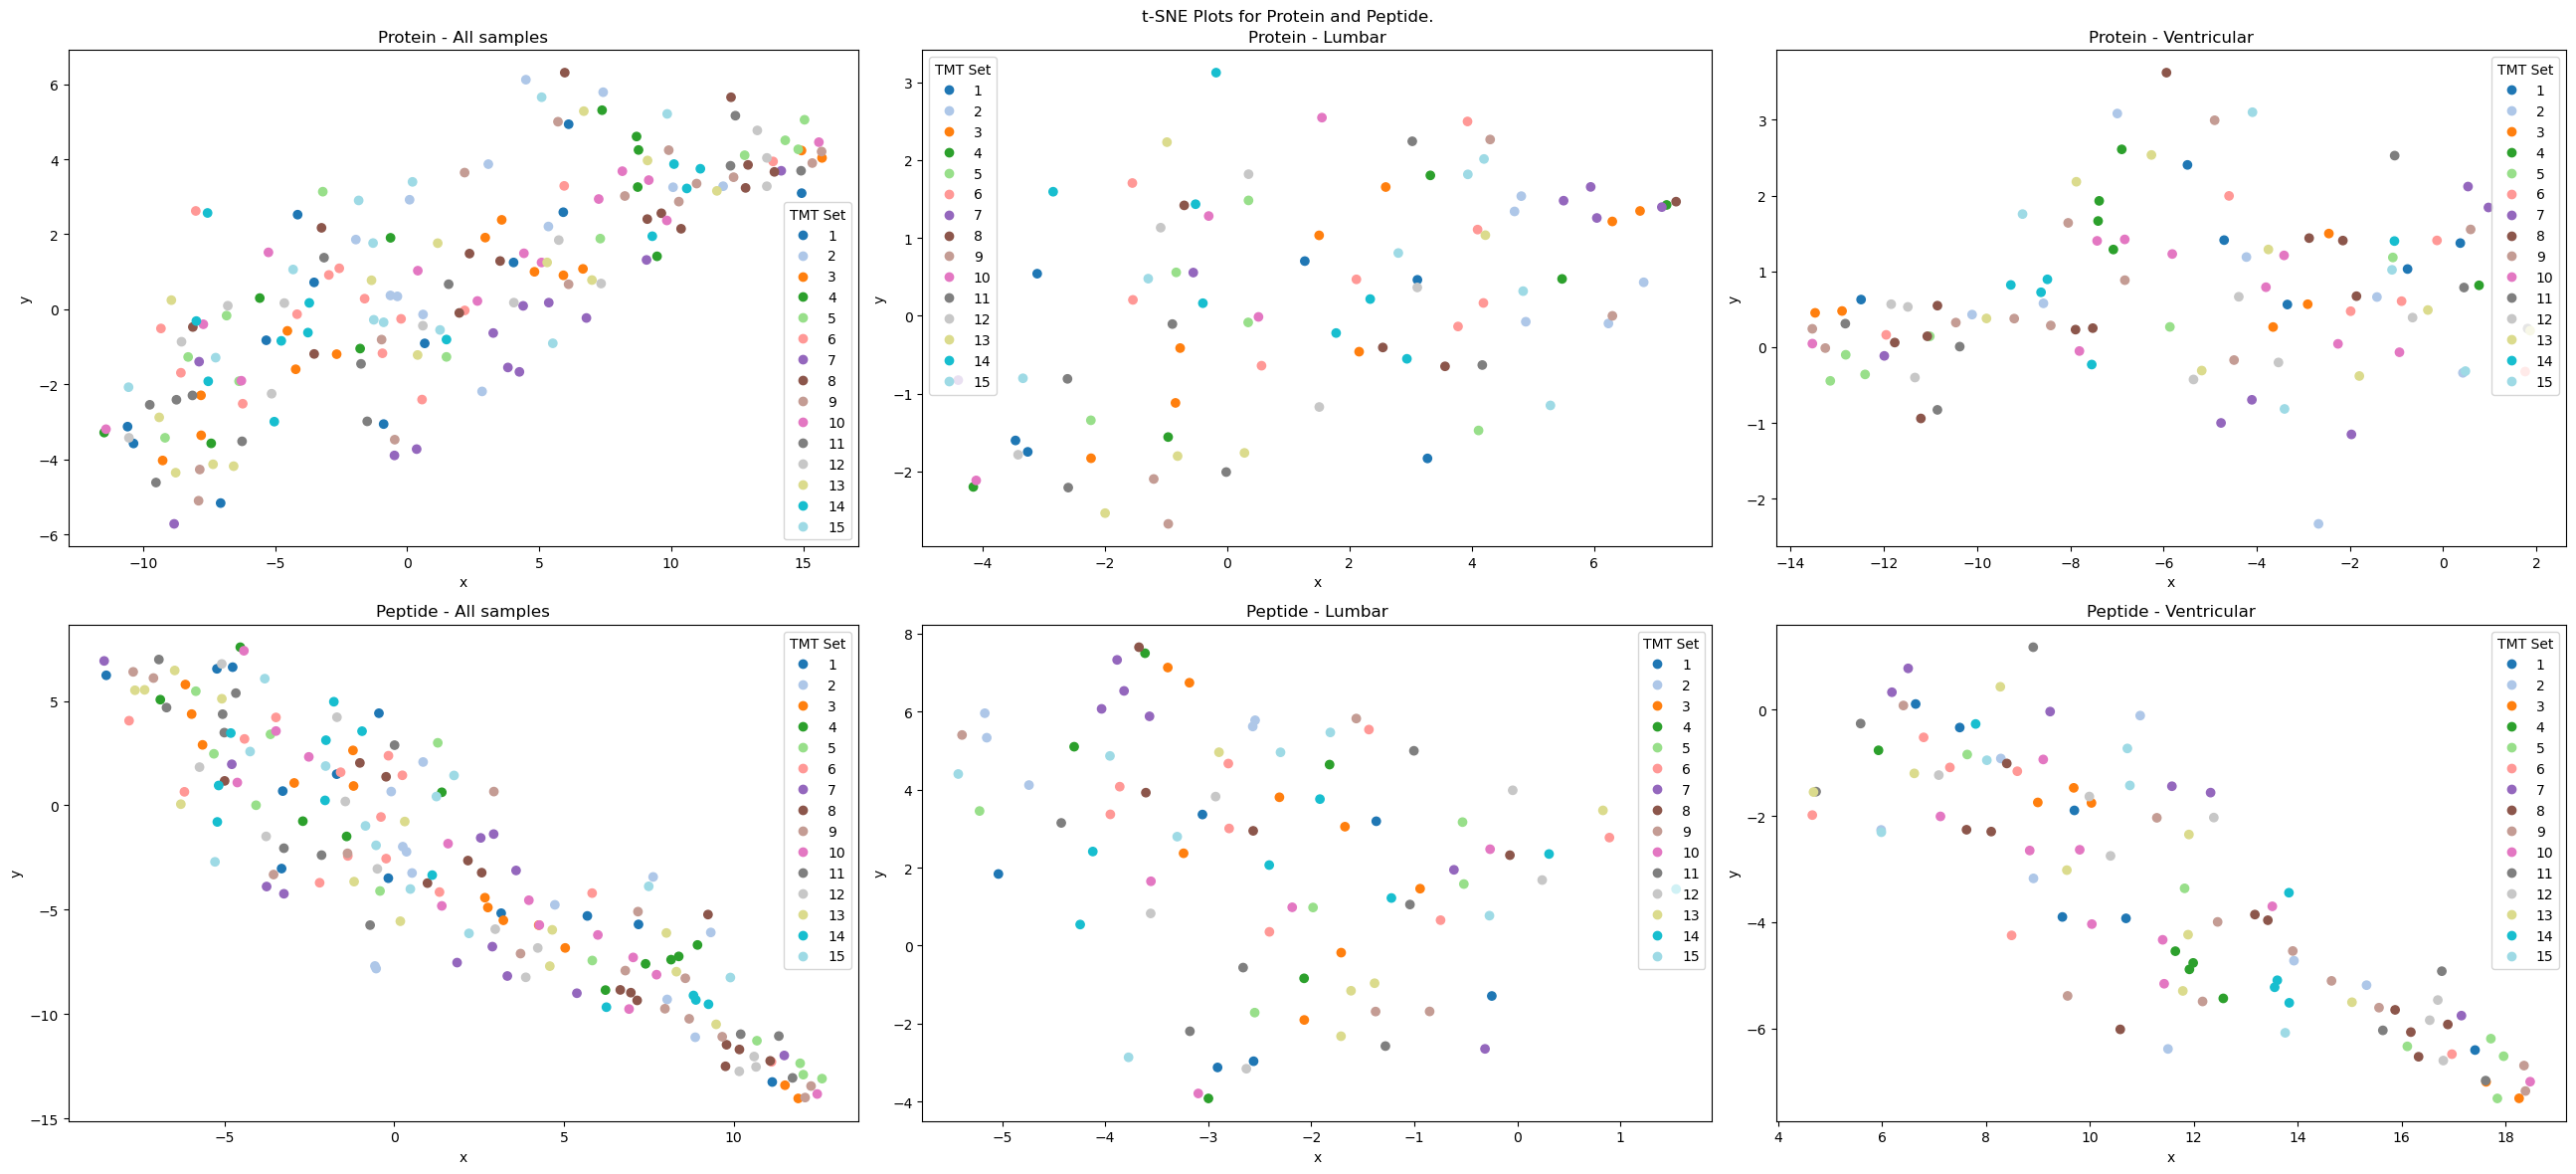

In [50]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(df_proteins_all,"TMT Set")
all_pep_result_df = do_tSNE_on_DF(df_peptides_all,"TMT Set")
l_pro_result_df = do_tSNE_on_DF(df_proteins_all_lumbar,"TMT Set")
l_pep_result_df = do_tSNE_on_DF(df_peptides_all_lumbar,"TMT Set")
v_pro_result_df = do_tSNE_on_DF(df_proteins_all_ventricular,"TMT Set")
v_pep_result_df = do_tSNE_on_DF(df_peptides_all_ventricular,"TMT Set")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='tab20', 
                                       c=protein_df["TMT Set"])
    legend_labels_protein = protein_df["TMT Set"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='TMT Set')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='tab20', 
                                       c=peptide_df["TMT Set"])
    legend_labels_peptide = peptide_df["TMT Set"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='TMT Set')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

This further shows that there is no real correlation between the TMT Sets when looking at only 2 dimensions on data where missingness features are removed. In one way, this is good because it shows that there is no real batch effect when removing these features. As can be seen further down, this does not hold true when imputing missingness with zero.

### t-SNE - (Zero Imputation)

#### Cortical_biopsy_grouping

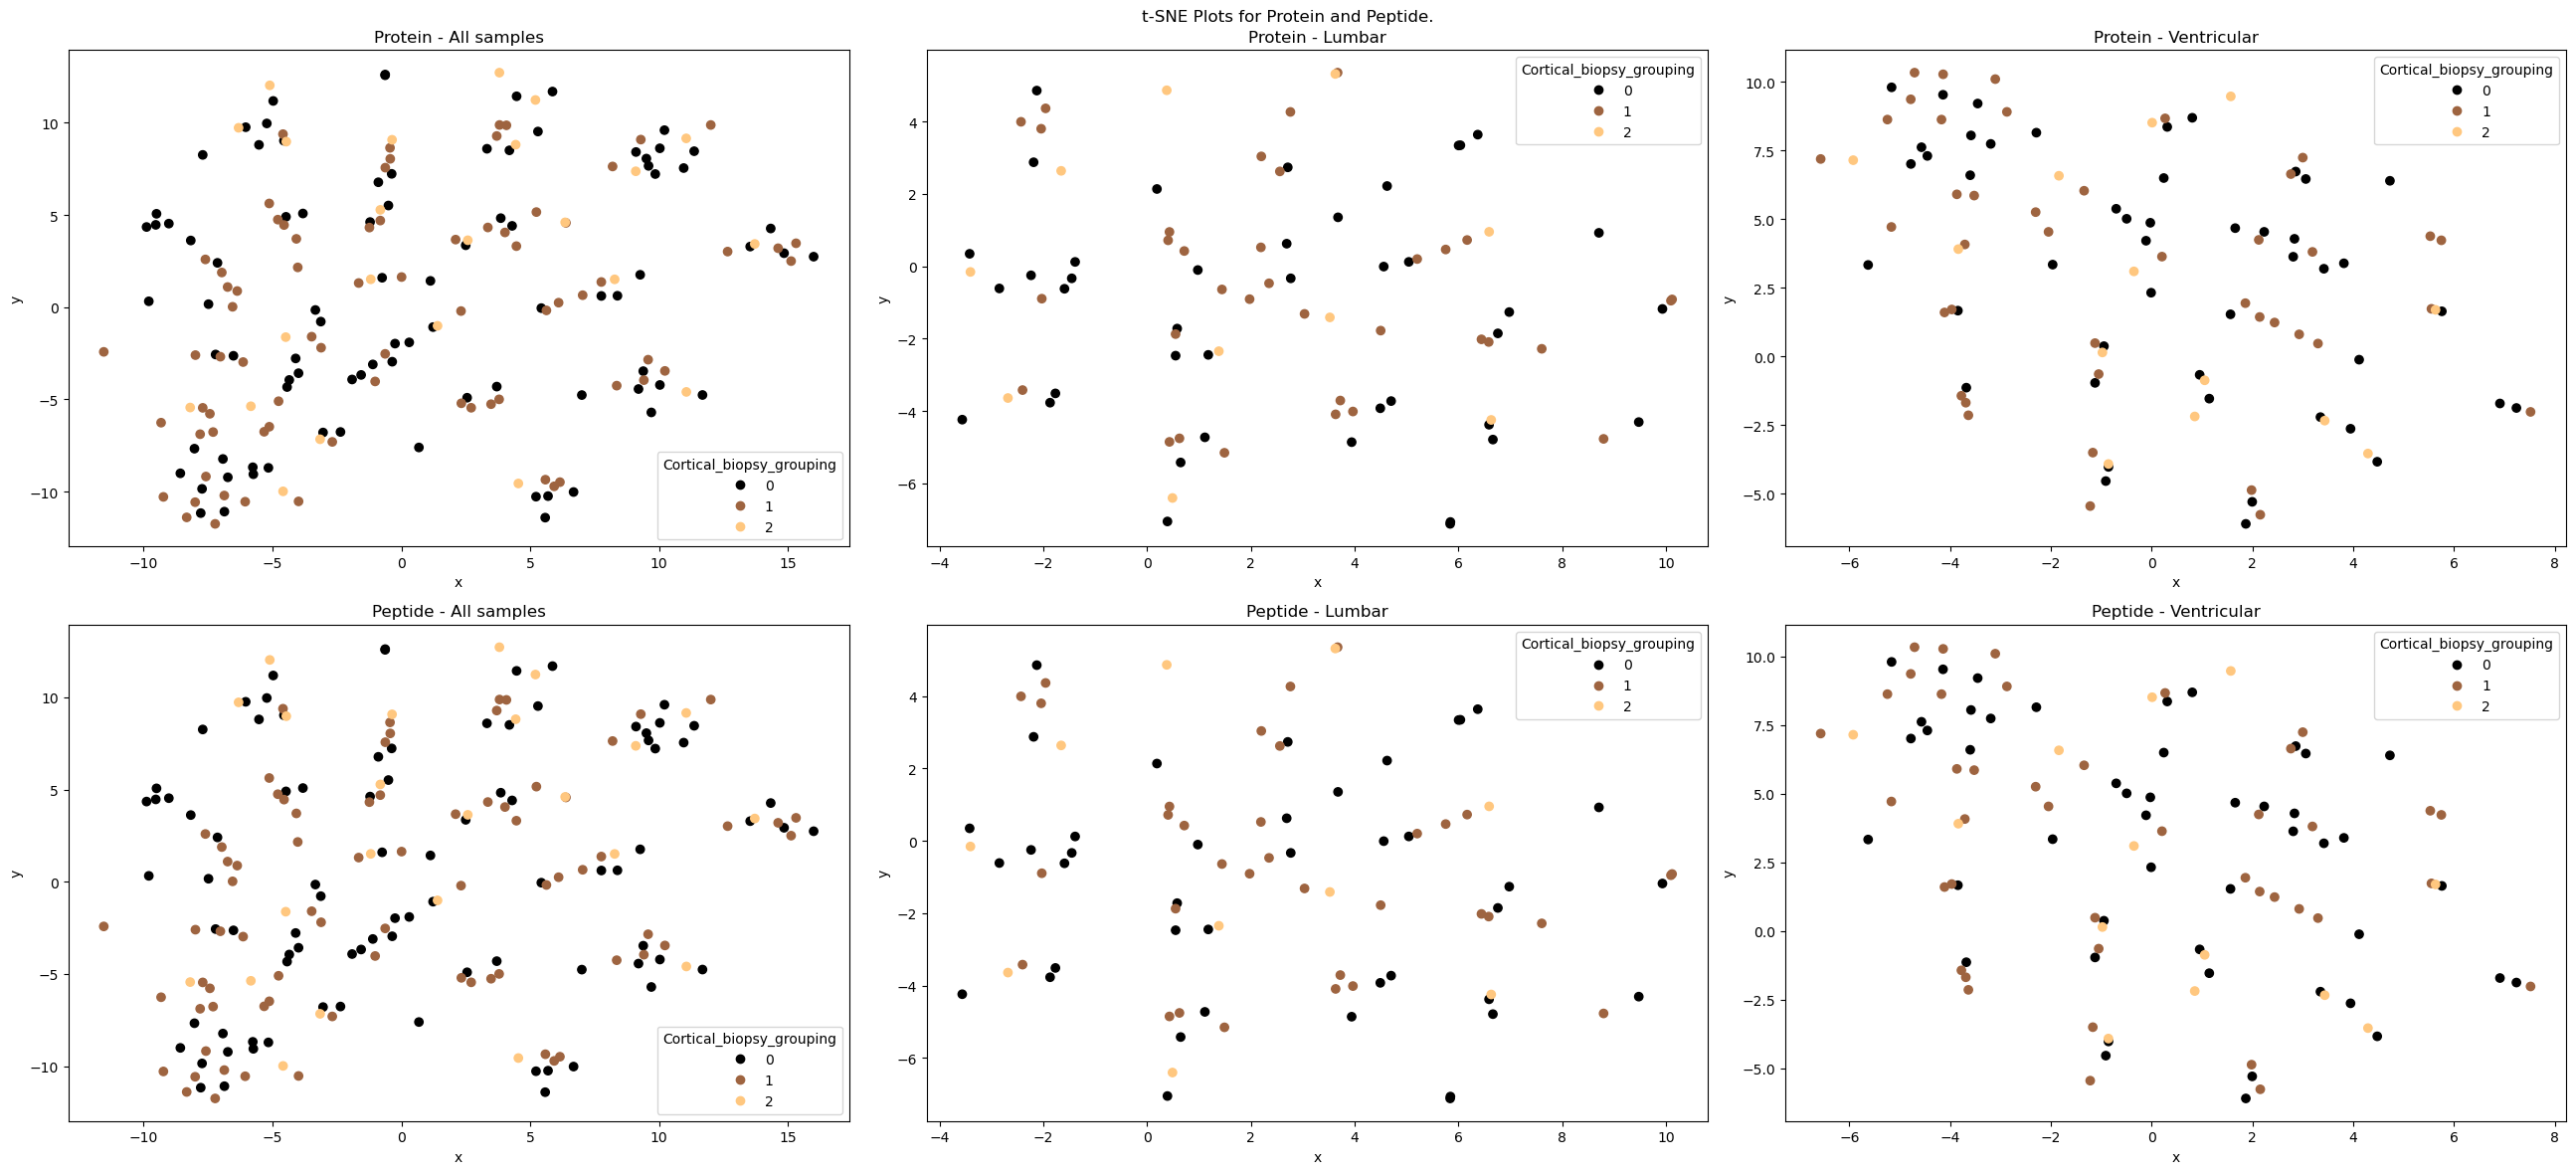

In [51]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(df_proteins_all_zero, "Cortical_biopsy_grouping")
all_pep_result_df = do_tSNE_on_DF(df_proteins_all_zero, "Cortical_biopsy_grouping")
l_pro_result_df = do_tSNE_on_DF(df_proteins_all_lumbar_zero, "Cortical_biopsy_grouping")
l_pep_result_df = do_tSNE_on_DF(df_proteins_all_lumbar_zero, "Cortical_biopsy_grouping")
v_pro_result_df = do_tSNE_on_DF(df_proteins_all_ventricular_zero, "Cortical_biopsy_grouping")
v_pep_result_df = do_tSNE_on_DF(df_proteins_all_ventricular_zero, "Cortical_biopsy_grouping")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["Cortical_biopsy_grouping"])
    legend_labels_protein = protein_df["Cortical_biopsy_grouping"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='Cortical_biopsy_grouping')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["Cortical_biopsy_grouping"])
    legend_labels_peptide = peptide_df["Cortical_biopsy_grouping"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='Cortical_biopsy_grouping')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

When doing t-SNE on the datasets with zero imputation, we can see groupings a lot more clearly compared to removing missingness features. However, when it comes to classifying the groups according to Cortical_biopsy_grouping (0 = No pathology, 1 = Only Abeta pathology, 2 = Both Abeta and tau pathology), there is no real correlation.

#### TMT Set

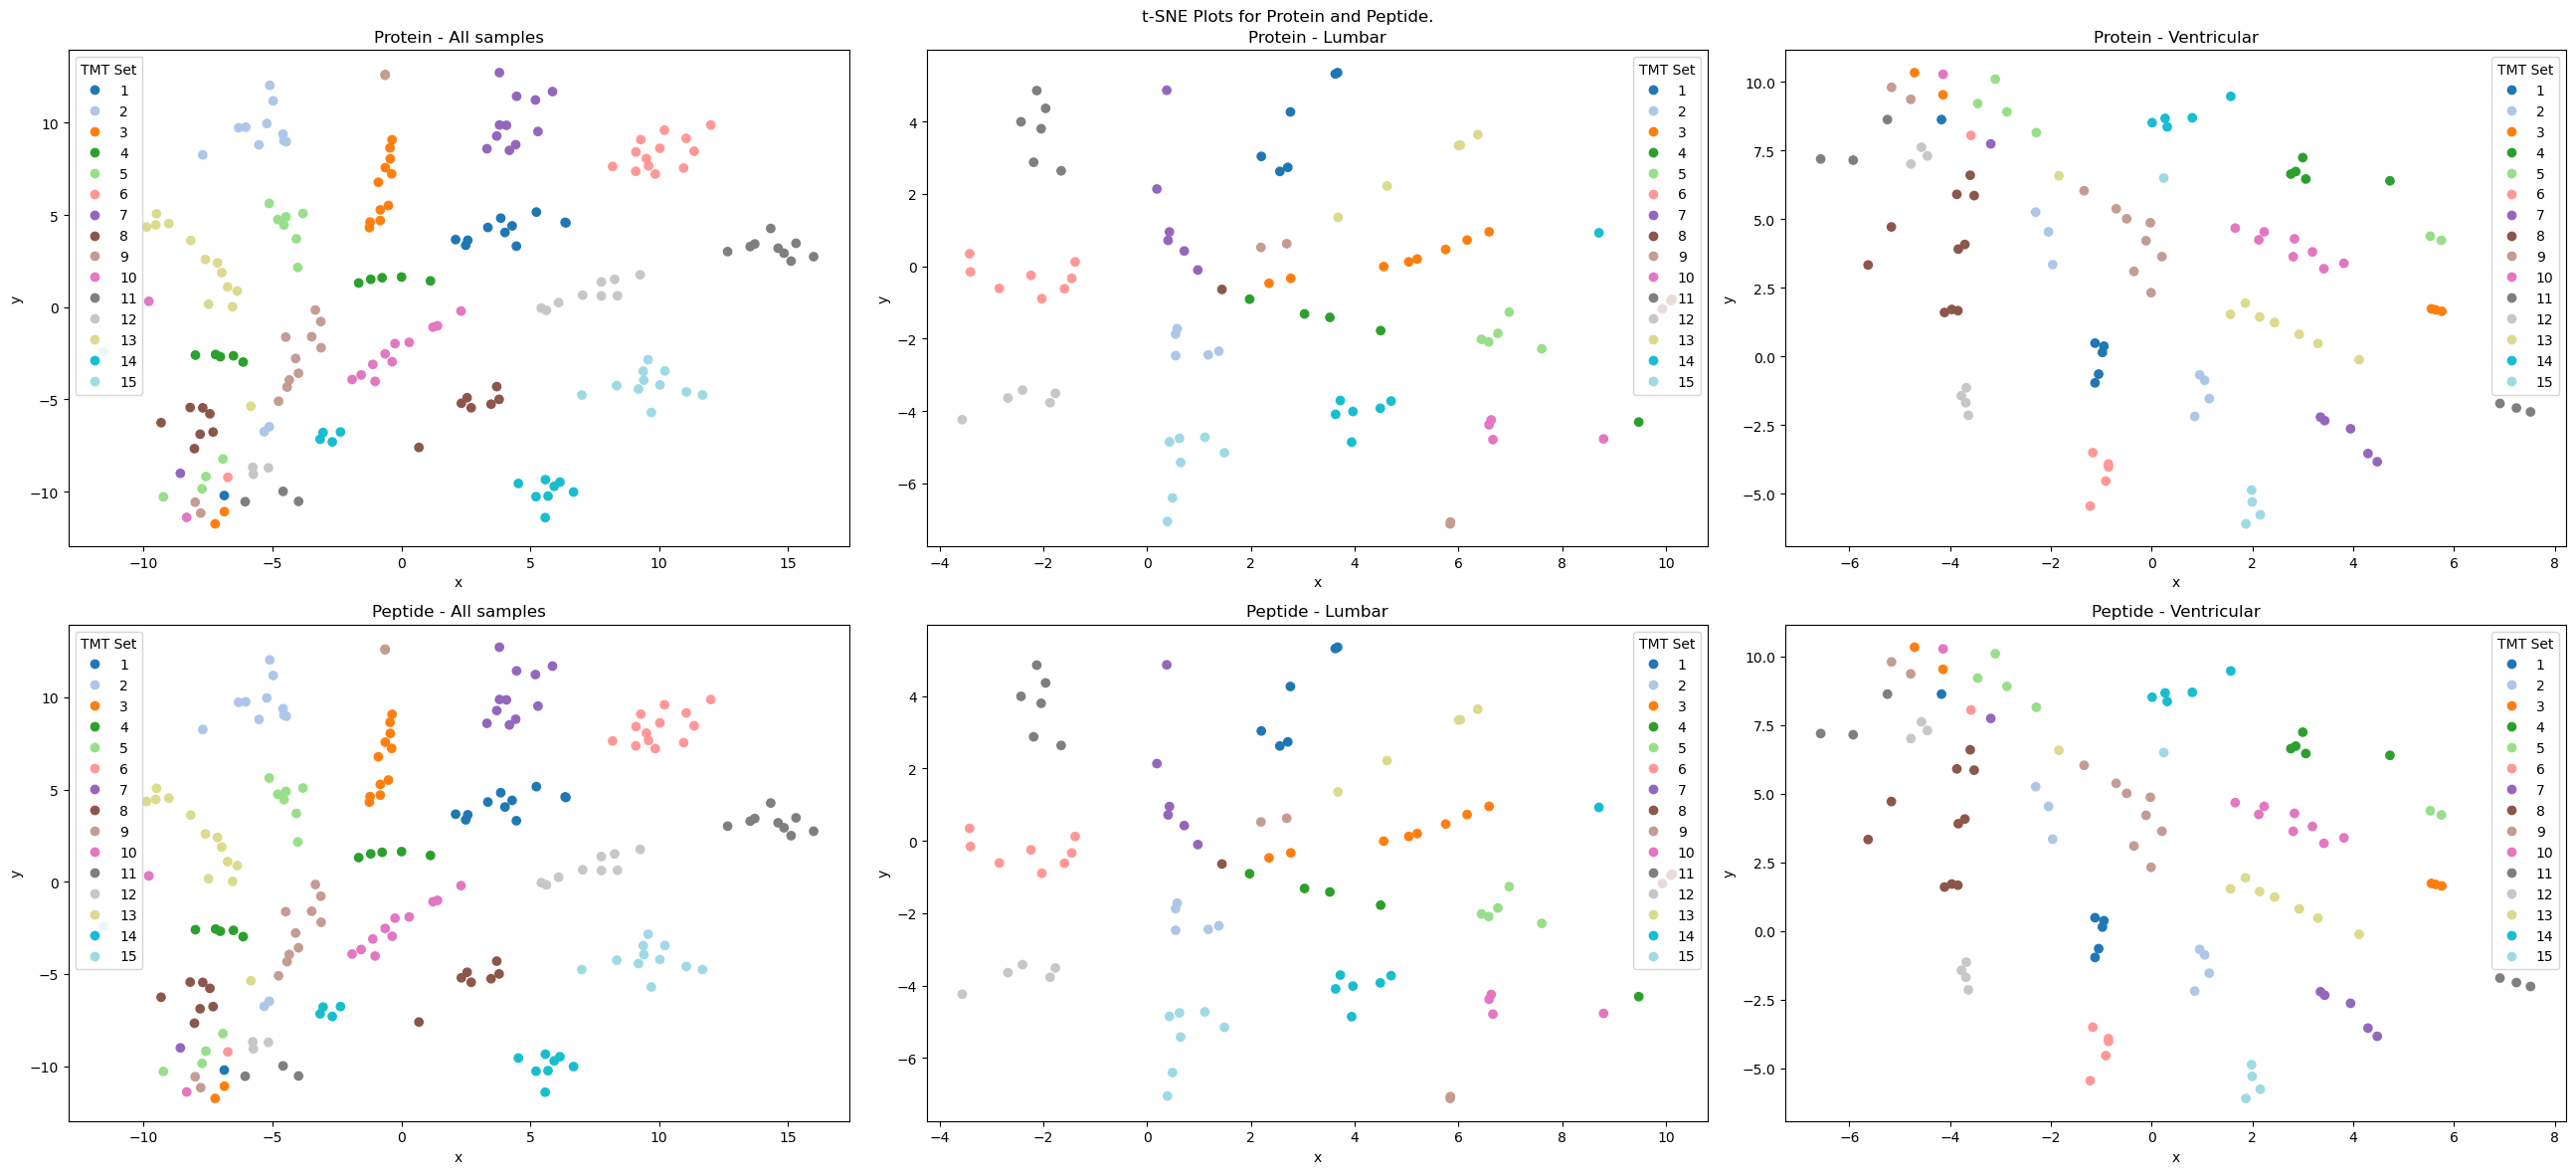

In [52]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(df_proteins_all_zero,"TMT Set")
all_pep_result_df = do_tSNE_on_DF(df_proteins_all_zero,"TMT Set")
l_pro_result_df = do_tSNE_on_DF(df_proteins_all_lumbar_zero,"TMT Set")
l_pep_result_df = do_tSNE_on_DF(df_proteins_all_lumbar_zero,"TMT Set")
v_pro_result_df = do_tSNE_on_DF(df_proteins_all_ventricular_zero,"TMT Set")
v_pep_result_df = do_tSNE_on_DF(df_proteins_all_ventricular_zero,"TMT Set")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='tab20', 
                                       c=protein_df["TMT Set"])
    legend_labels_protein = protein_df["TMT Set"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='TMT Set')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='tab20', 
                                       c=peptide_df["TMT Set"])
    legend_labels_peptide = peptide_df["TMT Set"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='TMT Set')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

When looking at the TMT Sets based on the datasets with zero imputation, we can see a very clear correlation between TMT Set and grouping with t-SNE. This suggest a heavy correlation, and is a sign of batch effect. This makes sense, as the different TMT Sets most likely have different proteins and peptides that have only 0 values (from the imputation), which easily distinguishes them from the other sets. The goal would be to find a imputation method that removes as few features as possible, and stil results in as much entrophy as possible, as that would mean that the batch effect has been removed efficiently. Further on, if features have to be removed (in case of high missingness), a zero imputation t-SNE should be compared to a "good imputation" t-SNE on the same sup-dataset, in order to determine if enough batch effect has been removed.

## Feature Importance

### Code

#### Random Forest and XGBoost

In [53]:
def random_forest_feature_extraction(df, y, num_runs = 100, num_trees = 100):
    """Extracts features through random forest from a df.

    :param df: Dataframe to extract features from.
    :param y: Predictor class in dataframe.
    :param num_runs: Number of iterations to create a random forest classifier.
    :param num_trees: Hyperparameter setting for each random forest classifier.
    
    :return: The features extracted in a pandas series.""" 
    X = set_max_missingness_per_column(df.iloc[:,11:], 0)
    y = df[y]

    all_feature_importances_list = [0] * len(X.columns)

    for run in range(num_runs):
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.25)
        rf_classifier = RandomForestClassifier(n_estimators=num_trees, random_state=run)
        rf_classifier.fit(X_train, y_train)
        all_feature_importances_list = [x+y for x,y in zip(all_feature_importances_list, rf_classifier.feature_importances_)]

    feature_importances_series = pd.Series(all_feature_importances_list, index=X.columns)
    feature_importances_series /= 100
    feature_importances_series = feature_importances_series.sort_values(ascending=False)
    
    return feature_importances_series

In [54]:
def visualize_top_features(importances1, importances2=None, top_n=10, samples="All samples"):
    """Visualize feature importance in barchart(s) from pandas series.

    :param importances1: Pandas series with feature importances.
    :param importances2: Pandas series with feature importances.
    
    :param top_n: How many features that should be visualized.""" 
    if importances2 is not None:
        top_features1 = importances1.head(top_n)
        top_features2 = importances2.head(top_n)

        fig, axes = plt.subplots(1, 2, figsize=(20, (top_n/4)))

        axes[0].barh(top_features1.index, top_features1.values)
        axes[0].set_xlabel('Importance')
        axes[0].set_title(f'Top {top_n} Feature Importance - Protein - {samples}')

        axes[1].barh(top_features2.index, top_features2.values)
        axes[1].set_xlabel('Importance')
        axes[1].set_title(f'Top {top_n} Feature Importance - Peptide - {samples}')

        plt.tight_layout()
        plt.show()

    else:
        top_features = importances1.head(top_n)

        plt.figure(figsize=(10, top_n/5))
        plt.barh(top_features.index, top_features.values)
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Feature Importance - {samples}')
        plt.show()

In [55]:
def xgb_feature_extraction(X, y, num_runs = 100):
    """Extracts features through XGBoost classifier from a df.

    :param df: Dataframe to extract features from.
    :param y: Predictor class in dataframe.
    :param num_runs: Number of iterations to create a XGBoost classifier.
    
    :return: The features extracted in a pandas series.""" 

    all_feature_importances_list = [0] * len(X.columns)

    for run in range(num_runs):
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.25)
        model = xgb.XGBClassifier()
        model.fit(X_train, y_train)

        all_feature_importances_list = [x+y for x,y in zip(all_feature_importances_list, model.feature_importances_)]

    feature_importances_series = pd.Series(all_feature_importances_list, index=X.columns)
    feature_importances_series /= 100
    feature_importances_series = feature_importances_series.sort_values(ascending=False)
    
    return feature_importances_series

#### Wilcoxon-Mann-Whitney p-value

In [56]:
def get_subDFs_based_on_category(df, target, category, target2=None):
    """Get 2 dataframes based on one-vs-all categorization.

    :param df: Dataframe to split based on category.
    :param target: Main category for one-vs-all.
    :param category: Feature to split dataframe in.
    :return df_target: Dataframe containing only target samples.
    
    :return df_remaining: Dataframe containing all but target samples.""" 
    if target2:
        df_target = df[df[category] == target] 
        df_target2 = df[df[category] == target2]
        return df_target, df_target2
    categories = df[category].unique()
    categories = [value for value in categories if value != target]
    df_target = df[df[category] == target]
    df_remaining = df[(df[category] == categories[0]) | (df[category] == categories[1])]
    return df_target, df_remaining

In [57]:
def wilcoxon_mann_whitney_test(cat1, not_cat1):
    """Performce Wlcoxon-Mann-Whitney-U-test on two lists.

    :param cat1: Target to get p-value from.
    :param not_cat1: Compared to target to get p-value.
    
    :return: Returns the p-value from the calculation.""" 
    _, p_value = stats.mannwhitneyu(cat1, not_cat1, method="asymptotic")
    return p_value

In [58]:
def do_mww_tests(df, df_clean, target, category, threshold = 0.05, o_vs_o = None):
    """Replace inf, -inf and 100 with nan.

    :param df: Dataframe with all values, including category feature.
    :param df_clean: Dataframe with only columns to be p-value calculated.
    :param target: Target category feature in dataframe.
    :param category: The name of the feature categpry.
    :param threshold: The threshold at which the p-value is considered good enough to return.
    :param o_vs_o: Set to One vs One or One vs All.

    :return: Dictionary with feature/p-value pairs.""" 
    resulting_p_values = {}

    if o_vs_o:
        df_target, df_remaining = get_subDFs_based_on_category(df, target, category, o_vs_o)
    else:
        df_target, df_remaining = get_subDFs_based_on_category(df, target, category)
    
    for col in df_clean.columns:
        cat1 = df_target[col].tolist()
        not_cat1 = df_remaining[col].tolist()
        p_val = wilcoxon_mann_whitney_test(cat1, not_cat1)

        if p_val <= threshold:
            resulting_p_values[col] = p_val
    
    return resulting_p_values

### Random Forest - (No missingness)

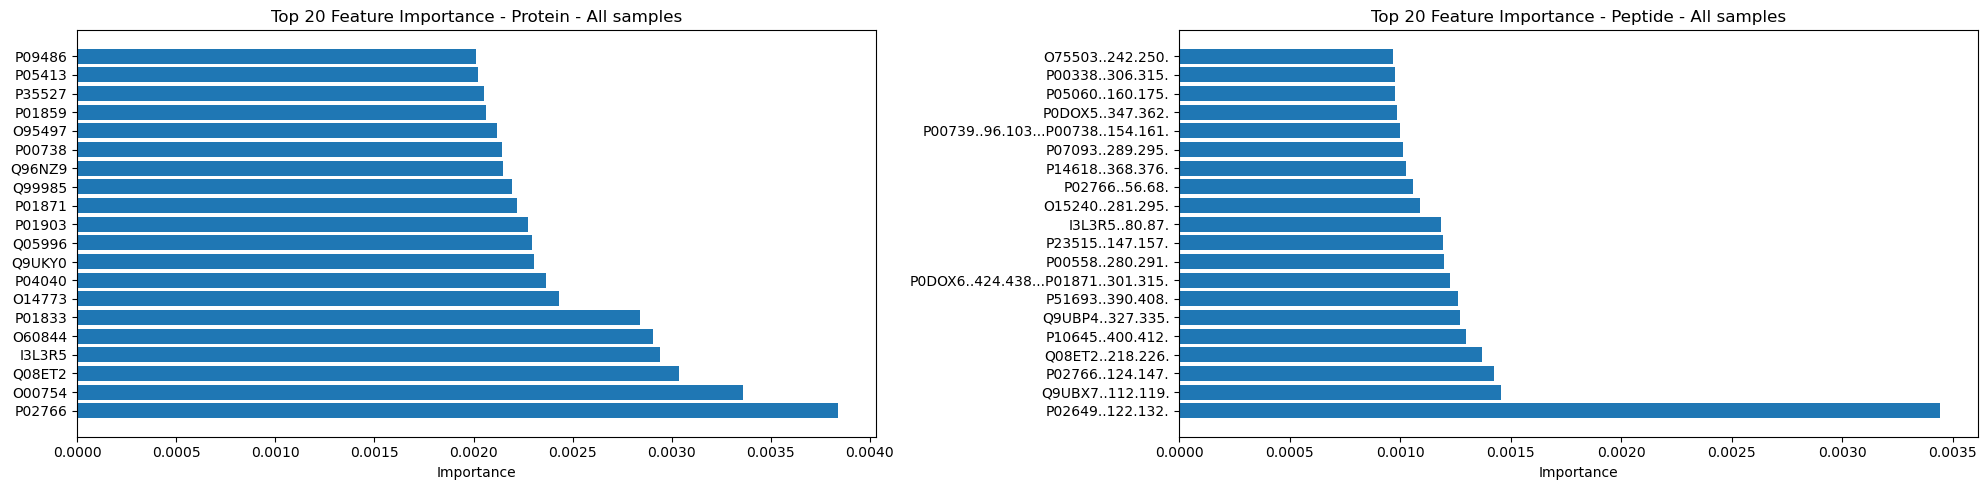

In [59]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - ALL SAMPLES ---#
protein_features_all = random_forest_feature_extraction(df_proteins_all, "Cortical_biopsy_grouping", 100)
peptide_features_all = random_forest_feature_extraction(df_peptides_all, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_all, peptide_features_all, 20)

These two plots shows the proteins and peptides, that does not have any missingness in the dataset, that has the highest feature importance based on the feature importance from running 100 iterations of random forest. The overall missingness from each random forest model was summed up, and plotted above.

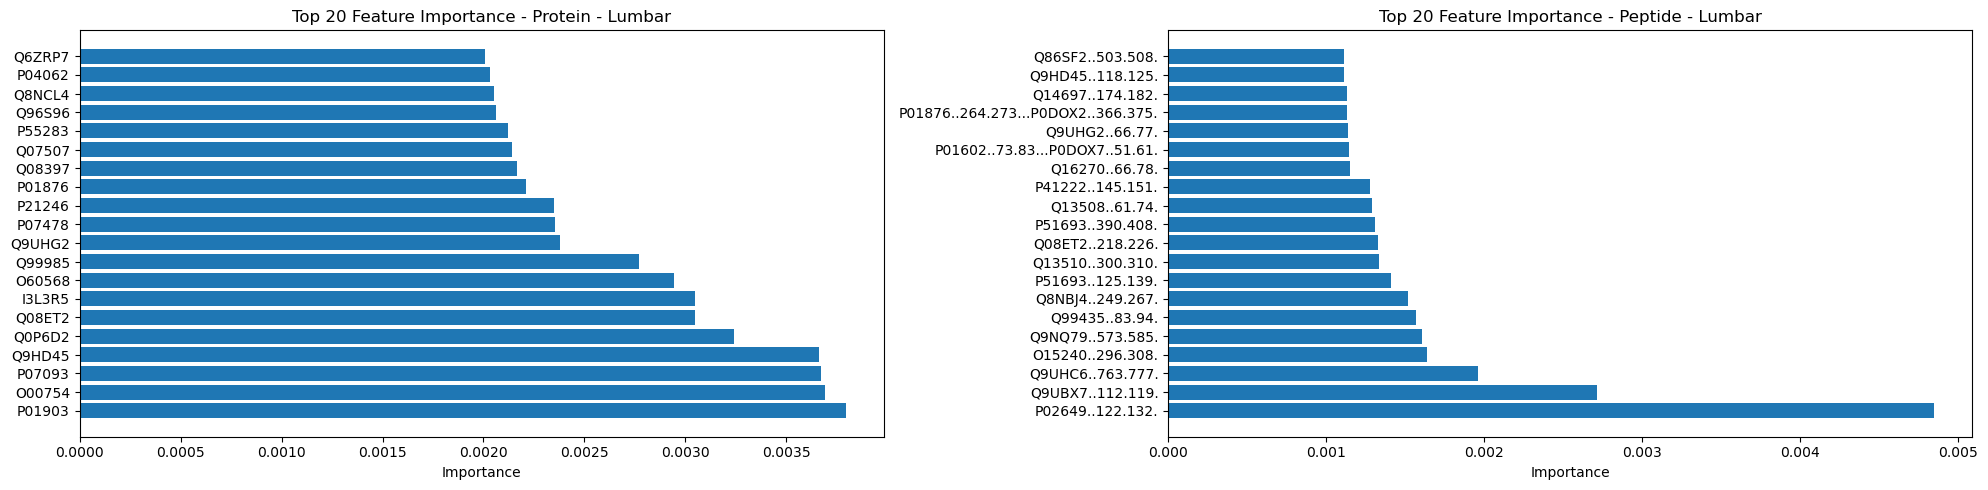

In [60]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - LUMBAR ---#
protein_features_l = random_forest_feature_extraction(df_proteins_all_lumbar, "Cortical_biopsy_grouping", 100)
peptide_features_l = random_forest_feature_extraction(df_peptides_all_lumbar, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_l, peptide_features_l, 20, "Lumbar")

Above is the top 20 features with highest importance based on random forest on the lumbar samples from both datasets. There is one peptide (P02649..122.132.) that can be found in both the lumbar dataset and the all samples set with very high importance, and one protein (Q00754) with decent feature importance in both datasets.

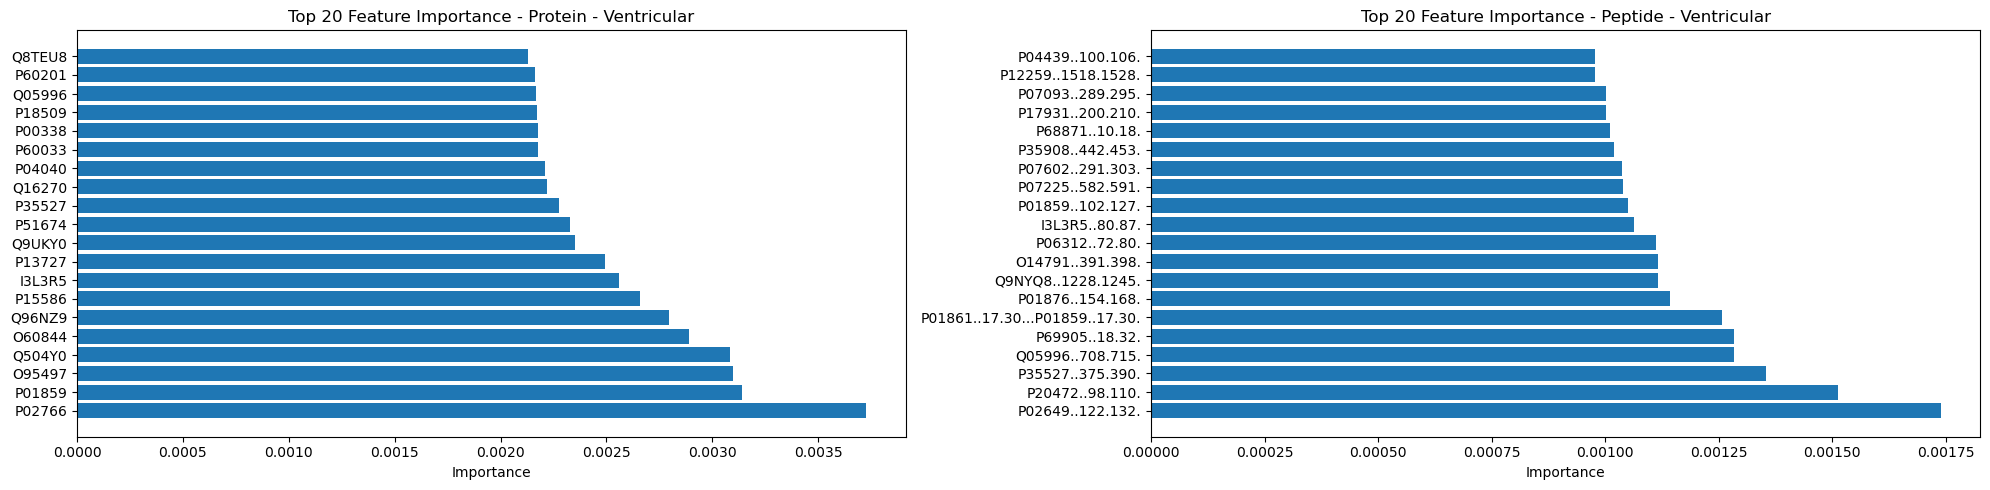

In [61]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - VENTRICULAR ---#
protein_features_v = random_forest_feature_extraction(df_proteins_all_ventricular, "Cortical_biopsy_grouping", 100)
peptide_features_v = random_forest_feature_extraction(df_peptides_all_ventricular, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_v, peptide_features_v, 20, "Ventricular")

This is just a very simplified feature extraction through a basic random forest model. This data is based on only features without missingness, but even here, we can see that some features are strong in both samples (especially in the peptide set), while the protein set does not seem to have any common proteins in the top 20 proteins from the lumbar and ventricular set. The all samples set, however, contains proteins from both the top lumbar and ventricular set, suggesting that even if they are not in the top 20, they do exist. This is more of a proof of concept rather than "finding the best features", and hints that, especially when looking at proteins, there are different proteins that should be looked at depending on if it is a lumbar sample or a ventricular sample.

### Random Forest - (Zero imputation)

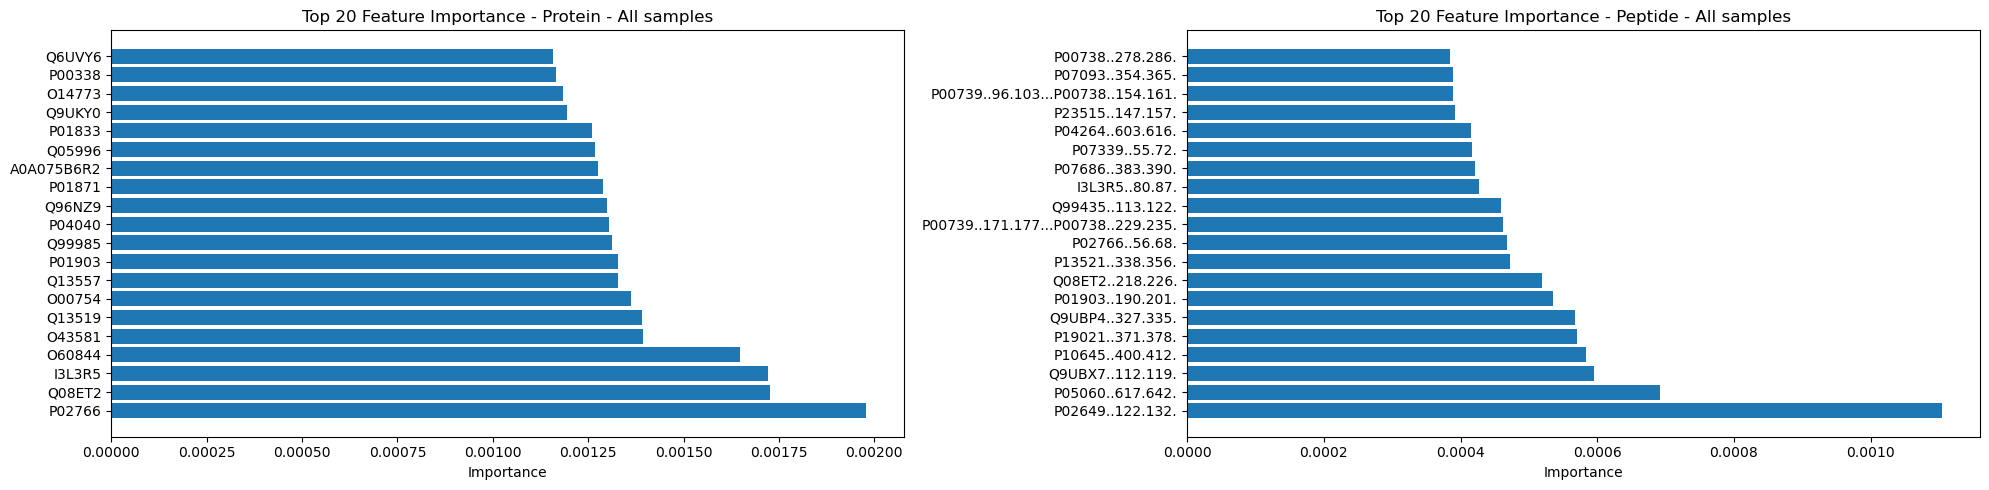

In [62]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - ALL SAMPLES ---#
protein_features_all_0 = random_forest_feature_extraction(df_proteins_all_zero, "Cortical_biopsy_grouping", 100)
peptide_features_all_0 = random_forest_feature_extraction(df_peptides_all_zero, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_all_0, peptide_features_all_0, 20)

When running datasets with zero imputation, the proteins with highest feature importance changes slightly, while the peptides seems to stay somewhat the same.

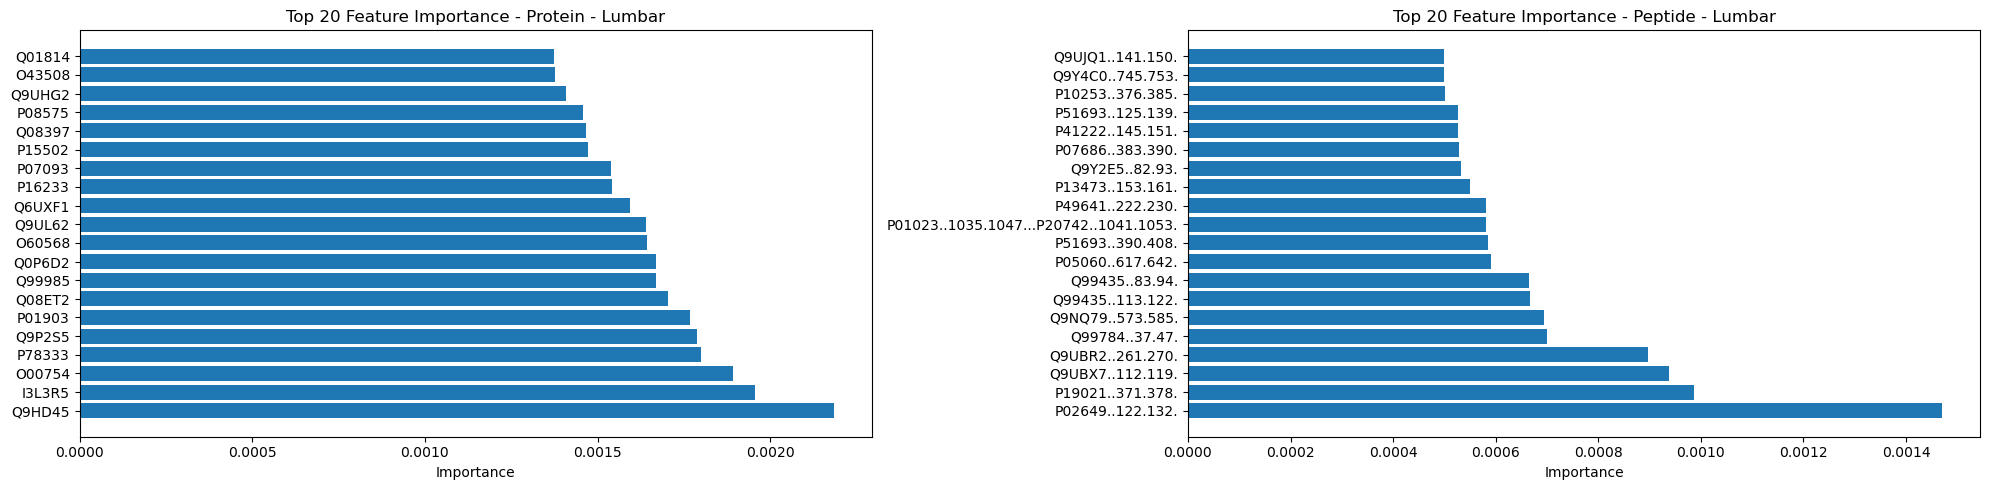

In [63]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - LUMBAR ---#
protein_features_l_0 = random_forest_feature_extraction(df_proteins_all_lumbar_zero, "Cortical_biopsy_grouping", 100)
peptide_features_l_0 = random_forest_feature_extraction(df_peptides_all_lumbar_zero, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_l_0, peptide_features_l_0, 20, "Lumbar")

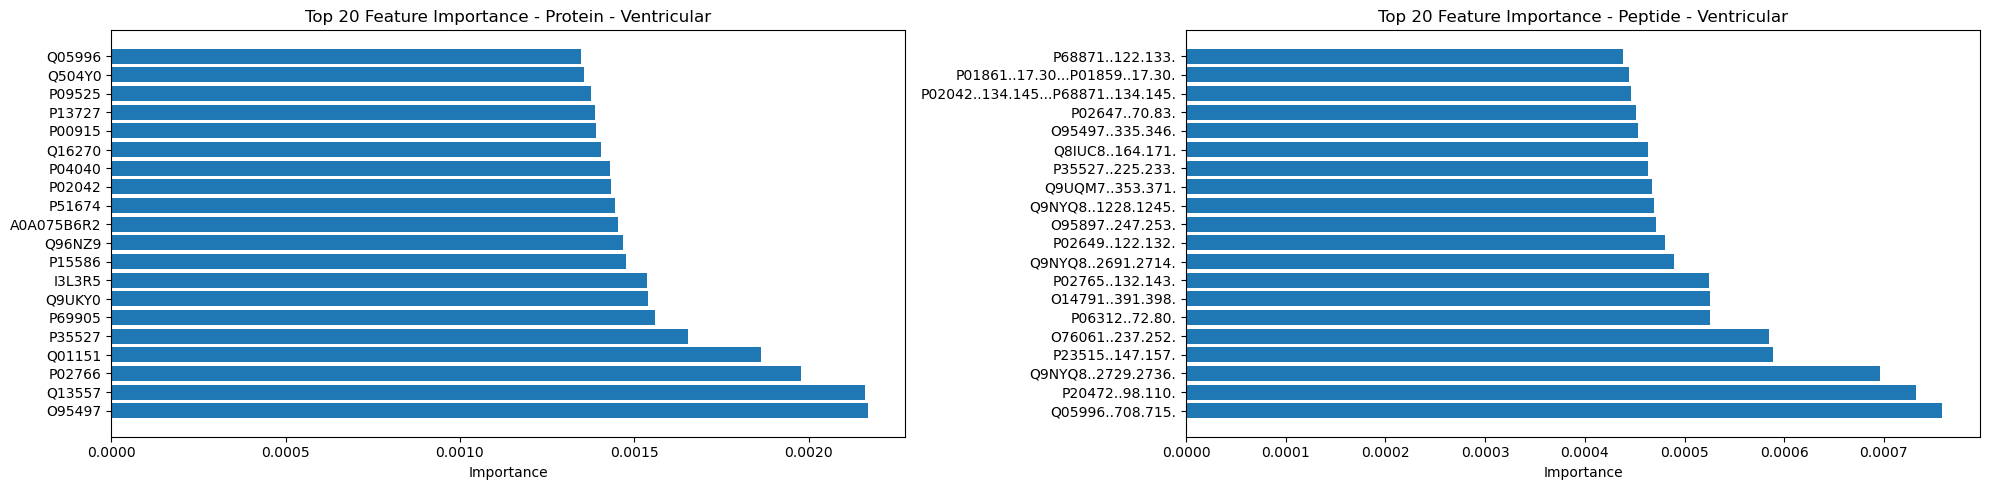

In [64]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - VENTRICULAR ---#
protein_features_v_0 = random_forest_feature_extraction(df_proteins_all_ventricular_zero, "Cortical_biopsy_grouping", 100)
peptide_features_v_0 = random_forest_feature_extraction(df_peptides_all_ventricular_zero, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_v_0, peptide_features_v_0, 20, "Ventricular")

As with the random forest feature extraction on the datasets free from missingness, these graphs shows important features on zero imputed datasets, and the results are roughly the same. The peptide samples have slightly more in common compared to the protein datasets. The all samples show some correlation to the top 20 of the lumbar and ventricular data, but some of the proteins and peptides in the all dataset contains features not shown in the top 20.

### Lumbar & Ventricular, Feature Importance Differences - (Different Imputations)

In [65]:
def get_feature_importance_df(*args):
    """Creates a df based on feature importance, comparing lumbar and ventricular data.

    :param args: Pandas series with feature importances and Pandas series with feature importances.

    :return: Dataframe with feature importance of both lumbar and ventricular data."""     
    dfs = [pd.DataFrame({'index': series.index, series.name: series.values}) for series in args]

    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='index', how='outer')

    return merged_df

In [66]:
#--- EXTRACTING FEATURE IMPORTANCE FEATURES BASED ON IMPUTATION, AND HOW THEY DIFFER ---#
protein_features_l.name = 'Protein_Lumbar_NoNaN' 
protein_features_v.name = 'Protein_Ventricular_NoNaN'
protein_features_l_0.name = 'Protein_Lumbar_0'
protein_features_v_0.name = 'Protein_Ventricular_0'
feature_importance_df = get_feature_importance_df(protein_features_l, protein_features_v, protein_features_l_0, protein_features_v_0)
feature_importance_df

index  Protein_Lumbar_NoNaN  Protein_Ventricular_NoNaN  \
0     P01903              0.003794                   0.001943   
1     O00754              0.003690                   0.001152   
2     P07093              0.003674                   0.001220   
3     Q9HD45              0.003663                   0.000872   
4     Q0P6D2              0.003242                   0.000487   
...      ...                   ...                        ...   
2790  O00483                   NaN                        NaN   
2791  P62861                   NaN                        NaN   
2792  O95837                   NaN                        NaN   
2793  Q3SY84                   NaN                        NaN   
2794  P22694                   NaN                        NaN   

      Protein_Lumbar_0  Protein_Ventricular_0  
0             0.001768               0.000922  
1             0.001893               0.000401  
2             0.001538               0.000641  
3             0.002185               0.000255  
4             0.001669               0.000386  
...                ...                    ...  
2790          0.000000               0.000000  
2791          0.000000               0.000000  
2792          0.000000               0.000000  
2793          0.000000               0.000060  
2794          0.000000               0.000046  

[2795 rows x 5 columns]

The above code shows how the feature importance extracted from the random forest changes depending on Lumbar / Ventricular and imputation type (removing missing values vs zero-imputation). 

This can show both how the importance changes depending on imputaiton type, as well as the difference in importance depending on where the sample is taken from.

It also shows that the feature importance has more correlation between lumbar to lumbar and ventricular to ventricular than it has between imputation methods (lumbar_0 to ventricular_0)

In [67]:
def get_compare_feature_importance(df, col1, col2, min_dif = 0.002000):
    """Find features that differ between two of the columns with more than a certain difference.

    :param df: DataFrame.
    :param col1: Column name.
    :param col2: Column name.
    :param min_dif: Minimum difference between the values of two columns.
    
    :return: DataFrame with all features with minimum difference."""
    diff_rows = []

    for index, row in df.iterrows():
        lumbar_value = row[col1]
        ventricular_value = row[col2]
        
        if abs(lumbar_value - ventricular_value) > min_dif:
            diff_rows.append(row)

    diff_df = pd.DataFrame(diff_rows)

    return diff_df

In [68]:
get_compare_feature_importance(feature_importance_df, "Protein_Lumbar_NoNaN", "Protein_Ventricular_NoNaN", 0.00200)

index  Protein_Lumbar_NoNaN  Protein_Ventricular_NoNaN  \
1    O00754              0.003690                   0.001152   
2    P07093              0.003674                   0.001220   
3    Q9HD45              0.003663                   0.000872   
4    Q0P6D2              0.003242                   0.000487   
7    O60568              0.002943                   0.000782   
67   P02766              0.001558                   0.003728   
295  P01859              0.000994                   0.003142   
702  Q96NZ9              0.000671                   0.002794   
959  P15586              0.000522                   0.002659   

     Protein_Lumbar_0  Protein_Ventricular_0  
1            0.001893               0.000401  
2            0.001538               0.000641  
3            0.002185               0.000255  
4            0.001669               0.000386  
7            0.001644               0.000369  
67           0.000650               0.001978  
295          0.000696               0.001313  
702          0.000476               0.001469  
959          0.000279               0.001476

The above code shows the proteins (or peptides) that differ between Lumbar and Ventricular samples with a certain feature importance value. This shows how some features have higher importancen depending on if they are from lumpar or ventricular samples.

### High Missingness Feature Importance

In [69]:
#--- RUNS XGBOOST FEATURE EXTRACTION ON HIGH MISSINGNESS DATASETS ---#
df_high_missingness_proteins = set_max_missingness_per_column(df_proteins, 0.8, True)
df_high_missingness_peptides = set_max_missingness_per_column(df_peptides, 0.8, True)

top_features_proteins_all = xgb_feature_extraction(df_high_missingness_proteins, df_proteins_all['Cortical_biopsy_grouping'])
top_features_peptides_all = xgb_feature_extraction(df_high_missingness_peptides, df_peptides_all['Cortical_biopsy_grouping'])

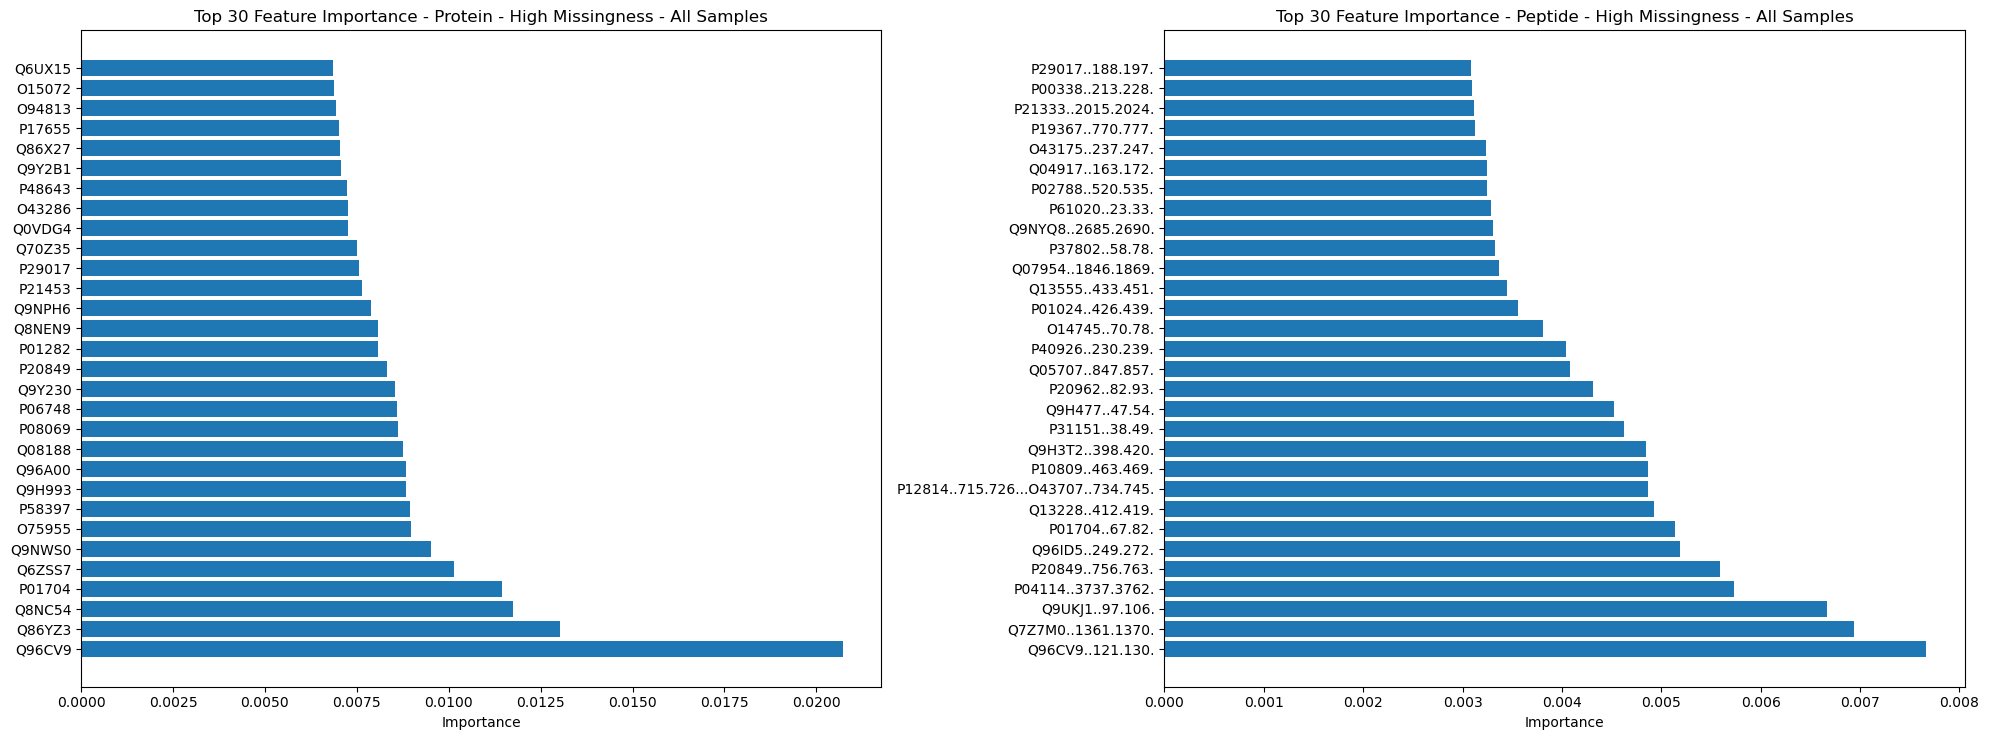

In [70]:
visualize_top_features(top_features_proteins_all, top_features_peptides_all, 30, 'High Missingness - All Samples')

These plots shows the feature importance on proteins and peptides that has 80% or more missingness. It shows that among the features with a lot of missingness, there are some that seems to have influence on the predictive power of the model. This may suggest that some of the features with 80% or more missingness should be imputed, as it may help with the model.

### Wilcoxon-Mann-Whitney p-value test

In [71]:
test_proteins_df = do_mww_tests(set_max_missingness_per_column(df_proteins_all, 0), set_max_missingness_per_column(df_proteins, 0), 0, "Cortical_biopsy_grouping")
test_proteins_df

{'A0A075B6R2': 0.0334754256532152,
 'P47972': 0.0293939074311202,
 'O14791': 0.04511479399672327,
 'P06312': 0.04540804450349168,
 'Q08397': 0.03148529629404439,
 'Q9Y2G1': 0.01589173408471616,
 'P04040': 0.012275000432410178,
 'Q9ULX7': 0.049368755411668686,
 'Q9NZN1': 0.04540804450349168,
 'A0A0C4DH24': 0.04482314185118411,
 'Q6P179': 0.022021113695860326,
 'O95497': 0.018772629084269073,
 'Q13641': 0.048741178137532856,
 'I3L3R5': 0.017962879305281232}

# Imputation

## SimpleImpute & t-SNE

### Code

In [39]:
class SampMin(SimpleImputer):
    """
        SampMin imputation strategy. Imputes values with the lowest observed value for each column/feature.
    """
    def fit(self, X, y=None):
        X = X.dropna(axis=1, how='all')
        self.min_values = X.min() 
        return X

    def transform(self, X):
        return X.fillna(self.min_values)
    
    def fit_transform(self, X):
        X = self.fit(X)
        return self.transform(X)


In [73]:
def plot_tnses(tsne, c, title, ax):
    ax.scatter(tsne[:, 0], tsne[:,1], c=c, cmap="tab20")
    ax.set_title(title)
    ax.set_xlabel("T-SNE_1")
    ax.set_ylabel("T-SNE_2")

In [74]:
def apply_tsne(df, n_components = 2, random_state = None, perplexity = 5):
    """Applies T-SNE by fit_transform()

    :param df: Dataframe that's going to be fit_transformed()
    :param n_components: Threshold percentage of missingness allowed per column.
    :param random_state: Seed for random state
    :param perplexity: Sets the perplexity i.e. roughly a global/local cluster trade-off
    
    :return: T-SNE object""" 
    return TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity).fit_transform(df)

In [75]:
def impute_and_plot(dfs, cs, titles):
    """Imputes using SimpleImputer strategies and creates T-SNE plots for each strategy.

    :param dfs: List of Dataframes to remove NaN-heavy columns from.
    :param cs: List of Threshold percentages of missingness allowed per column.
    :param titles: List of Plot titles (usually ventricular/lumbar and proteins/peptides)""" 
    imputation_methods = ["SampMin", "mean", "median", "constant"]
    num_plots = len(dfs)
    fig, axes = plt.subplots(num_plots, len(imputation_methods), figsize=(24, 4*num_plots))

    for i, df in enumerate(dfs):
        for j, method in enumerate(imputation_methods):
            ax = axes[i, j]
            if method == "SampMin":
                imputer = SampMin(strategy=method, missing_values=np.nan)
            else:
                imputer = SimpleImputer(strategy=method, missing_values=np.nan, fill_value=0)
            df_imputed = imputer.fit_transform(df)
            tsne = apply_tsne(df_imputed)
            plot_tnses(tsne, c=cs[i], title=titles[i] + " (" + method + ")", ax=ax)

    plt.tight_layout()
    plt.show()

### Imputing and plotting

#### Proteins

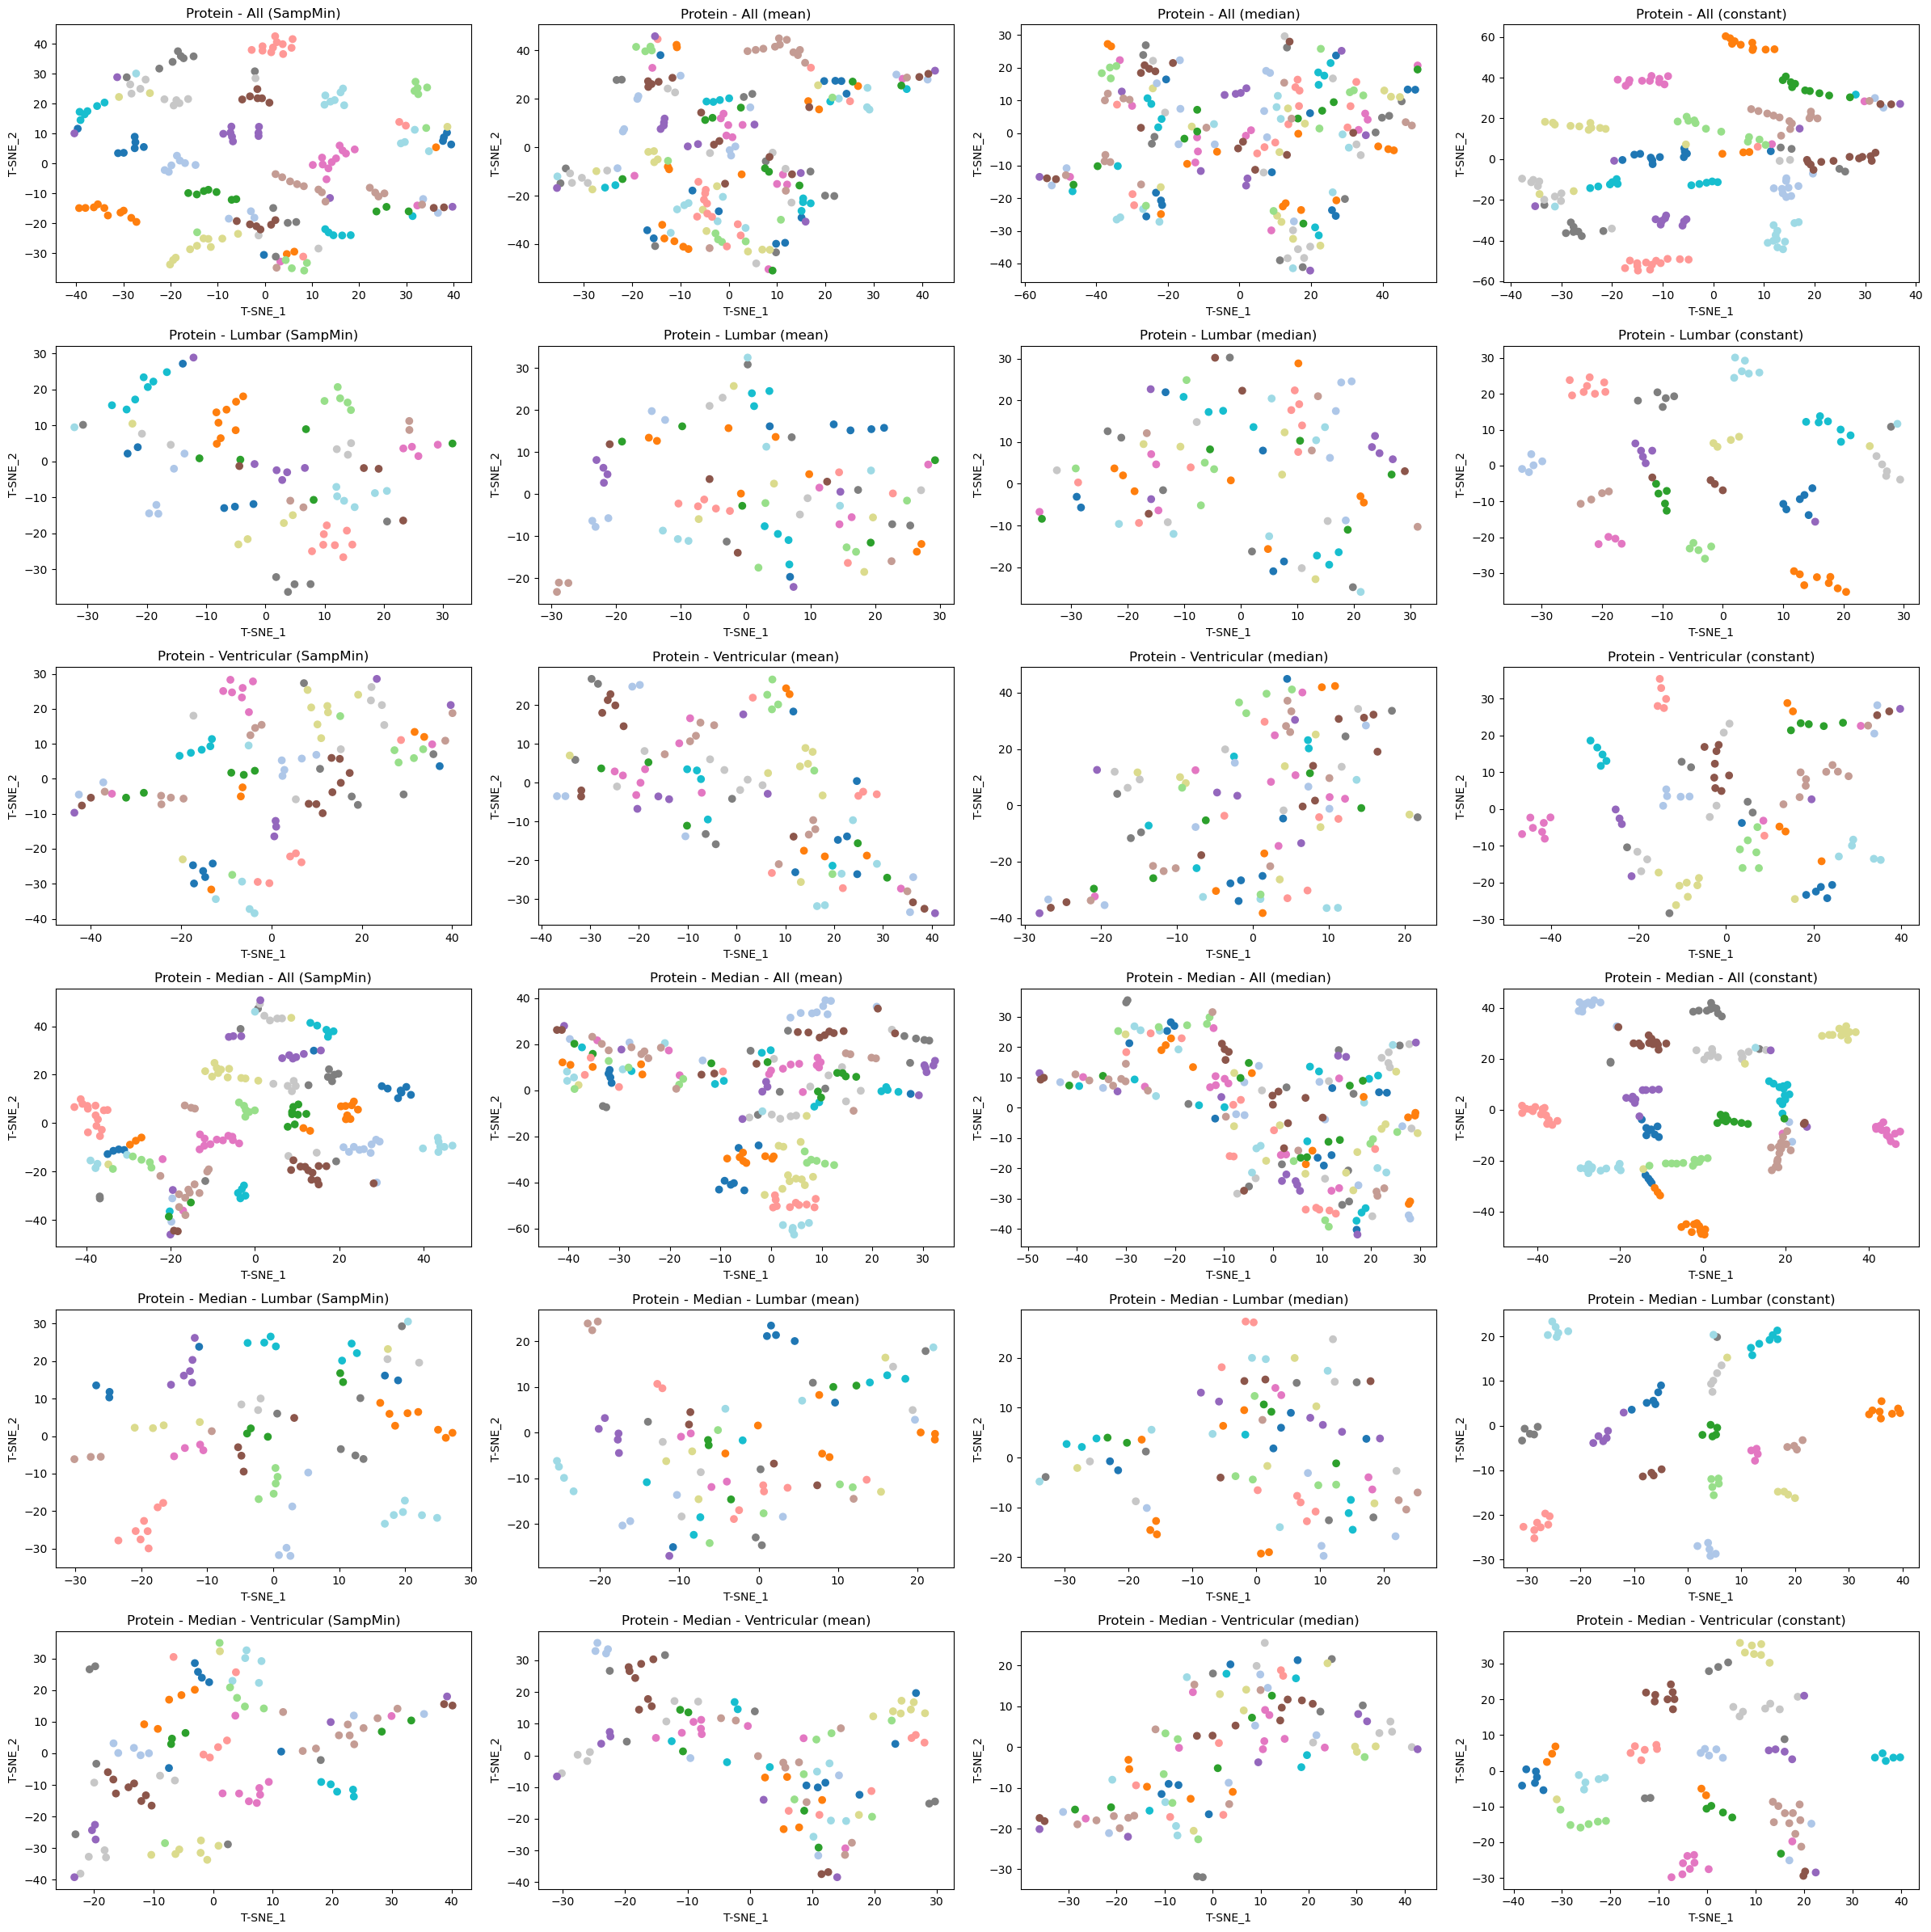

In [76]:
#Removes unnecessary warning
warnings.filterwarnings("ignore", message="Skipping features without any observed values")
dfs_protein = [df_proteins, df_proteins_lumbar, df_proteins_ventricular, df_proteins_median, df_proteins_median_lumbar, df_proteins_median_ventricular]
cs_protein = [df_proteins_all["TMT Set"], df_proteins_all_lumbar["TMT Set"], df_proteins_all_ventricular["TMT Set"],
      df_proteins_median_all["TMT Set"], df_proteins_median_all_lumbar["TMT Set"], df_proteins_median_all_ventricular["TMT Set"]]
titles_protein = ['Protein - All', 'Protein - Lumbar', 'Protein - Ventricular', 'Protein - Median - All', 'Protein - Median - Lumbar', 'Protein - Median - Ventricular']
impute_and_plot(dfs_protein, cs_protein, titles_protein)

The goal of the above code and plot is to reduce the effect of batching. Therefore, the more chaotic the t-SNE plot is, the better. Overall, SampMin and constant imputation seems to result in fairly poor plots, as the batch effect is still clearly visable as the grouping are present. Mean and median imputation however seems strong, as most of the groupings are gone.

#### Peptides

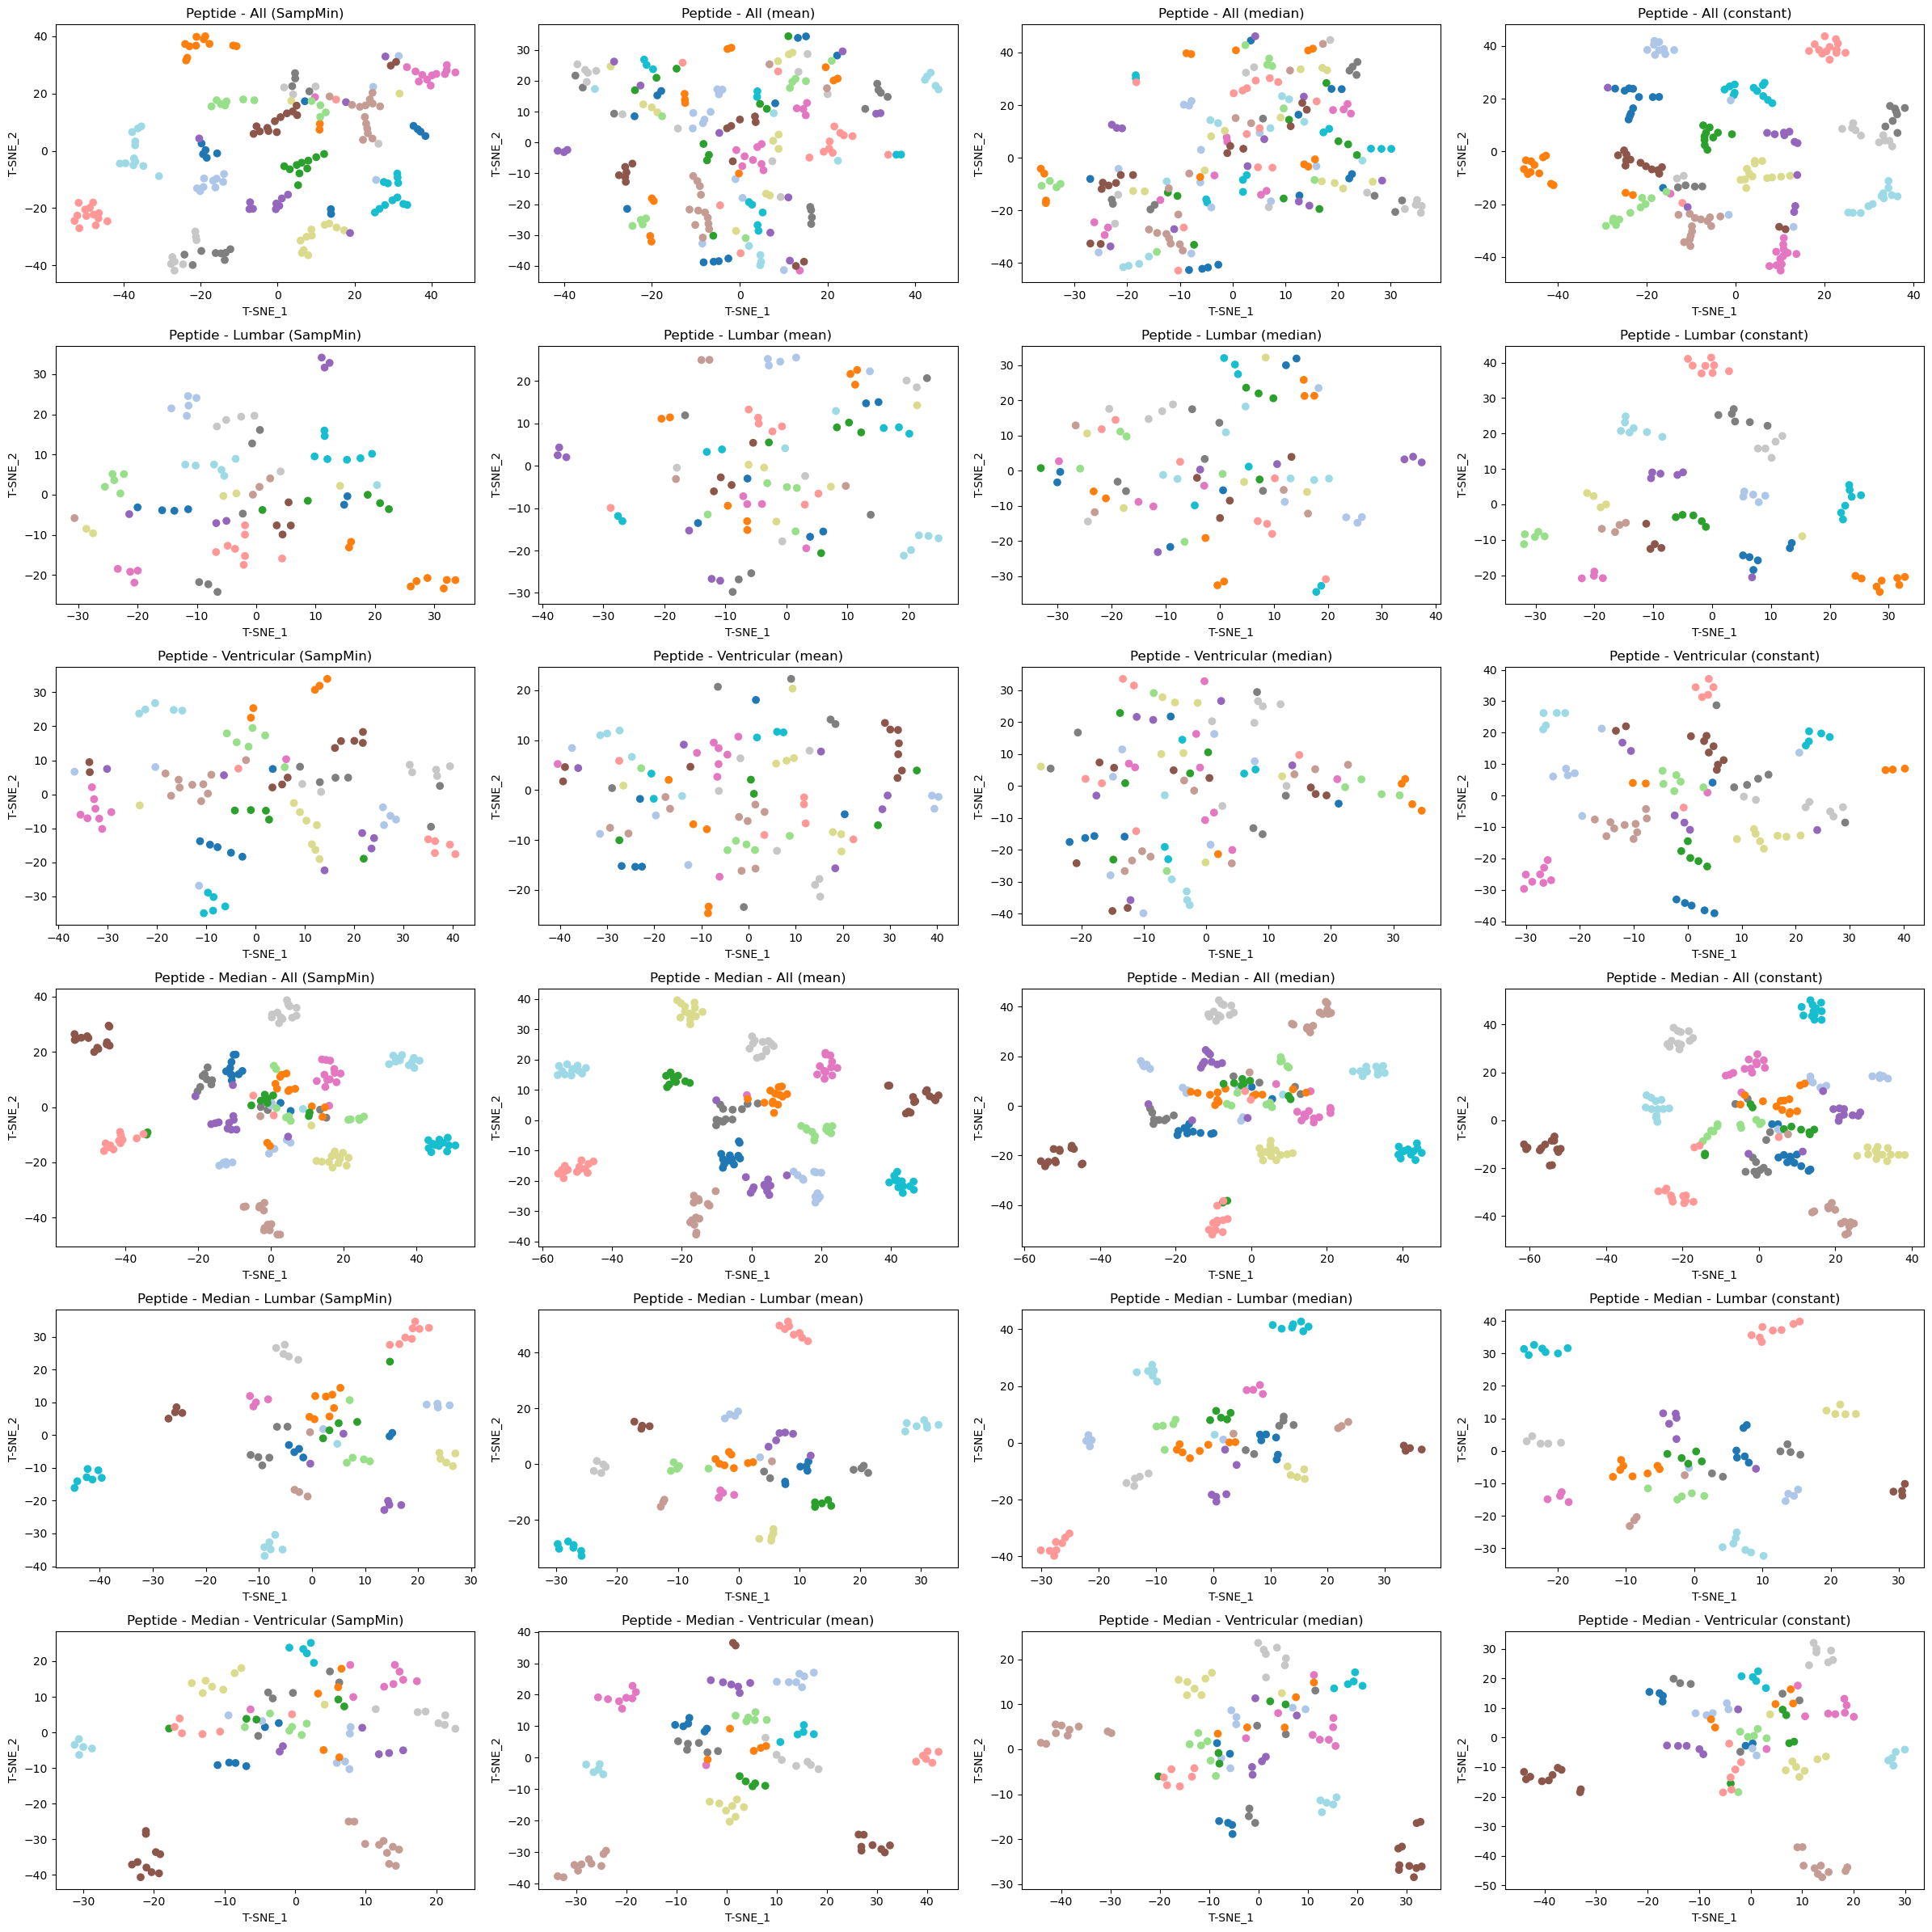

In [77]:
dfs_peptides = [df_peptides, df_peptides_lumbar, df_peptides_ventricular, df_peptides_median, df_peptides_median_lumbar, df_peptides_median_ventricular]
cs_peptides = [df_peptides_all["TMT Set"], df_peptides_all_lumbar["TMT Set"], df_peptides_all_ventricular["TMT Set"],
      df_peptides_median_all["TMT Set"], df_peptides_median_all_lumbar["TMT Set"], df_peptides_median_all_ventricular["TMT Set"]]
titles_peptides = ['Peptide - All', 'Peptide - Lumbar', 'Peptide - Ventricular', 'Peptide - Median - All', 'Peptide - Median - Lumbar', 'Peptide - Median - Ventricular']
impute_and_plot(dfs_peptides, cs_peptides, titles_peptides)

The peptide dataset seems to be affected by the imputations less than the proteins, as there is still quite a lot of batch effect in all the above plots. This is especially true in the peptide dataset that has already been mean normalized.

## Batch Correction

Below, we apply the ComBat batch effect correction algorithm to make a simple investigation of the batch effect after imputing protein lumbar data with SampMin.

In [66]:
def run_combat(df, TMT_set_indices):
    """Run ComBat to reduce batch effect on a dataframe.

    :param df: Dataframe that ComBat is runned on
    :param TMT_set_indices: Labels of which TMT batch each row belongs to.
    
    :return: DF with ComBat applied to it"""    
    return pycombat(df.T, TMT_set_indices).T

In [78]:
imputer = SampMin(strategy="SampMin", missing_values=np.nan)
data = imputer.fit_transform(df_proteins)
data_corrected = pycombat(data.T, df_proteins_all["TMT Set"])

Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


c:\Users\Toffe\anaconda3\Lib\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


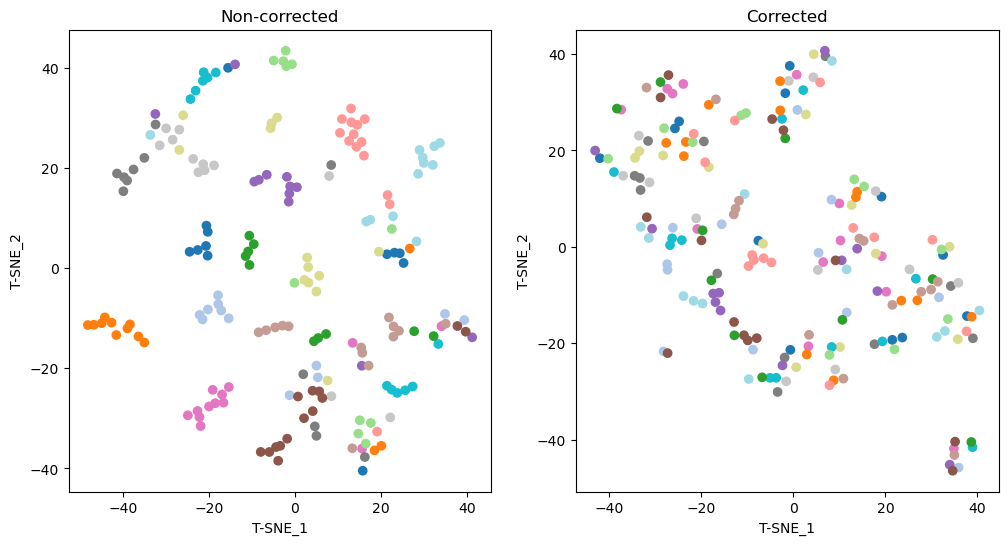

In [79]:
#--- PLOTTING T-SNE COMPARING BATCH-CORRECTED AND NON-CORRECTED PLOT ---#
tsne = TSNE(n_components=2, perplexity=5)
tsne_1 = tsne.fit_transform(data)
tsne_2 = tsne.fit_transform(data_corrected.T)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_tnses(tsne_1, df_proteins_all["TMT Set"], "Non-corrected", axes[0])
plot_tnses(tsne_2, df_proteins_all["TMT Set"], "Corrected", axes[1])

By observing the two above plots. We can clearly see that the batch effect is not as appearant after applying ComBat. However, further investigation is neccessary to ensure the data quality is fine. It's also worth to investigate after the data is imputed with a more refined imputation technique such as MICE.

## Miceforest

In [80]:
df_imputation = set_max_missingness_per_column(df_proteins_lumbar, 0.1)

In [81]:
kds = mf.ImputationKernel(
    df_imputation,
    datasets = 1,
    random_state=1990,
    save_all_iterations=False
)

kds.mice(
    iterations=1
)

completed_data = kds.complete_data()

**df_proteins_lumbar**

datasets = 2,  iterations = 2,  missingness = 0.1 (955)   --> 2m   6.7s

datasets = 2,  iterations = 2,  missingness = 0.2 (3126)  --> 4m   31.4s

datasets = 5,  iterations = 2,  missingness = 0.1 (955)   --> 5m   25.3s

datasets = 2,  iterations = 5,  missingness = 0.1 (955)   --> 5m   7.4s

datasets = 5,  iterations = 5,  missingness = 0.2 (3126)  --> 29m  32.9s

datasets = 10, iterations = 10, missingness = 0.2 (3126)  --> 111m 41.5s

datasets = 5,  iterations = 10, missingness = 0.5 (12939) --> 200m 24.5s



**df_peptides_lumbar**

datasets = 1, iterations = 1, missingness = 0.1 (8065),   cols = 5273  --> 25m  12.7s

datasets = 1, iterations = 1, missingness = 0.2 (25328),  cols = 6613  --> 64m  51.1s

datasets = 1, iterations = 1, missingness = 0.5 (123942), cols = 9924  --> 246m 38.6s



**df_proteins_lumbar**

datasets = 1, iterations = 1, missingness = 0.4 (9119),    cols = 1758  --> 4m  28.8s

datasets = 1, iterations = 1, missingness = 0.7 (26281),   cols = 2114  --> 4m  8.9s

This shows the correlation between the number of datasets, iterations, missingness amount and number of columns available in regard to time taken to impute by multiple imputation. Datasets and iterations seems to have a fairly linear relationship with the time, as can be seen in example 1 and 3. The number of missing values itself seems to have a symbiosis with number of columns for its effect, but the exact quanity is unknown. However, as can be seen if we compare the last example of proteins vs the second to last in peptides, the peptide dataset, with more columns, takes a lot more time to complete compared to the protein dataset.

# Fixing Dataset (Pipeline and Synthetic)

## Preprocessing Dataframe Pipeline

In [35]:
def df_cleaner_pipeline(df, csf_type, sample="Peptide", max_missingness=0.5):
    """Cleaning pipeline used for final datasets. The final pipeline removed 
    many of the cleaning features initially used, as they were deemed exessive 
    or even harmfull, introducing biases.

    :param df: Dataframe.
    :param csf_type: CSF type to get.
    :param sample: Setting for protein or peptide, as they have different cleaning methods.
    :param max_missingness: Max missingness in each column, removing the other features.
    
    :return: DF with ComBat applied to it"""  
    df = remapp_id(df)
    df = df[df['CSF_type'] == csf_type].iloc[:, 11:]

    if sample == "Protein":
        df = replace_zero_with_val(df)

    else:
        df = replace_inf_with_nan(df)
    
    df = np.log2(df)
    df = remove_outliers(df)
    df = set_max_missingness_per_column(df, max_missingness)

    return df

In [36]:
df_peptide_median_all = pd.read_csv('Data//data files//iNPH_data_peptide_median.csv', index_col=0)
df_peptide_lumbarz = df_cleaner_pipeline(df_peptide_median_all, "L")
df_peptide_ventricular = df_cleaner_pipeline(df_peptide_median_all, "V")

#Imputation
#StandardScaler

In [47]:
imputer = SampMin(strategy="SampMin", missing_values=np.nan)
df_peptide_lumbar = imputer.fit_transform(df_peptide_lumbar)
df_peptide_ventricular = imputer.fit_transform(df_peptide_ventricular)

In [51]:
df_peptide_ventricular.to_csv('df_peptide_ventricular.csv', index=False)

## Oversampling

### Perturbation

In [ ]:
# Run the cleaning pipe and set y as the classes
X = df_cleaner_pipeline(df_proteins_median_all, csf_type="L", sample = "Protein", max_missingness=0)
y = df_proteins_median_all_lumbar["Cortical_biopsy_grouping"]

In [ ]:
# Run SMOTE with maximum no. of neighbours
smote = SMOTE(k_neighbors=9)
X_res, y_res = smote.fit_resample(X, y)

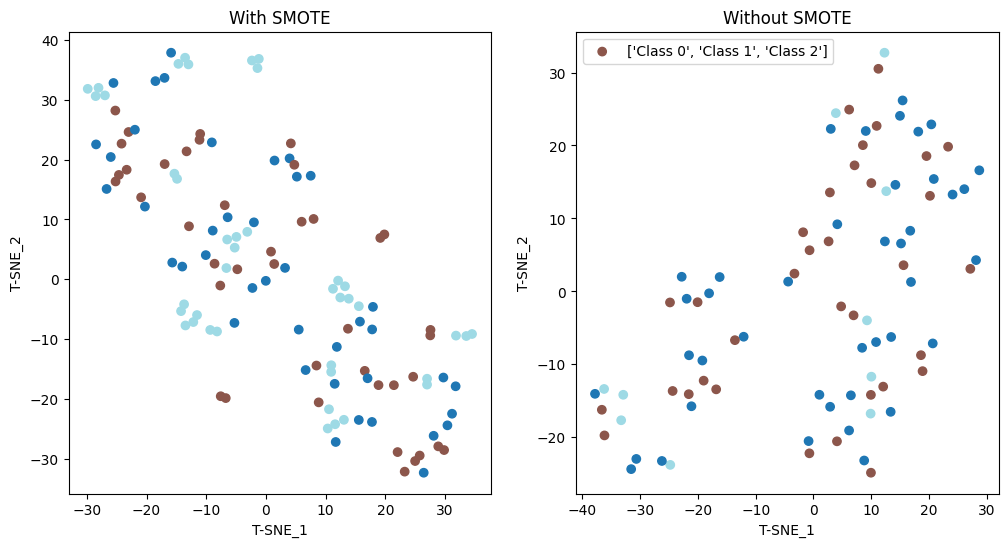

In [ ]:
tsne = TSNE(n_components=2, perplexity=5)
tsne_1 = tsne.fit_transform(X_res.iloc[:, 9:])
tsne_2 = tsne.fit_transform(X.iloc[:, 9:])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_tnses(tsne_1, y_res, "With SMOTE", axes[0])
plot_tnses(tsne_2, y, "Without SMOTE", axes[1])
plt.legend()

Here we can see that when generating new samples, we get larger clusters of the same class, especially for AD in which we generated most of the synthetic data. This could be a bit worrying since it may result in overfitting.

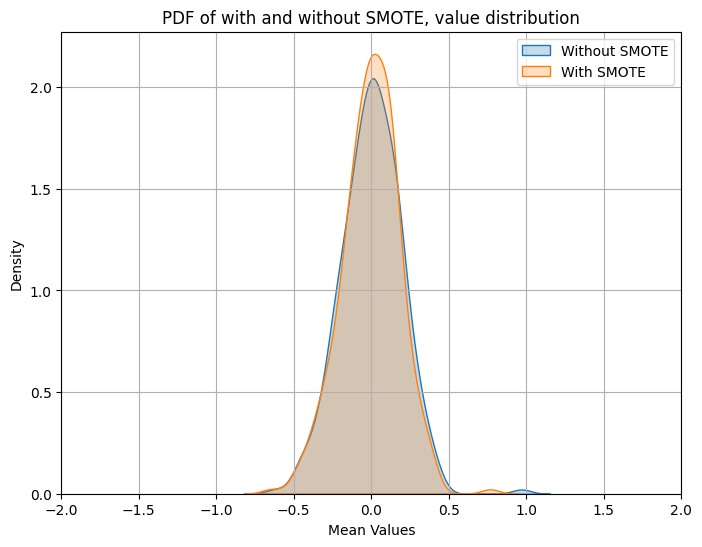

In [ ]:
plot_mean_values_pdf(X.iloc[:, 9:], X_res.iloc[:, 9:], legend=['Without SMOTE', 'With SMOTE'], title='PDF of with and without SMOTE, value distribution', xlim=(-2,2))

Means are roughly the same, slightly lower variance with SMOTE

In [ ]:
def add_noise(df, n_samples, std = 0.1):
    """Helper function for simple perturbation function. Adds gaussian noise to randomly sampled rows of the df passed as an argument.

    :param df: df filtered on class
    :param n_samples: Number of samples to perform random sampling on
    :param std: Standard deviation. Defaults to 0.1.
    
    :return: df with added perturbed samples"""      
    sampled_df = df.sample(n = n_samples, replace = True)
    gaussian_noise = np.random.normal(0, std, size=sampled_df.shape)
    return sampled_df + gaussian_noise

In [ ]:
def simple_perturbation(X, y, n_samples_per_class = None, std = 0.1):
    """Performs a simple perturbation by sampling random rows of classes and adds gaussian noise to them

    :param X: Dataframe with samples to get perturbed
    :param y: Class labels
    :param n_samples_per_class: Decides how many samples per class that are going to be sampled, defaults to None. 
    If none -> all classes will get equal weight according to size of current largest class.
    :param std: How much the noise can deviate from the mean (Standard dev.), defaults to 0.1
    
    :return: A df with the perturbed samples. A list stating which row belongs to which class."""    
    classes = y.value_counts()
    if n_samples_per_class is None:
        largest_class = classes.argmax()
        largest_n_samples = classes.pop(largest_class)
    else:
        largest_n_samples = n_samples_per_class
    df_list = []
    y_new_classes = list(y)
    for idx, n_samples in classes.items():
        perturbed = add_noise(X[y == idx], largest_n_samples - n_samples, std=std)
        df_list.append(perturbed)
        y_new_classes = y_new_classes + [idx] * len(perturbed)
    return pd.concat([X] + df_list, axis=0), y_new_classes#, ignore_index=True)

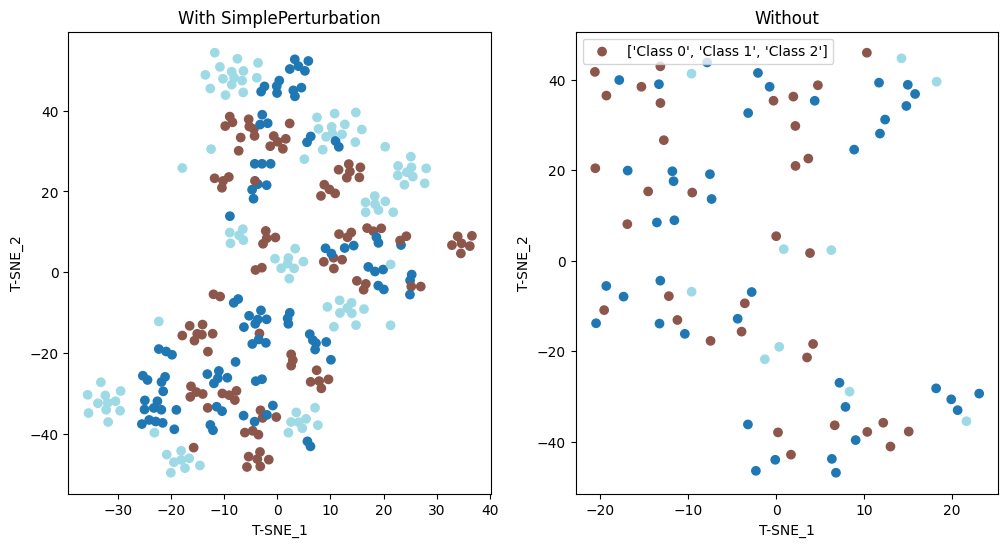

In [ ]:
perturbed_X, perturbed_y = simple_perturbation(X, y, n_samples_per_class = 100, std=1)


tsne = TSNE(n_components=2, perplexity=5)
tsne_1 = tsne.fit_transform(perturbed_X)
tsne_2 = tsne.fit_transform(X.iloc[:, 9:])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_tnses(tsne_1, perturbed_y, "With SimplePerturbation", axes[0])
plot_tnses(tsne_2, y, "Without", axes[1])
plt.legend()

In this case we have synthetically created a balanced data set of 100 rows per class with a std = 1. We can see clusters forming around the original datapoints. Depending on how large the std is, the density of the clusters will obviously vary.

# LASSO & GridSearchCV Test

In [40]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold

In [41]:
X = df_proteins_lumbar_zero.values
y = df_proteins_all_lumbar_zero["Cortical_biopsy_grouping"].values

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (84, 2795)
Shape of Test Features: (1, 2795)
Shape of Train Target: (84,)
Shape of Test Target: (1,)


In [42]:
# parameters to be tested on GridSearchCV
params = {"alpha":(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso(max_iter=10000, tol=0.0002)

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e-02, tolerance: 5.656e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e-02, tolerance: 5.656e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e-02, toleranc

Best Params {'alpha': 10}


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.433e-02, tolerance: 7.857e-03
  model = cd_fast.enet_coordinate_descent(


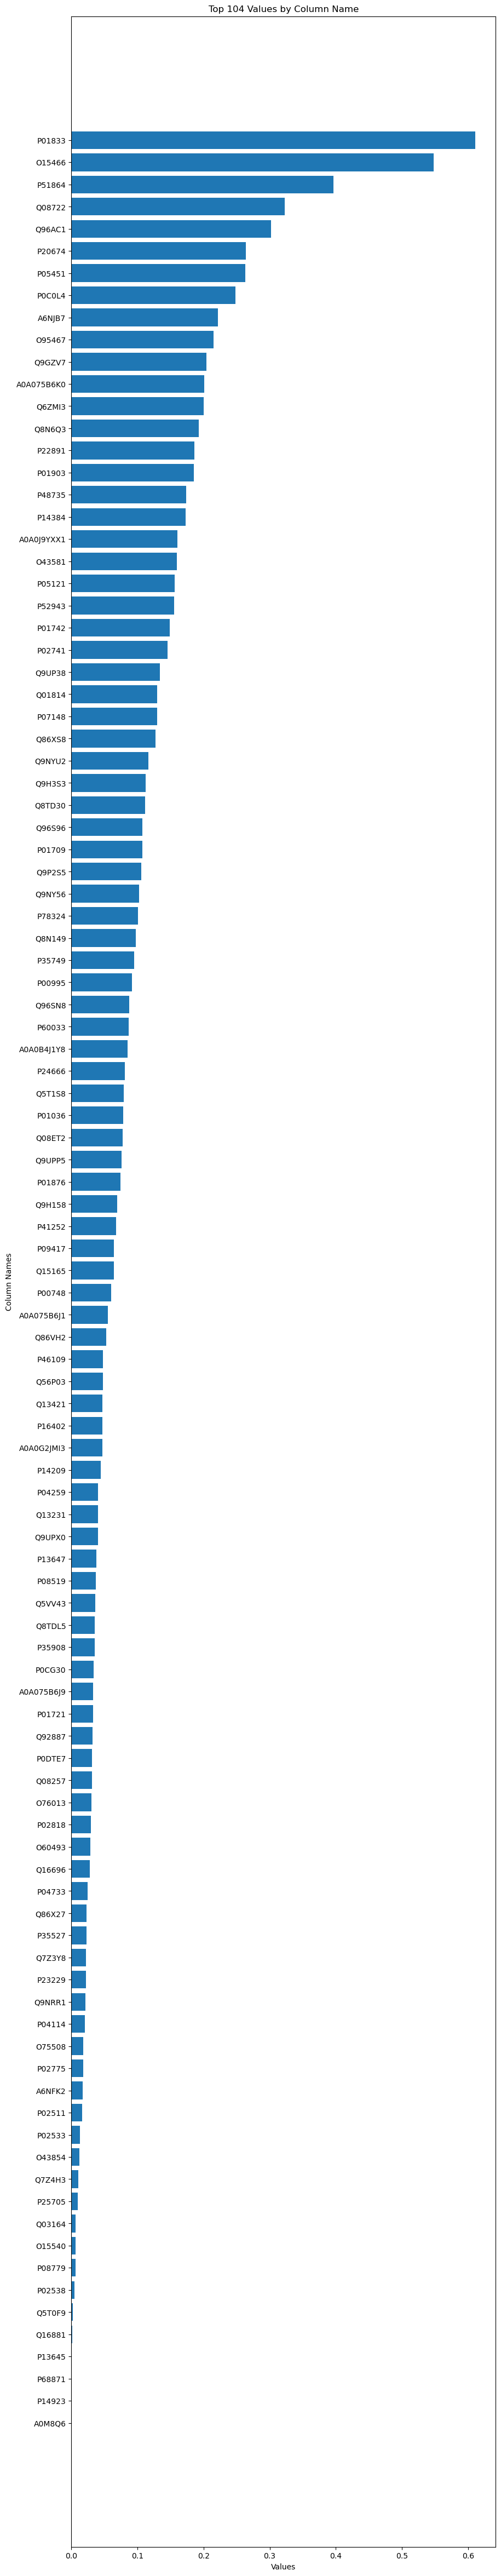

In [43]:
#FEATURE IMPORTANCE THROUGH LASSO
lasso1 = Lasso(alpha=0.0001, max_iter=10000, tol=0.0002)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

data = lasso1_coef

top_indices = np.unravel_index(np.argsort(data, axis=None)[-500:], data.shape)

# Get corresponding column names
column_names = [f'Column {idx}' for idx in range(data.shape[0])]

# Extract top 500 values and their corresponding column names
top_values = data[top_indices]
top_column_names = [df_proteins_lumbar_zero.columns[idx] for idx in top_indices[0]]

combined = list(zip(top_values, top_column_names))
filterd_combined = [(val, name) for val, name in combined if val != 0]
filtered_values, filtered_names = zip(*filterd_combined)

# Plotting
plt.figure(figsize=(10, 60))
plt.barh(filtered_names, filtered_values)
plt.xlabel('Values')
plt.ylabel('Column Names')
plt.title(f'Top {len(filtered_values)} Values by Column Name')
plt.show()

In [45]:
zero_values = (df_proteins_lumbar_zero[list(filtered_names)] == 0).any()
true_col = zero_values[zero_values].index.tolist()
df_to_check = df_proteins_lumbar[true_col]
nan_percentage = df_to_check.isna().mean().sort_values(ascending=False)
nan_percentage_filtered = nan_percentage[nan_percentage > 0.5]
nan_percentage_filtered

Q5T0F9    0.952941
Q86X27    0.941176
P20674    0.941176
Q03164    0.929412
O76013    0.929412
Q86VH2    0.917647
P16402    0.905882
Q96AC1    0.905882
P23229    0.870588
Q7Z3Y8    0.858824
P14923    0.847059
Q9UPP5    0.847059
Q9NY56    0.835294
A6NFK2    0.788235
P04259    0.776471
O60493    0.776471
Q9NYU2    0.717647
Q8TD30    0.705882
P41252    0.705882
Q16696    0.647059
Q9H158    0.623529
P0CG30    0.564706
Q9UPX0    0.529412
P52943    0.529412
Q9GZV7    0.517647
dtype: float64

These shows the feature extraction process of LASSO. The features extracted are the 247 features with importance over 0. The features shown above are the features with more than 50% missingness in their column, and could be added onto of the missingness table we use for imputation (max missingness = 50% per columns, and then add feature with more missingness but with high importance according to LASSO regression).